In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:28992')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [3]:
starting_hour = 1000/(60*60*4)
next_hours = np.arange(0.25,12.25,0.25)
hours = np.append(np.array([starting_hour]),next_hours)

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

for hour in reversed(hours):
    coords.append(transform(utm_to_wgs,Point(155000-hour*60*60*4,463000)))
for hour in hours:
    coords.append(transform(utm_to_wgs,Point(155000+hour*60*60*4,463000)))

for index,coord in enumerate(coords):
    data_node = {"env": [],
                 "name": "Node_" + str(index+1),
                 "geometry": coord}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [5]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = int(geometry.length)
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [6]:
import pytz
simulation_start = datetime.datetime(2019,1,1,0,0,0)
duration = datetime.timedelta(seconds=14*24*60*60) #seconds

In [7]:
water_level = []
salinity = []

for nodes in enumerate(FG.nodes):
    water_level.append([[],[]])
    salinity.append([[],[]])

MBL = [11]*len(FG.nodes)
depth = MBL
times = np.arange(simulation_start,simulation_start+duration,datetime.timedelta(seconds=10*60))
stations = list(FG.nodes)

sea = True
for index,node in enumerate(list(FG.nodes)):
    if sea:
        water_level[index]=[1.0*np.sin(2*np.pi*((t-np.datetime64(0,'s'))/np.timedelta64(1, 's')-simulation_start.timestamp())/45000) for t in times]
        salinity[index]=[25.0 for t in times]
        if node == 'Node_49':
            sea = False
    else:
        water_level[index]=[0.0 for t in times]
        salinity[index]=[0.0 for t in times]

In [8]:
import xarray as xr
station_data = xr.DataArray(data=stations,
                         dims=["STATIONS"])

time_data = xr.DataArray(data=times,
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL,
                        dims=["STATIONS"])

depth_data = xr.DataArray(data=depth,
                          dims=["STATIONS"])

water_level_data = xr.DataArray(data=[wlev for wlev in water_level],
                                dims=["STATIONS","TIME"])

salinity_data = xr.DataArray(data=[sal for sal in salinity],
                             dims=["STATIONS","TIME"])

hydrodynamic_data = xr.Dataset({'TIME':times,
                                'Stations':station_data,
                                'MBL':MBL_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_17964\3095883058.py:5: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_17964\3095883058.py:20: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by con

In [9]:
sim = model.Simulation(graph=FG,simulation_start=simulation_start,simulation_duration=duration,hydrodynamic_data=hydrodynamic_data)
env = sim.environment

In [10]:
sim.environment.vessel_traffic_service

In [11]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Lock',
                     distance_doors1_from_first_waiting_area=750,   
                     distance_doors2_from_second_waiting_area=FG.edges['Node_49','Node_50',0]['Info']['length']-1250,
                     node_doors1 = 'Node_49', node_doors2 = 'Node_50',time_step=60,
                     lock_length = 500, lock_width = 40, lock_depth = 10.5, 
                     doors_open = 600, doors_close = 600, disch_coeff = 0.8,
                     opening_area = 4.0, opening_depth = 5.0,node_open='Node_50',
                     detector_nodes=['Node_45','Node_54'], priority_rules = regulations.ConditionalRule('start_node','==','Node_50'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Lock', distance_to_lock_doors = 100,
                                      start_node = 'Node_49',end_node = 'Node_50', lineup_length = 500)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Lock", distance_to_lock_doors = 100,
                                      start_node = 'Node_50',end_node = 'Node_49', lineup_length = 500)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Lock', distance_from_node=0,
                                        node = 'Node_49')
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Lock", distance_from_node=0,
                                        node = 'Node_50')

c:\users\floorbakker\opentnsim\opentnsim\lock.py:343: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [12]:
lock_1.detector_nodes[0]

'Node_45'

In [13]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [14]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [15]:
random.seed(0)
month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'inbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_1',
                                            destination='Node_98',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True

month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'outbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_98',
                                            destination='Node_1',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True
    

In [16]:
waiting_area_1.resource.users

[]

In [17]:
t1 = timepy.time()
sim.run()
t2 = timepy.time()
print(t2-t1)

outbound_vessel_0
outbound_vessel_1
inbound_vessel_0
outbound_vessel_2
inbound_vessel_1
inbound_vessel_2
outbound_vessel_3
inbound_vessel_3
hi got outbound_vessel_0 2019-01-01 12:01:33.438305 300
outbound_vessel_4
outbound_vessel_5
haiii outbound_vessel_0
haiii outbound_vessel_0
outbound_vessel_0 start waiting time 2019-01-01 13:00:14.271638 300
claim the lock doors outbound_vessel_0 2019-01-01 13:00:14.271638
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_0 2019-01-01 13:00:14.271638 0 1
outbound_vessel_0 0
lock doors claimed outbound_vessel_0 2019-01-01 13:00:14.271638
outbound_vessel_0 sail to assigned lock position
inbound_vessel_4
left doors1 outbound_vessel_0 2019-01-01 13:11:20.938305 0 [] ['outbound_vessel_0']
print doors outbound_vessel_0 ['outbound_vessel_0'] []
outbound_vessel_0 in lock ['outbound_vessel_0']
outbound_vessel_0 converting hap 2019-01-01 13:11:20.938305
hi 2019-01-01 13:11:20.938305
2019-01-01 13:11:20.938305 Node_50 Node_4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_6
outbound_vessel_0 hap is geconvert 2019-01-01 14:05:20.938305
300
500
300
left lock outbound_vessel_0 2019-01-01 14:05:20.938305
ho got outbound_vessel_1 2019-01-01 14:06:33.901914 0
leave lock outbound_vessel_0 0
500 back
left doors2 outbound_vessel_0 2019-01-01 14:09:42.049416 0 [] []
hi got inbound_vessel_0 2019-01-01 14:22:39.674661 300
haiii outbound_vessel_1
haiii outbound_vessel_1
outbound_vessel_1 start waiting time 2019-01-01 15:05:14.735247 300
claim the lock doors outbound_vessel_1 2019-01-01 15:05:14.735247
approach node != node open 2019-01-01 15:05:14.735247 []
else: claiming lock: priority doors2 not -1 outbound_vessel_1 2019-01-01 15:05:14.735247 0
requested first set of doors outbound_vessel_1 2019-01-01 15:05:14.735247
lock doors claimed, empty conversion requested outbound_vessel_1 2019-01-01 15:05:14.735247
empty conversion requested outbound_vessel_1 2019-01-01 15:05:14.735247
hi 2019-01-01 15:05:14.735247
2019-01-01 15:05:14.735247 Node_49 Node_5

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_0
haiii inbound_vessel_0
inbound_vessel_0 start waiting time 2019-01-01 15:21:20.507994 300
claim the lock doors inbound_vessel_0 2019-01-01 15:21:20.507994
approach node != node open 2019-01-01 15:21:20.507994 []
requesting approach: else inbound_vessel_0 2019-01-01 15:21:20.507994 0 ['outbound_vessel_1'] ['outbound_vessel_1']
empty conversion done outbound_vessel_1 2019-01-01 16:02:14.735247
outbound_vessel_1 sail to assigned lock position
left doors1 outbound_vessel_1 2019-01-01 16:13:21.401914 0 ['inbound_vessel_0'] ['outbound_vessel_1']
print doors outbound_vessel_1 ['outbound_vessel_1'] ['inbound_vessel_0']
outbound_vessel_1 in lock ['outbound_vessel_1']
outbound_vessel_1 converting hap 2019-01-01 16:13:21.401914
hi 2019-01-01 16:13:21.401914
2019-01-01 16:13:21.401914 Node_50 Node_49 Lock doors closing start
doors request inbound_vessel_0 2019-01-01 16:13:21.401914
door open 957 978 1267.4019138813019
len time 22 2019-01-01T15:57:00.000000000
23.723470465080

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_2 2019-01-01 16:41:21.047553 0
inbound_vessel_5
outbound_vessel_1 hap is geconvert 2019-01-01 17:02:21.401914
300
500
300
left lock outbound_vessel_1 2019-01-01 17:02:21.401914
leave lock outbound_vessel_1 0
500 back
left doors2 outbound_vessel_1 2019-01-01 17:06:42.513025 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_0 2019-01-01 17:06:42.513025
inbound_vessel_0 sail to assigned lock position
left doors1 inbound_vessel_0 2019-01-01 17:17:49.179692 [] 1 ['inbound_vessel_0']
print doors inbound_vessel_0 [] ['inbound_vessel_0']
inbound_vessel_0 in lock ['inbound_vessel_0']
inbound_vessel_0 converting hap 2019-01-01 17:17:49.179692
hi 2019-01-01 17:17:49.179692
2019-01-01 17:17:49.179692 Node_49 Node_50 Lock doors closing start
door open 1017 1043 1528.1796917915344
len time 26 2019-01-01T16:57:00.000000000
13.998709188134763
14.331053292920771
14.662253419760376
14.991747400375049
15.318984691298734
15.64342998637808
15.96456661268678
16.281899665786

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7
haiii outbound_vessel_2
haiii outbound_vessel_2
outbound_vessel_2 start waiting time 2019-01-01 17:40:01.880886 300
claim the lock doors outbound_vessel_2 2019-01-01 17:40:01.880886
lock not empty outbound_vessel_2 2019-01-01 17:40:01.880886 ['inbound_vessel_0']
lock is not empty (may be converting) outbound_vessel_2 2019-01-01 17:40:01.880886 True
inbound_vessel_0 hap is geconvert 2019-01-01 17:44:49.179692
300
500
300
left lock inbound_vessel_0 2019-01-01 17:44:49.179692
leave lock inbound_vessel_0 0
500 back
left doors2 inbound_vessel_0 2019-01-01 17:49:10.290803 1 [] []
requested first set of doors outbound_vessel_2 2019-01-01 17:49:10.290803
lock doors claimed outbound_vessel_2 2019-01-01 17:49:10.290803
outbound_vessel_2 sail to assigned lock position
hi got inbound_vessel_1 2019-01-01 17:56:19.187121 300
left doors1 outbound_vessel_2 2019-01-01 18:00:16.957470 0 [] ['outbound_vessel_2']
print doors outbound_vessel_2 ['outbound_vessel_2'] []
outbound_vessel_2 in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_2 hap is geconvert 2019-01-01 18:32:16.957470
300
500
300
left lock outbound_vessel_2 2019-01-01 18:32:16.957470
leave lock outbound_vessel_2 0
500 back
left doors2 outbound_vessel_2 2019-01-01 18:36:38.068581 0 [] []
haiii inbound_vessel_1
haiii inbound_vessel_1
inbound_vessel_1 start waiting time 2019-01-01 18:55:00.020454 300
claim the lock doors inbound_vessel_1 2019-01-01 18:55:00.020454
formal request 3
lock is empty and not converting hihi haha inbound_vessel_1 2019-01-01 18:55:00.020454 0 1
lock doors claimed inbound_vessel_1 2019-01-01 18:55:00.020454
inbound_vessel_1 sail to assigned lock position
ho got inbound_vessel_2 2019-01-01 18:58:27.588325 100
left doors1 inbound_vessel_1 2019-01-01 19:06:06.687121 [] 1 ['inbound_vessel_1']
print doors inbound_vessel_1 [] ['inbound_vessel_1']
inbound_vessel_1 in lock ['inbound_vessel_1', 'inbound_vessel_2']
hii inbound_vessel_1 2019-01-01 19:06:06.687121
inbound_vessel_6
outbound_vessel_8
haiii inbound_vessel_2
haiii i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_3 2019-01-01 20:55:04.947155 0
inbound_vessel_2 hap is geconvert 2019-01-01 21:01:32.866103
100
0
0
waiting for others done inbound_vessel_1
yo yo yo inbound_vessel_1 2019-01-01 21:01:32.866103
left lock inbound_vessel_1 2019-01-01 21:01:32.866103
leave lock inbound_vessel_1 0
left lock inbound_vessel_2 2019-01-01 21:05:53.977214
haiii outbound_vessel_3
haiii outbound_vessel_3
outbound_vessel_3 start waiting time 2019-01-01 21:09:16.720120 300
claim the lock doors outbound_vessel_3 2019-01-01 21:09:16.720120
lock not empty outbound_vessel_3 2019-01-01 21:09:16.720120 ['inbound_vessel_2']
lock is not empty (may be converting) outbound_vessel_3 2019-01-01 21:09:16.720120 True
leave lock inbound_vessel_2 0
500 back
left doors2 inbound_vessel_2 2019-01-01 21:13:57.310547 1 [] []
requested first set of doors outbound_vessel_3 2019-01-01 21:13:57.310547
lock doors claimed outbound_vessel_3 2019-01-01 21:13:57.310547
inbound_vessel_8
outbound_vessel_3 sail to assigned lo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_9
haiii inbound_vessel_3
haiii inbound_vessel_3
inbound_vessel_3 start waiting time 2019-01-01 21:53:45.780488 300
claim the lock doors inbound_vessel_3 2019-01-01 21:53:45.780488
lock not empty inbound_vessel_3 2019-01-01 21:53:45.780488 ['outbound_vessel_3']
lock is not empty (may be converting) inbound_vessel_3 2019-01-01 21:53:45.780488 True
outbound_vessel_3 hap is geconvert 2019-01-01 22:22:03.977214
300
500
300
left lock outbound_vessel_3 2019-01-01 22:22:03.977214
leave lock outbound_vessel_3 0
500 back
left doors2 outbound_vessel_3 2019-01-01 22:26:25.088325 0 [] []
requested first set of doors inbound_vessel_3 2019-01-01 22:26:25.088325
lock doors claimed inbound_vessel_3 2019-01-01 22:26:25.088325
inbound_vessel_3 sail to assigned lock position
left doors1 inbound_vessel_3 2019-01-01 22:37:31.754992 [] 1 ['inbound_vessel_3']
print doors inbound_vessel_3 [] ['inbound_vessel_3']
inbound_vessel_3 in lock ['inbound_vessel_3']
inbound_vessel_3 converting hap 2019-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_3 hap is geconvert 2019-01-01 23:23:31.754992
300
500
300
left lock inbound_vessel_3 2019-01-01 23:23:31.754992
leave lock inbound_vessel_3 0
500 back
left doors2 inbound_vessel_3 2019-01-01 23:27:52.866103 1 [] []
hi got outbound_vessel_4 2019-01-01 23:34:53.739164 300
ho got outbound_vessel_5 2019-01-01 23:44:39.290304 100
outbound_vessel_10
hi got inbound_vessel_4 2019-01-02 00:03:11.646837 300
haiii outbound_vessel_4
haiii outbound_vessel_4
outbound_vessel_4 start waiting time 2019-01-02 00:33:34.572497 100
claim the lock doors outbound_vessel_4 2019-01-02 00:33:34.572497
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_4 2019-01-02 00:33:34.572497 0 2
outbound_vessel_4 0
lock doors claimed outbound_vessel_4 2019-01-02 00:33:34.572497
outbound_vessel_4 sail to assigned lock position
haiii outbound_vessel_5
haiii outbound_vessel_5
outbound_vessel_5 start waiting time 2019-01-02 00:43:20.123637 100
claim the lock doors outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_5 hap is geconvert 2019-01-02 01:36:05.683609
100
0
0
waiting for others done outbound_vessel_4
yo yo yo outbound_vessel_4 2019-01-02 01:36:05.683609
left lock outbound_vessel_4 2019-01-02 01:36:05.683609
leave lock outbound_vessel_4 100
left lock outbound_vessel_5 2019-01-02 01:40:26.794720
haiii outbound_vessel_6
haiii outbound_vessel_6
outbound_vessel_6 start waiting time 2019-01-02 01:45:39.362745 100
leave lock outbound_vessel_5 100
500 back
claim the lock doors outbound_vessel_6 2019-01-02 01:46:00.128053
approach node != node open 2019-01-02 01:46:00.128053 []
requesting approach: else outbound_vessel_6 2019-01-02 01:46:00.128053 0 [] ['outbound_vessel_5']
left doors2 outbound_vessel_5 2019-01-02 01:48:30.128053 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_4 2019-01-02 01:48:30.128053
inbound_vessel_4 sail to assigned lock position
left doors1 inbound_vessel_4 2019-01-02 01:59:36.794720 ['outbound_vessel_6'] 1 ['inbound_vessel_4']
print doors inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_11
inbound_vessel_4 hap is geconvert 2019-01-02 02:55:36.794720
300
500
300
left lock inbound_vessel_4 2019-01-02 02:55:36.794720
leave lock inbound_vessel_4 0
500 back
left doors2 inbound_vessel_4 2019-01-02 02:59:57.905831 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_6 2019-01-02 02:59:57.905831
outbound_vessel_6 sail to assigned lock position
left doors1 outbound_vessel_6 2019-01-02 03:11:04.572498 0 [] ['outbound_vessel_6']
print doors outbound_vessel_6 ['outbound_vessel_6'] []
outbound_vessel_6 in lock ['outbound_vessel_6']
outbound_vessel_6 converting hap 2019-01-02 03:11:04.572498
hi 2019-01-02 03:11:04.572498
2019-01-02 03:11:04.572498 Node_50 Node_49 Lock doors closing start
door open 1611 1636 1528.572497844696
len time 26 2019-01-02T02:51:00.000000000
14.474006441481798
13.978942669273339
13.486046950621718
12.99637964822413
12.510973217718307
12.030823705159182
11.556882897762364
11.090051252669033
10.631171705464554
10.181024435009807
9.740

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_5 2019-01-02 03:55:27.966763 300
inbound_vessel_12
outbound_vessel_6 hap is geconvert 2019-01-02 04:10:04.572498
300
500
300
left lock outbound_vessel_6 2019-01-02 04:10:04.572498
leave lock outbound_vessel_6 0
500 back
left doors2 outbound_vessel_6 2019-01-02 04:14:25.683609 0 [] []
hi got outbound_vessel_7 2019-01-02 04:34:08.166192 300
inbound_vessel_13
haiii inbound_vessel_5
haiii inbound_vessel_5
inbound_vessel_5 start waiting time 2019-01-02 04:54:08.800096 300
claim the lock doors inbound_vessel_5 2019-01-02 04:54:08.800096
formal request 3
lock is empty and not converting hihi haha inbound_vessel_5 2019-01-02 04:54:08.800096 0 1
lock doors claimed inbound_vessel_5 2019-01-02 04:54:08.800096
inbound_vessel_5 sail to assigned lock position
outbound_vessel_12
outbound_vessel_1
left doors1 inbound_vessel_5 2019-01-02 05:05:15.466763 [] 1 ['inbound_vessel_5']
print doors inbound_vessel_5 [] ['inbound_vessel_5']
inbound_vessel_5 in lock ['inbound_vessel_5']
inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_7
haiii outbound_vessel_7
outbound_vessel_7 start waiting time 2019-01-02 05:32:48.999525 300
claim the lock doors outbound_vessel_7 2019-01-02 05:32:48.999525
lock not empty outbound_vessel_7 2019-01-02 05:32:48.999525 ['inbound_vessel_5']
lock is not empty (may be converting) outbound_vessel_7 2019-01-02 05:32:48.999525 True
inbound_vessel_0
inbound_vessel_5 hap is geconvert 2019-01-02 05:47:15.466763
300
500
300
left lock inbound_vessel_5 2019-01-02 05:47:15.466763
leave lock inbound_vessel_5 0
500 back
left doors2 inbound_vessel_5 2019-01-02 05:51:36.577874 1 [] []
requested first set of doors outbound_vessel_7 2019-01-02 05:51:36.577874
lock doors claimed outbound_vessel_7 2019-01-02 05:51:36.577874
outbound_vessel_7 sail to assigned lock position
left doors1 outbound_vessel_7 2019-01-02 06:02:43.244541 0 [] ['outbound_vessel_7']
print doors outbound_vessel_7 ['outbound_vessel_7'] []
outbound_vessel_7 in lock ['outbound_vessel_7']
outbound_vessel_7 converting

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_6 2019-01-02 06:15:28.668131 300
outbound_vessel_7 hap is geconvert 2019-01-02 06:23:43.244541
300
500
300
left lock outbound_vessel_7 2019-01-02 06:23:43.244541
leave lock outbound_vessel_7 0
500 back
left doors2 outbound_vessel_7 2019-01-02 06:28:04.355652 0 [] []
outbound_vessel_2
hi got outbound_vessel_8 2019-01-02 06:50:19.702413 300
ho got outbound_vessel_9 2019-01-02 07:00:24.567673 100
ho got inbound_vessel_7 2019-01-02 07:07:54.243398 100
haiii inbound_vessel_6
haiii inbound_vessel_6
inbound_vessel_6 start waiting time 2019-01-02 07:14:09.501464 100
claim the lock doors inbound_vessel_6 2019-01-02 07:14:09.501464
formal request 3
lock is empty and not converting hihi haha inbound_vessel_6 2019-01-02 07:14:09.501464 0 2
lock doors claimed inbound_vessel_6 2019-01-02 07:14:09.501464
inbound_vessel_6 sail to assigned lock position
left doors1 inbound_vessel_6 2019-01-02 07:25:16.168131 [] 1 ['inbound_vessel_6']
print doors inbound_vessel_6 [] ['inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_9 2019-01-02 08:38:18.271351 0
inbound_vessel_1
inbound_vessel_7 hap is geconvert 2019-01-02 09:09:59.521176
100
0
0
waiting for others done inbound_vessel_6
yo yo yo inbound_vessel_6 2019-01-02 09:09:59.521176
left lock inbound_vessel_6 2019-01-02 09:09:59.521176
inbound_vessel_2
leave lock inbound_vessel_6 0
haiii inbound_vessel_8
haiii inbound_vessel_8
inbound_vessel_8 start waiting time 2019-01-02 09:14:13.541690 0
left lock inbound_vessel_7 2019-01-02 09:14:20.632287
leave lock inbound_vessel_7 0
500 back
claim the lock doors inbound_vessel_8 2019-01-02 09:19:53.965620
approach node != node open 2019-01-02 09:19:53.965620 []
requesting approach: else inbound_vessel_8 2019-01-02 09:19:53.965620 0 [] ['inbound_vessel_7']
left doors2 inbound_vessel_7 2019-01-02 09:22:23.965620 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_8 2019-01-02 09:22:23.965620
outbound_vessel_8 sail to assigned lock position
left doors1 outbound_vessel_8 2019-01-02 09:33:3

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_3
outbound_vessel_9 hap is geconvert 2019-01-02 10:42:37.298954
100
0
0
waiting for others done outbound_vessel_8
yo yo yo outbound_vessel_8 2019-01-02 10:42:37.298954
left lock outbound_vessel_8 2019-01-02 10:42:37.298954
leave lock outbound_vessel_8 0
left doors2 outbound_vessel_8 2019-01-02 10:46:58.410065 0 [] []
left lock outbound_vessel_9 2019-01-02 10:46:58.410065
ho got outbound_vessel_10 2019-01-02 10:51:05.889574 0
leave lock outbound_vessel_9 0
500 back
left doors2 outbound_vessel_9 2019-01-02 10:55:01.743398 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_8 2019-01-02 10:55:01.743398
inbound_vessel_15
inbound_vessel_8 sail to assigned lock position
outbound_vessel_14
left doors1 inbound_vessel_8 2019-01-02 11:06:08.410065 ['inbound_vessel_9'] 1 ['inbound_vessel_8']
print doors inbound_vessel_8 ['inbound_vessel_9'] ['inbound_vessel_8']
inbound_vessel_8 in lock ['inbound_vessel_8', 'inbound_vessel_9', 'inbound_vessel_10']
hii inbound_vessel_8 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_11 2019-01-02 11:46:14.478996 100
haiii outbound_vessel_10
haiii outbound_vessel_10
outbound_vessel_10 start waiting time 2019-01-02 11:49:46.722907 300
claim the lock doors outbound_vessel_10 2019-01-02 11:49:46.722907
lock not empty outbound_vessel_10 2019-01-02 11:49:46.722907 ['inbound_vessel_8', 'inbound_vessel_9']
lock is not empty (may be converting) outbound_vessel_10 2019-01-02 11:49:46.722907 True
outbound_vessel_15
inbound_vessel_9 hap is geconvert 2019-01-02 12:01:15.076732
100
0
0
waiting for others done inbound_vessel_8
yo yo yo inbound_vessel_8 2019-01-02 12:01:15.076732
left lock inbound_vessel_8 2019-01-02 12:01:15.076732
leave lock inbound_vessel_8 100
left doors2 inbound_vessel_8 2019-01-02 12:05:36.187843 1 [] []
left lock inbound_vessel_9 2019-01-02 12:05:36.187843
leave lock inbound_vessel_9 100
500 back
claim the lock doors inbound_vessel_10 2019-01-02 12:11:09.521176
approach node != node open 2019-01-02 12:11:09.521176 []
requesting approa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_11
haiii inbound_vessel_11
inbound_vessel_11 start waiting time 2019-01-02 12:43:48.645663 100
claim the lock doors inbound_vessel_11 2019-01-02 12:43:48.645663
lock not empty inbound_vessel_11 2019-01-02 12:43:48.645663 ['outbound_vessel_10']
lock is not empty (may be converting) inbound_vessel_11 2019-01-02 12:43:48.645663 True
outbound_vessel_10 hap is geconvert 2019-01-02 12:45:46.187843
300
500
300
left lock outbound_vessel_10 2019-01-02 12:45:46.187843
leave lock outbound_vessel_10 0
500 back
inbound_vessel_16
left doors2 outbound_vessel_10 2019-01-02 12:50:07.298954 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_10 2019-01-02 12:50:07.298954
inbound_vessel_10 sail to assigned lock position
left doors1 inbound_vessel_10 2019-01-02 13:01:13.965621 ['inbound_vessel_11'] 1 ['inbound_vessel_10']
print doors inbound_vessel_10 ['inbound_vessel_11'] ['inbound_vessel_10']
inbound_vessel_10 in lock ['inbound_vessel_10', 'inbound_vessel_11']
hii inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_11 2019-01-02 13:28:23.100425 300
outbound_vessel_4
outbound_vessel_17
outbound_vessel_5
inbound_vessel_11 hap is geconvert 2019-01-02 13:53:20.632288
100
0
0
waiting for others done inbound_vessel_10
yo yo yo inbound_vessel_10 2019-01-02 13:53:20.632288
left lock inbound_vessel_10 2019-01-02 13:53:20.632288
leave lock inbound_vessel_10 0
left doors2 inbound_vessel_10 2019-01-02 13:57:41.743399 1 [] []
left lock inbound_vessel_11 2019-01-02 13:57:41.743399
leave lock inbound_vessel_11 0
500 back
left doors2 inbound_vessel_11 2019-01-02 14:05:45.076732 1 [] []
inbound_vessel_17
haiii outbound_vessel_11
haiii outbound_vessel_11
outbound_vessel_11 start waiting time 2019-01-02 14:27:03.933758 300
claim the lock doors outbound_vessel_11 2019-01-02 14:27:03.933758
formal request 3
lock is empty and not converting hihi haha outbound_vessel_11 2019-01-02 14:27:03.933758 0 1
lock doors claimed outbound_vessel_11 2019-01-02 14:27:03.933758
outbound_vessel_11 sail to assig

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_4
hi got inbound_vessel_12 2019-01-02 15:00:41.607194 300
outbound_vessel_18
outbound_vessel_11 hap is geconvert 2019-01-02 15:35:10.600425
300
500
300
left lock outbound_vessel_11 2019-01-02 15:35:10.600425
ho got inbound_vessel_13 2019-01-02 15:35:57.851364 100
leave lock outbound_vessel_11 0
500 back
left doors2 outbound_vessel_11 2019-01-02 15:39:31.711536 0 [] []
haiii inbound_vessel_12
haiii inbound_vessel_12
inbound_vessel_12 start waiting time 2019-01-02 15:59:22.440527 100
claim the lock doors inbound_vessel_12 2019-01-02 15:59:22.440527
formal request 3
lock is empty and not converting hihi haha inbound_vessel_12 2019-01-02 15:59:22.440527 0 2
lock doors claimed inbound_vessel_12 2019-01-02 15:59:22.440527
inbound_vessel_12 sail to assigned lock position
hi got outbound_vessel_12 2019-01-02 16:02:58.766162 300
left doors1 inbound_vessel_12 2019-01-02 16:10:29.107194 [] 1 ['inbound_vessel_12']
print doors inbound_vessel_12 [] ['inbound_vessel_12']
inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_12
haiii outbound_vessel_12
outbound_vessel_12 start waiting time 2019-01-02 17:01:39.599495 300
claim the lock doors outbound_vessel_12 2019-01-02 17:01:39.599495
lock not empty outbound_vessel_12 2019-01-02 17:01:39.599495 ['inbound_vessel_12', 'inbound_vessel_13']
lock is not empty (may be converting) outbound_vessel_12 2019-01-02 17:01:39.599495 True
inbound_vessel_19
inbound_vessel_13 hap is geconvert 2019-01-02 17:36:03.129142
100
0
0
waiting for others done inbound_vessel_12
yo yo yo inbound_vessel_12 2019-01-02 17:36:03.129142
left lock inbound_vessel_12 2019-01-02 17:36:03.129142
leave lock inbound_vessel_12 0
left lock inbound_vessel_13 2019-01-02 17:40:24.240253
leave lock inbound_vessel_13 0
500 back
inbound_vessel_5
left doors2 inbound_vessel_13 2019-01-02 17:48:27.573586 1 [] []
requested first set of doors outbound_vessel_12 2019-01-02 17:48:27.573586
lock doors claimed outbound_vessel_12 2019-01-02 17:48:27.573586
outbound_vessel_12 sail to assigne

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7
hi got inbound_vessel_14 2019-01-02 18:31:07.428538 300
outbound_vessel_12 hap is geconvert 2019-01-02 18:35:34.240253
300
500
300
left lock outbound_vessel_12 2019-01-02 18:35:34.240253
ho got outbound_vessel_13 2019-01-02 18:36:36.799439 0
leave lock outbound_vessel_12 0
500 back
left doors2 outbound_vessel_12 2019-01-02 18:39:55.351364 0 [] []
inbound_vessel_20
haiii inbound_vessel_14
haiii inbound_vessel_14
inbound_vessel_14 start waiting time 2019-01-02 19:29:48.261871 300
claim the lock doors inbound_vessel_14 2019-01-02 19:29:48.261871
formal request 3
lock is empty and not converting hihi haha inbound_vessel_14 2019-01-02 19:29:48.261871 0 1
lock doors claimed inbound_vessel_14 2019-01-02 19:29:48.261871
inbound_vessel_14 sail to assigned lock position
haiii outbound_vessel_13
haiii outbound_vessel_13
outbound_vessel_13 start waiting time 2019-01-02 19:35:17.632772 300
claim the lock doors outbound_vessel_13 2019-01-02 19:35:17.632772
approach node != node ope

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_14 hap is geconvert 2019-01-02 20:25:54.928538
300
500
300
left lock inbound_vessel_14 2019-01-02 20:25:54.928538
leave lock inbound_vessel_14 0
500 back
left doors2 inbound_vessel_14 2019-01-02 20:30:16.039649 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_13 2019-01-02 20:30:16.039649
outbound_vessel_13 sail to assigned lock position
left doors1 outbound_vessel_13 2019-01-02 20:41:22.706316 0 [] ['outbound_vessel_13']
print doors outbound_vessel_13 ['outbound_vessel_13'] []
outbound_vessel_13 in lock ['outbound_vessel_13']
outbound_vessel_13 converting hap 2019-01-02 20:41:22.706316
hi 2019-01-02 20:41:22.706316
2019-01-02 20:41:22.706316 Node_50 Node_49 Lock doors closing start
door open 2661 2686 1528.7063159942627
len time 26 2019-01-02T20:21:00.000000000
14.889306131638595
14.372436794459086
13.857896836090342
13.346824783894508
12.840328327963144
12.339474951276575
11.845283301449832
11.358715444431303
10.880670113725085
10.41197703949175
9.95339241

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_20
inbound_vessel_6
outbound_vessel_21
inbound_vessel_7
inbound_vessel_21
outbound_vessel_13 hap is geconvert 2019-01-02 21:37:22.706316
300
500
300
left lock outbound_vessel_13 2019-01-02 21:37:22.706316
leave lock outbound_vessel_13 0
500 back
left doors2 outbound_vessel_13 2019-01-02 21:41:43.817427 0 [] []
outbound_vessel_22
hi got inbound_vessel_15 2019-01-02 21:55:14.251636 300
hi got outbound_vessel_14 2019-01-02 22:05:45.113972 300
outbound_vessel_8
outbound_vessel_9
haiii inbound_vessel_15
haiii inbound_vessel_15
inbound_vessel_15 start waiting time 2019-01-02 22:53:55.084969 300
claim the lock doors inbound_vessel_15 2019-01-02 22:53:55.084969
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_15 2019-01-02 22:53:55.084969 0 1
inbound_vessel_15 0
lock doors claimed inbound_vessel_15 2019-01-02 22:53:55.084969
ho got outbound_vessel_15 2019-01-02 22:55:38.069065 100
inbound_vessel_15 sail to assigned lock position
outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_16 2019-01-02 23:48:33.106738 0
haiii outbound_vessel_15
haiii outbound_vessel_15
outbound_vessel_15 start waiting time 2019-01-02 23:53:12.235732 100
claim the lock doors outbound_vessel_15 2019-01-02 23:53:12.235732
lock not empty outbound_vessel_15 2019-01-02 23:53:12.235732 ['inbound_vessel_15']
lock is not empty (may be converting) outbound_vessel_15 2019-01-02 23:53:12.235732 True
inbound_vessel_15 hap is geconvert 2019-01-02 23:57:01.751636
300
500
300
left lock inbound_vessel_15 2019-01-02 23:57:01.751636
leave lock inbound_vessel_15 0
500 back
left doors2 inbound_vessel_15 2019-01-03 00:01:22.862747 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_14 2019-01-03 00:01:22.862747
inbound_vessel_8
outbound_vessel_14 sail to assigned lock position
ho got outbound_vessel_16 2019-01-03 00:05:28.980096 100
inbound_vessel_9
left doors1 outbound_vessel_14 2019-01-03 00:12:29.529414 0 ['outbound_vessel_15'] ['outbound_vessel_14']
print doors outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_17 2019-01-03 00:41:43.713799 100
inbound_vessel_22
outbound_vessel_10
haiii inbound_vessel_16
haiii inbound_vessel_16
inbound_vessel_16 start waiting time 2019-01-03 00:47:13.940071 300
claim the lock doors inbound_vessel_16 2019-01-03 00:47:13.940071
lock not empty inbound_vessel_16 2019-01-03 00:47:13.940071 ['outbound_vessel_14', 'outbound_vessel_15']
lock is not empty (may be converting) inbound_vessel_16 2019-01-03 00:47:13.940071 True
outbound_vessel_15 hap is geconvert 2019-01-03 00:57:36.196081
100
0
0
waiting for others done outbound_vessel_14
yo yo yo outbound_vessel_14 2019-01-03 00:57:36.196081
left lock outbound_vessel_14 2019-01-03 00:57:36.196081
leave lock outbound_vessel_14 100
left doors2 outbound_vessel_14 2019-01-03 01:01:57.307192 0 [] []
left lock outbound_vessel_15 2019-01-03 01:01:57.307192
haiii outbound_vessel_16
haiii outbound_vessel_16
outbound_vessel_16 start waiting time 2019-01-03 01:04:09.813429 100
leave lock outbound_vessel_15 1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_24
inbound_vessel_17 hap is geconvert 2019-01-03 03:09:32.979661
100
0
0
waiting for others done inbound_vessel_16
yo yo yo inbound_vessel_16 2019-01-03 03:09:32.979661
left lock inbound_vessel_16 2019-01-03 03:09:32.979661
leave lock inbound_vessel_16 0
left lock inbound_vessel_17 2019-01-03 03:13:54.090772
leave lock inbound_vessel_17 0
500 back
left doors2 inbound_vessel_17 2019-01-03 03:21:57.424105 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_16 2019-01-03 03:21:57.424105
outbound_vessel_16 sail to assigned lock position
left doors1 outbound_vessel_16 2019-01-03 03:33:04.090772 0 ['outbound_vessel_17'] ['outbound_vessel_16']
print doors outbound_vessel_16 ['outbound_vessel_16'] ['outbound_vessel_17']
outbound_vessel_16 in lock ['outbound_vessel_16', 'outbound_vessel_17', 'outbound_vessel_18']
hii outbound_vessel_16 2019-01-03 03:33:04.090772
claiming lock: priority doors2 not -1 outbound_vessel_17 2019-01-03 03:33:04.090772
outbound_vessel_11
outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_25
inbound_vessel_23
ho got inbound_vessel_19 2019-01-03 04:29:08.953893 100
haiii inbound_vessel_18
haiii inbound_vessel_18
inbound_vessel_18 start waiting time 2019-01-03 04:38:45.307633 100
claim the lock doors inbound_vessel_18 2019-01-03 04:38:45.307633
lock not empty inbound_vessel_18 2019-01-03 04:38:45.307633 ['outbound_vessel_16', 'outbound_vessel_17']
lock is not empty (may be converting) inbound_vessel_18 2019-01-03 04:38:45.307633 True
outbound_vessel_17 hap is geconvert 2019-01-03 04:43:10.757439
100
0
0
waiting for others done outbound_vessel_16
yo yo yo outbound_vessel_16 2019-01-03 04:43:10.757439
left lock outbound_vessel_16 2019-01-03 04:43:10.757439
leave lock outbound_vessel_16 100
left doors2 outbound_vessel_16 2019-01-03 04:47:31.868550 0 [] []
left lock outbound_vessel_17 2019-01-03 04:47:31.868550
leave lock outbound_vessel_17 100
500 back
claim the lock doors outbound_vessel_18 2019-01-03 04:53:05.201883
approach node != node open 2019-01-03 04:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_19
haiii outbound_vessel_19
outbound_vessel_19 start waiting time 2019-01-03 05:52:44.431539 100
claim the lock doors outbound_vessel_19 2019-01-03 05:52:44.431539
lock not empty outbound_vessel_19 2019-01-03 05:52:44.431539 ['inbound_vessel_18', 'inbound_vessel_19']
lock is not empty (may be converting) outbound_vessel_19 2019-01-03 05:52:44.431539 True
ho got inbound_vessel_20 2019-01-03 06:23:37.894675 0
inbound_vessel_19 hap is geconvert 2019-01-03 06:24:14.231671
100
0
0
waiting for others done inbound_vessel_18
yo yo yo inbound_vessel_18 2019-01-03 06:24:14.231671
left lock inbound_vessel_18 2019-01-03 06:24:14.231671
leave lock inbound_vessel_18 0
left lock inbound_vessel_19 2019-01-03 06:28:35.342782
leave lock inbound_vessel_19 0
500 back
outbound_vessel_12
left doors2 inbound_vessel_19 2019-01-03 06:36:38.676115 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_18 2019-01-03 06:36:38.676115
outbound_vessel_18 sail to assigned lock position
le

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_27
inbound_vessel_24
outbound_vessel_19 hap is geconvert 2019-01-03 07:19:52.009449
100
0
0
waiting for others done outbound_vessel_18
yo yo yo outbound_vessel_18 2019-01-03 07:19:52.009449
left lock outbound_vessel_18 2019-01-03 07:19:52.009449
leave lock outbound_vessel_18 0
haiii inbound_vessel_20
haiii inbound_vessel_20
inbound_vessel_20 start waiting time 2019-01-03 07:22:18.728008 300
claim the lock doors inbound_vessel_20 2019-01-03 07:22:18.728008
lock not empty inbound_vessel_20 2019-01-03 07:22:18.728008 ['outbound_vessel_19']
lock is not empty (may be converting) inbound_vessel_20 2019-01-03 07:22:18.728008 True
left doors2 outbound_vessel_18 2019-01-03 07:24:13.120560 0 [] []
left lock outbound_vessel_19 2019-01-03 07:24:13.120560
leave lock outbound_vessel_19 0
500 back
left doors2 outbound_vessel_19 2019-01-03 07:32:16.453893 0 [] []
requested first set of doors inbound_vessel_20 2019-01-03 07:32:16.453893
lock doors claimed inbound_vessel_20 2019-01-03 07

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_20 2019-01-03 08:02:13.868461 300
ho got outbound_vessel_21 2019-01-03 08:12:07.190933 100
inbound_vessel_20 hap is geconvert 2019-01-03 08:19:23.120560
300
500
300
left lock inbound_vessel_20 2019-01-03 08:19:23.120560
leave lock inbound_vessel_20 0
500 back
left doors2 inbound_vessel_20 2019-01-03 08:23:44.231671 1 [] []
inbound_vessel_14
hi got inbound_vessel_21 2019-01-03 08:28:45.387006 300
ho got outbound_vessel_22 2019-01-03 08:47:58.781862 100
haiii outbound_vessel_20
haiii outbound_vessel_20
outbound_vessel_20 start waiting time 2019-01-03 09:00:54.701794 100
claim the lock doors outbound_vessel_20 2019-01-03 09:00:54.701794
formal request 3
lock is empty and not converting hihi haha outbound_vessel_20 2019-01-03 09:00:54.701794 0 3
lock doors claimed outbound_vessel_20 2019-01-03 09:00:54.701794
outbound_vessel_20 sail to assigned lock position
haiii outbound_vessel_21
haiii outbound_vessel_21
outbound_vessel_21 start waiting time 2019-01-03 09:10:48.02

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_13
haiii outbound_vessel_22
haiii outbound_vessel_22
outbound_vessel_22 start waiting time 2019-01-03 09:46:39.615195 100
ho got outbound_vessel_23 2019-01-03 09:57:28.026154 100
inbound_vessel_25
outbound_vessel_21 hap is geconvert 2019-01-03 10:16:25.812906
100
0
0
waiting for others done outbound_vessel_20
yo yo yo outbound_vessel_20 2019-01-03 10:16:25.812906
left lock outbound_vessel_20 2019-01-03 10:16:25.812906
leave lock outbound_vessel_20 100
left lock outbound_vessel_21 2019-01-03 10:20:46.924017
leave lock outbound_vessel_21 100
500 back
claim the lock doors outbound_vessel_22 2019-01-03 10:26:20.257350
approach node != node open 2019-01-03 10:26:20.257350 []
requesting approach: else outbound_vessel_22 2019-01-03 10:26:20.257350 0 [] ['outbound_vessel_21']
left doors2 outbound_vessel_21 2019-01-03 10:28:50.257350 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_21 2019-01-03 10:28:50.257350
inbound_vessel_21 sail to assigned lock position
outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_29
haiii outbound_vessel_23
haiii outbound_vessel_23
outbound_vessel_23 start waiting time 2019-01-03 10:55:02.192821 100
claim the lock doors outbound_vessel_23 2019-01-03 10:55:02.192821
lock not empty outbound_vessel_23 2019-01-03 10:55:02.192821 ['inbound_vessel_21']
lock is not empty (may be converting) outbound_vessel_23 2019-01-03 10:55:02.192821 True
inbound_vessel_21 hap is geconvert 2019-01-03 11:37:56.924017
300
500
300
left lock inbound_vessel_21 2019-01-03 11:37:56.924017
leave lock inbound_vessel_21 0
500 back
hi got inbound_vessel_22 2019-01-03 11:41:57.787714 300
left doors2 inbound_vessel_21 2019-01-03 11:42:18.035128 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_22 2019-01-03 11:42:18.035128
outbound_vessel_22 sail to assigned lock position
left doors1 outbound_vessel_22 2019-01-03 11:53:24.701795 0 ['outbound_vessel_23'] ['outbound_vessel_22']
print doors outbound_vessel_22 ['outbound_vessel_22'] ['outbound_vessel_23']
outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_22
haiii inbound_vessel_22
inbound_vessel_22 start waiting time 2019-01-03 12:40:38.621047 300
claim the lock doors inbound_vessel_22 2019-01-03 12:40:38.621047
lock not empty inbound_vessel_22 2019-01-03 12:40:38.621047 ['outbound_vessel_22', 'outbound_vessel_23']
lock is not empty (may be converting) inbound_vessel_22 2019-01-03 12:40:38.621047 True
inbound_vessel_26
outbound_vessel_23 hap is geconvert 2019-01-03 12:52:31.368461
100
0
0
waiting for others done outbound_vessel_22
yo yo yo outbound_vessel_22 2019-01-03 12:52:31.368461
left lock outbound_vessel_22 2019-01-03 12:52:31.368461
leave lock outbound_vessel_22 0
left doors2 outbound_vessel_22 2019-01-03 12:56:52.479573 0 [] []
left lock outbound_vessel_23 2019-01-03 12:56:52.479573
outbound_vessel_14
leave lock outbound_vessel_23 0
500 back
left doors2 outbound_vessel_23 2019-01-03 13:04:55.812906 0 [] []
requested first set of doors inbound_vessel_22 2019-01-03 13:04:55.812906
lock doors claimed inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_22 hap is geconvert 2019-01-03 13:37:02.479573
300
500
300
left lock inbound_vessel_22 2019-01-03 13:37:02.479573
leave lock inbound_vessel_22 0
500 back
left doors2 inbound_vessel_22 2019-01-03 13:41:23.590684 1 [] []
hi got outbound_vessel_24 2019-01-03 13:54:53.989738 300
outbound_vessel_30
haiii outbound_vessel_24
haiii outbound_vessel_24
outbound_vessel_24 start waiting time 2019-01-03 14:53:34.823071 300
claim the lock doors outbound_vessel_24 2019-01-03 14:53:34.823071
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_24 2019-01-03 14:53:34.823071 0 1
outbound_vessel_24 0
lock doors claimed outbound_vessel_24 2019-01-03 14:53:34.823071
outbound_vessel_24 sail to assigned lock position
left doors1 outbound_vessel_24 2019-01-03 15:04:41.489738 0 [] ['outbound_vessel_24']
print doors outbound_vessel_24 ['outbound_vessel_24'] []
outbound_vessel_24 in lock ['outbound_vessel_24']
outbound_vessel_24 converting hap 2019-01-03 15:04:41.48

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_17
hi got inbound_vessel_23 2019-01-03 15:21:48.108231 300
outbound_vessel_31
outbound_vessel_24 hap is geconvert 2019-01-03 15:56:41.489738
300
500
300
left lock outbound_vessel_24 2019-01-03 15:56:41.489738
leave lock outbound_vessel_24 0
500 back
left doors2 outbound_vessel_24 2019-01-03 16:01:02.600849 0 [] []
haiii outbound_vessel_25
haiii outbound_vessel_25
outbound_vessel_25 start waiting time 2019-01-03 16:03:59.883891 300
claim the lock doors outbound_vessel_25 2019-01-03 16:03:59.883891
approach node != node open 2019-01-03 16:03:59.883891 []
else: claiming lock: priority doors2 not -1 outbound_vessel_25 2019-01-03 16:03:59.883891 0
requested first set of doors outbound_vessel_25 2019-01-03 16:03:59.883891
lock doors claimed, empty conversion requested outbound_vessel_25 2019-01-03 16:03:59.883891
empty conversion requested outbound_vessel_25 2019-01-03 16:03:59.883891
hi 2019-01-03 16:03:59.883891
2019-01-03 16:03:59.883891 Node_49 Node_50 Lock doors closing s

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_23
haiii inbound_vessel_23
inbound_vessel_23 start waiting time 2019-01-03 16:20:28.941564 300
claim the lock doors inbound_vessel_23 2019-01-03 16:20:28.941564
approach node != node open 2019-01-03 16:20:28.941564 []
requesting approach: else inbound_vessel_23 2019-01-03 16:20:28.941564 0 ['outbound_vessel_25'] ['outbound_vessel_25']
outbound_vessel_16
outbound_vessel_17
empty conversion done outbound_vessel_25 2019-01-03 17:01:59.883891
outbound_vessel_25 sail to assigned lock position
left doors1 outbound_vessel_25 2019-01-03 17:13:06.550558 0 ['inbound_vessel_23'] ['outbound_vessel_25']
print doors outbound_vessel_25 ['outbound_vessel_25'] ['inbound_vessel_23']
outbound_vessel_25 in lock ['outbound_vessel_25']
outbound_vessel_25 converting hap 2019-01-03 17:13:06.550558
hi 2019-01-03 17:13:06.550558
2019-01-03 17:13:06.550558 Node_50 Node_49 Lock doors closing start
doors request inbound_vessel_23 2019-01-03 17:13:06.550558
door open 3897 3918 1267.55055809021


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_26 2019-01-03 18:00:38.563511 0
outbound_vessel_32
outbound_vessel_25 hap is geconvert 2019-01-03 18:10:06.550558
300
500
300
left lock outbound_vessel_25 2019-01-03 18:10:06.550558
leave lock outbound_vessel_25 0
500 back
ho got outbound_vessel_27 2019-01-03 18:12:13.455127 100
left doors2 outbound_vessel_25 2019-01-03 18:14:27.661669 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_23 2019-01-03 18:14:27.661669
ho got inbound_vessel_24 2019-01-03 18:14:31.855715 100
inbound_vessel_23 sail to assigned lock position
inbound_vessel_18
left doors1 inbound_vessel_23 2019-01-03 18:25:34.328336 [] 1 ['inbound_vessel_23']
print doors inbound_vessel_23 [] ['inbound_vessel_23']
inbound_vessel_23 in lock ['inbound_vessel_23', 'inbound_vessel_24']
hii inbound_vessel_23 2019-01-03 18:25:34.328336
inbound_vessel_19
inbound_vessel_28
haiii outbound_vessel_26
haiii outbound_vessel_26
outbound_vessel_26 start waiting time 2019-01-03 18:59:19.396844 100
claim the loc

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_24 hap is geconvert 2019-01-03 19:47:37.133493
100
0
0
waiting for others done inbound_vessel_23
yo yo yo inbound_vessel_23 2019-01-03 19:47:37.133493
left lock inbound_vessel_23 2019-01-03 19:47:37.133493
leave lock inbound_vessel_23 0
left lock inbound_vessel_24 2019-01-03 19:51:58.244604
leave lock inbound_vessel_24 0
500 back
left doors2 inbound_vessel_24 2019-01-03 20:00:01.577937 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_26 2019-01-03 20:00:01.577937
outbound_vessel_26 sail to assigned lock position
outbound_vessel_33
left doors1 outbound_vessel_26 2019-01-03 20:11:08.244604 0 ['outbound_vessel_27'] ['outbound_vessel_26']
print doors outbound_vessel_26 ['outbound_vessel_26'] ['outbound_vessel_27']
outbound_vessel_26 in lock ['outbound_vessel_26', 'outbound_vessel_27']
hii outbound_vessel_26 2019-01-03 20:11:08.244604
claiming lock: priority doors2 not -1 outbound_vessel_27 2019-01-03 20:11:08.244604
outbound_vessel_27 sail to assigned lock posit

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_27 hap is geconvert 2019-01-03 21:01:14.911271
100
0
0
waiting for others done outbound_vessel_26
yo yo yo outbound_vessel_26 2019-01-03 21:01:14.911271
left lock outbound_vessel_26 2019-01-03 21:01:14.911271
leave lock outbound_vessel_26 0
hi got inbound_vessel_25 2019-01-03 21:04:59.505015 300
left doors2 outbound_vessel_26 2019-01-03 21:05:36.022382 0 [] []
left lock outbound_vessel_27 2019-01-03 21:05:36.022382
leave lock outbound_vessel_27 0
500 back
left doors2 outbound_vessel_27 2019-01-03 21:13:39.355715 0 [] []
inbound_vessel_29
hi got outbound_vessel_28 2019-01-03 21:37:54.781872 300
ho got outbound_vessel_29 2019-01-03 21:54:55.207402 100
haiii inbound_vessel_25
haiii inbound_vessel_25
inbound_vessel_25 start waiting time 2019-01-03 22:03:40.338348 300
claim the lock doors inbound_vessel_25 2019-01-03 22:03:40.338348
formal request 3
lock is empty and not converting hihi haha inbound_vessel_25 2019-01-03 22:03:40.338348 0 1
lock doors claimed inbound_vessel_2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_21
haiii outbound_vessel_28
haiii outbound_vessel_28
outbound_vessel_28 start waiting time 2019-01-03 22:36:35.615205 100
claim the lock doors outbound_vessel_28 2019-01-03 22:36:35.615205
lock not empty outbound_vessel_28 2019-01-03 22:36:35.615205 ['inbound_vessel_25']
lock is not empty (may be converting) outbound_vessel_28 2019-01-03 22:36:35.615205 True
haiii outbound_vessel_29
haiii outbound_vessel_29
outbound_vessel_29 start waiting time 2019-01-03 22:52:29.374069 100
claim the lock doors outbound_vessel_29 2019-01-03 22:52:29.374069
lock not empty outbound_vessel_29 2019-01-03 22:52:29.374069 ['inbound_vessel_25']
lock is not empty (may be converting) outbound_vessel_29 2019-01-03 22:52:29.374069 True
inbound_vessel_25 hap is geconvert 2019-01-03 23:12:47.005015
300
500
300
left lock inbound_vessel_25 2019-01-03 23:12:47.005015
leave lock inbound_vessel_25 0
500 back
outbound_vessel_34
left doors2 inbound_vessel_25 2019-01-03 23:17:08.116126 1 [] []
requested fi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_29 hap is geconvert 2019-01-04 00:35:21.449460
100
0
0
waiting for others done outbound_vessel_28
yo yo yo outbound_vessel_28 2019-01-04 00:35:21.449460
left lock outbound_vessel_28 2019-01-04 00:35:21.449460
leave lock outbound_vessel_28 0
outbound_vessel_35
left doors2 outbound_vessel_28 2019-01-04 00:39:42.560571 0 [] []
left lock outbound_vessel_29 2019-01-04 00:39:42.560571
haiii inbound_vessel_26
haiii inbound_vessel_26
inbound_vessel_26 start waiting time 2019-01-04 00:44:01.744445 300
claim the lock doors inbound_vessel_26 2019-01-04 00:44:01.744445
lock not empty inbound_vessel_26 2019-01-04 00:44:01.744445 ['outbound_vessel_29']
lock is not empty (may be converting) inbound_vessel_26 2019-01-04 00:44:01.744445 True
leave lock outbound_vessel_29 0
500 back
left doors2 outbound_vessel_29 2019-01-04 00:47:45.893904 0 [] []
requested first set of doors inbound_vessel_26 2019-01-04 00:47:45.893904
lock doors claimed inbound_vessel_26 2019-01-04 00:47:45.893904
inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_30 2019-01-04 01:15:27.267595 300
inbound_vessel_22
inbound_vessel_26 hap is geconvert 2019-01-04 01:39:52.560571
300
500
300
left lock inbound_vessel_26 2019-01-04 01:39:52.560571
leave lock inbound_vessel_26 0
500 back
left doors2 inbound_vessel_26 2019-01-04 01:44:13.671682 1 [] []
hi got inbound_vessel_27 2019-01-04 02:12:12.229133 300
haiii outbound_vessel_30
haiii outbound_vessel_30
outbound_vessel_30 start waiting time 2019-01-04 02:14:08.100928 300
claim the lock doors outbound_vessel_30 2019-01-04 02:14:08.100928
formal request 3
lock is empty and not converting hihi haha outbound_vessel_30 2019-01-04 02:14:08.100928 0 1
lock doors claimed outbound_vessel_30 2019-01-04 02:14:08.100928
outbound_vessel_30 sail to assigned lock position
left doors1 outbound_vessel_30 2019-01-04 02:25:14.767595 0 [] ['outbound_vessel_30']
print doors outbound_vessel_30 ['outbound_vessel_30'] []
outbound_vessel_30 in lock ['outbound_vessel_30']
outbound_vessel_30 converting h

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_37
ho got outbound_vessel_31 2019-01-04 02:54:59.258764 0
outbound_vessel_30 hap is geconvert 2019-01-04 03:03:14.767595
300
500
300
left lock outbound_vessel_30 2019-01-04 03:03:14.767595
leave lock outbound_vessel_30 0
500 back
left doors2 outbound_vessel_30 2019-01-04 03:07:35.878706 0 [] []
haiii inbound_vessel_27
haiii inbound_vessel_27
inbound_vessel_27 start waiting time 2019-01-04 03:10:53.062466 300
claim the lock doors inbound_vessel_27 2019-01-04 03:10:53.062466
formal request 3
lock is empty and not converting hihi haha inbound_vessel_27 2019-01-04 03:10:53.062466 0 1
lock doors claimed inbound_vessel_27 2019-01-04 03:10:53.062466
inbound_vessel_27 sail to assigned lock position
left doors1 inbound_vessel_27 2019-01-04 03:21:59.729133 [] 1 ['inbound_vessel_27']
print doors inbound_vessel_27 [] ['inbound_vessel_27']
inbound_vessel_27 in lock ['inbound_vessel_27']
inbound_vessel_27 converting hap 2019-01-04 03:21:59.729133
hi 2019-01-04 03:21:59.729133
2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_31
haiii outbound_vessel_31
outbound_vessel_31 start waiting time 2019-01-04 03:53:40.092097 300
claim the lock doors outbound_vessel_31 2019-01-04 03:53:40.092097
lock not empty outbound_vessel_31 2019-01-04 03:53:40.092097 ['inbound_vessel_27']
lock is not empty (may be converting) outbound_vessel_31 2019-01-04 03:53:40.092097 True
outbound_vessel_24
outbound_vessel_38
inbound_vessel_27 hap is geconvert 2019-01-04 04:11:59.729133
300
500
300
left lock inbound_vessel_27 2019-01-04 04:11:59.729133
leave lock inbound_vessel_27 0
500 back
left doors2 inbound_vessel_27 2019-01-04 04:16:20.840244 1 [] []
requested first set of doors outbound_vessel_31 2019-01-04 04:16:20.840244
lock doors claimed outbound_vessel_31 2019-01-04 04:16:20.840244
outbound_vessel_31 sail to assigned lock position
left doors1 outbound_vessel_31 2019-01-04 04:27:27.506911 0 [] ['outbound_vessel_31']
print doors outbound_vessel_31 ['outbound_vessel_31'] []
outbound_vessel_31 in lock ['outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_31
ho got outbound_vessel_32 2019-01-04 05:09:35.210604 0
outbound_vessel_31 hap is geconvert 2019-01-04 05:25:27.506911
300
500
300
left lock outbound_vessel_31 2019-01-04 05:25:27.506911
leave lock outbound_vessel_31 0
500 back
left doors2 outbound_vessel_31 2019-01-04 05:29:48.618022 0 [] []
hi got inbound_vessel_28 2019-01-04 05:40:25.709100 300
inbound_vessel_32
haiii outbound_vessel_32
haiii outbound_vessel_32
outbound_vessel_32 start waiting time 2019-01-04 06:08:16.043937 300
claim the lock doors outbound_vessel_32 2019-01-04 06:08:16.043937
approach node != node open 2019-01-04 06:08:16.043937 []
else: claiming lock: priority doors2 not -1 outbound_vessel_32 2019-01-04 06:08:16.043937 0
requested first set of doors outbound_vessel_32 2019-01-04 06:08:16.043937
lock doors claimed, empty conversion requested outbound_vessel_32 2019-01-04 06:08:16.043937
empty conversion requested outbound_vessel_32 2019-01-04 06:08:16.043937
hi 2019-01-04 06:08:16.043937
2019-01-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_28
haiii inbound_vessel_28
inbound_vessel_28 start waiting time 2019-01-04 06:39:06.542433 300
claim the lock doors inbound_vessel_28 2019-01-04 06:39:06.542433
approach node != node open 2019-01-04 06:39:06.542433 []
requesting approach: else inbound_vessel_28 2019-01-04 06:39:06.542433 0 ['outbound_vessel_32'] ['outbound_vessel_32']
empty conversion done outbound_vessel_32 2019-01-04 07:02:16.043937
ho got outbound_vessel_33 2019-01-04 07:03:20.877580 100
outbound_vessel_32 sail to assigned lock position
left doors1 outbound_vessel_32 2019-01-04 07:13:22.710604 0 ['inbound_vessel_28'] ['outbound_vessel_32']
print doors outbound_vessel_32 ['outbound_vessel_32'] ['inbound_vessel_28']
outbound_vessel_32 in lock ['outbound_vessel_32', 'outbound_vessel_33']
hii outbound_vessel_32 2019-01-04 07:13:22.710604
doors request inbound_vessel_28 2019-01-04 07:13:22.710604
outbound_vessel_39
inbound_vessel_23
inbound_vessel_24
haiii outbound_vessel_33
haiii outbound_vessel_33


c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_40
outbound_vessel_33 hap is geconvert 2019-01-04 08:30:26.155358
100
0
0
waiting for others done outbound_vessel_32
yo yo yo outbound_vessel_32 2019-01-04 08:30:26.155358
left lock outbound_vessel_32 2019-01-04 08:30:26.155358
leave lock outbound_vessel_32 0
left lock outbound_vessel_33 2019-01-04 08:34:47.266469
ho got inbound_vessel_29 2019-01-04 08:35:41.720599 100
leave lock outbound_vessel_33 0
500 back
left doors2 outbound_vessel_33 2019-01-04 08:42:50.599802 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_28 2019-01-04 08:42:50.599802
inbound_vessel_28 sail to assigned lock position
left doors1 inbound_vessel_28 2019-01-04 08:53:57.266469 [] 1 ['inbound_vessel_28']
print doors inbound_vessel_28 [] ['inbound_vessel_28']
inbound_vessel_28 in lock ['inbound_vessel_28', 'inbound_vessel_29']
hii inbound_vessel_28 2019-01-04 08:53:57.266469
outbound_vessel_26
outbound_vessel_27
haiii inbound_vessel_29
haiii inbound_vessel_29
inbound_vessel_29 start waitin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_41
hi got outbound_vessel_34 2019-01-04 10:14:50.268379 300
inbound_vessel_29 hap is geconvert 2019-01-04 10:32:46.998377
100
0
0
waiting for others done inbound_vessel_28
yo yo yo inbound_vessel_28 2019-01-04 10:32:46.998377
left lock inbound_vessel_28 2019-01-04 10:32:46.998377
leave lock inbound_vessel_28 0
left lock inbound_vessel_29 2019-01-04 10:37:08.109488
leave lock inbound_vessel_29 0
500 back
left doors2 inbound_vessel_29 2019-01-04 10:45:11.442821 1 [] []
haiii outbound_vessel_34
haiii outbound_vessel_34
outbound_vessel_34 start waiting time 2019-01-04 11:13:31.101712 300
claim the lock doors outbound_vessel_34 2019-01-04 11:13:31.101712
formal request 3
lock is empty and not converting hihi haha outbound_vessel_34 2019-01-04 11:13:31.101712 0 1
lock doors claimed outbound_vessel_34 2019-01-04 11:13:31.101712
inbound_vessel_25
outbound_vessel_34 sail to assigned lock position
left doors1 outbound_vessel_34 2019-01-04 11:24:37.768379 0 [] ['outbound_vessel_34

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_35 2019-01-04 11:37:18.851327 0
inbound_vessel_35
hi got inbound_vessel_30 2019-01-04 12:04:36.506341 300
ho got outbound_vessel_36 2019-01-04 12:05:09.367439 0
outbound_vessel_34 hap is geconvert 2019-01-04 12:23:37.768379
300
500
300
left lock outbound_vessel_34 2019-01-04 12:23:37.768379
leave lock outbound_vessel_34 0
500 back
left doors2 outbound_vessel_34 2019-01-04 12:27:58.879490 0 [] []
haiii outbound_vessel_35
haiii outbound_vessel_35
outbound_vessel_35 start waiting time 2019-01-04 12:35:59.684660 100
claim the lock doors outbound_vessel_35 2019-01-04 12:35:59.684660
approach node != node open 2019-01-04 12:35:59.684660 []
else: claiming lock: priority doors2 not -1 outbound_vessel_35 2019-01-04 12:35:59.684660 0
requested first set of doors outbound_vessel_35 2019-01-04 12:35:59.684660
lock doors claimed, empty conversion requested outbound_vessel_35 2019-01-04 12:35:59.684660
empty conversion requested outbound_vessel_35 2019-01-04 12:35:59.684660
hi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_36
haiii outbound_vessel_36
outbound_vessel_36 start waiting time 2019-01-04 13:02:43.534106 100
claim the lock doors outbound_vessel_36 2019-01-04 13:02:43.534106
formal request 1
haiii inbound_vessel_30
haiii inbound_vessel_30
inbound_vessel_30 start waiting time 2019-01-04 13:03:17.339674 300
claim the lock doors inbound_vessel_30 2019-01-04 13:03:17.339674
approach node != node open 2019-01-04 13:03:17.339674 []
requesting approach: else inbound_vessel_30 2019-01-04 13:03:17.339674 0 ['outbound_vessel_35'] ['outbound_vessel_35']
empty conversion done outbound_vessel_35 2019-01-04 13:27:59.684660
outbound_vessel_35 sail to assigned lock position
left doors1 outbound_vessel_35 2019-01-04 13:39:06.351327 0 ['outbound_vessel_36'] ['outbound_vessel_35']
print doors outbound_vessel_35 ['outbound_vessel_35'] ['outbound_vessel_36']
outbound_vessel_35 in lock ['outbound_vessel_35', 'outbound_vessel_36']
hii outbound_vessel_35 2019-01-04 13:39:06.351327
lock is empty an

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_36
outbound_vessel_43
outbound_vessel_36 hap is geconvert 2019-01-04 14:24:13.017994
100
0
0
waiting for others done outbound_vessel_35
yo yo yo outbound_vessel_35 2019-01-04 14:24:13.017994
left lock outbound_vessel_35 2019-01-04 14:24:13.017994
leave lock outbound_vessel_35 100
left lock outbound_vessel_36 2019-01-04 14:28:34.129105
leave lock outbound_vessel_36 100
500 back
left doors2 outbound_vessel_36 2019-01-04 14:36:37.462438 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_30 2019-01-04 14:36:37.462438
inbound_vessel_30 sail to assigned lock position
haiii outbound_vessel_37
haiii outbound_vessel_37
outbound_vessel_37 start waiting time 2019-01-04 14:46:12.309431 300
claim the lock doors outbound_vessel_37 2019-01-04 14:46:12.309431
approach node != node open 2019-01-04 14:46:12.309431 []
requesting approach: else outbound_vessel_37 2019-01-04 14:46:12.309431 0 ['inbound_vessel_30'] ['inbound_vessel_30']
left doors1 inbound_vessel_30 2019-01-04 14:47

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_30
ho got outbound_vessel_38 2019-01-04 15:07:56.655610 100
outbound_vessel_45
inbound_vessel_30 hap is geconvert 2019-01-04 15:21:44.129105
300
500
300
left lock inbound_vessel_30 2019-01-04 15:21:44.129105
leave lock inbound_vessel_30 0
500 back
left doors2 inbound_vessel_30 2019-01-04 15:26:05.240216 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_37 2019-01-04 15:26:05.240216
outbound_vessel_37 sail to assigned lock position
outbound_vessel_46
left doors1 outbound_vessel_37 2019-01-04 15:37:11.906883 0 [] ['outbound_vessel_37']
print doors outbound_vessel_37 ['outbound_vessel_37'] []
outbound_vessel_37 in lock ['outbound_vessel_37', 'outbound_vessel_38']
hii outbound_vessel_37 2019-01-04 15:37:11.906883
hi got inbound_vessel_31 2019-01-04 15:44:41.579496 300
inbound_vessel_37
haiii outbound_vessel_38
haiii outbound_vessel_38
outbound_vessel_38 start waiting time 2019-01-04 16:06:37.488943 100
claim the lock doors outbound_vessel_38 2019-01-04 16:06:37.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_32 2019-01-04 16:41:57.648868 100
haiii inbound_vessel_31
haiii inbound_vessel_31
inbound_vessel_31 start waiting time 2019-01-04 16:43:22.412829 100
claim the lock doors inbound_vessel_31 2019-01-04 16:43:22.412829
lock not empty inbound_vessel_31 2019-01-04 16:43:22.412829 ['outbound_vessel_37', 'outbound_vessel_38']
lock is not empty (may be converting) inbound_vessel_31 2019-01-04 16:43:22.412829 True
outbound_vessel_38 hap is geconvert 2019-01-04 17:08:01.933388
100
0
0
waiting for others done outbound_vessel_37
yo yo yo outbound_vessel_37 2019-01-04 17:08:01.933388
left lock outbound_vessel_37 2019-01-04 17:08:01.933388
leave lock outbound_vessel_37 0
left lock outbound_vessel_38 2019-01-04 17:12:23.044499
ho got inbound_vessel_33 2019-01-04 17:16:09.568140 100
leave lock outbound_vessel_38 0
500 back
left doors2 outbound_vessel_38 2019-01-04 17:20:26.377832 0 [] []
requested first set of doors inbound_vessel_31 2019-01-04 17:20:26.377832
lock doors claimed 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_38
haiii inbound_vessel_33
haiii inbound_vessel_33
inbound_vessel_33 start waiting time 2019-01-04 18:14:50.401473 100
hi got outbound_vessel_39 2019-01-04 18:42:36.012416 300
inbound_vessel_39
inbound_vessel_32 hap is geconvert 2019-01-04 18:47:02.926646
100
0
0
waiting for others done inbound_vessel_31
yo yo yo inbound_vessel_31 2019-01-04 18:47:02.926646
left lock inbound_vessel_31 2019-01-04 18:47:02.926646
leave lock inbound_vessel_31 100
left lock inbound_vessel_32 2019-01-04 18:51:24.037757
leave lock inbound_vessel_32 100
500 back
claim the lock doors inbound_vessel_33 2019-01-04 18:56:57.371090
approach node != node open 2019-01-04 18:56:57.371090 []
else: claiming lock: priority doors2 = -1 inbound_vessel_33 2019-01-04 18:56:57.371090 -1
requested first set of doors inbound_vessel_33 2019-01-04 18:56:57.371090
lock doors claimed inbound_vessel_33 2019-01-04 18:56:57.371090
empty conversion requested inbound_vessel_33 2019-01-04 18:56:57.371090
hi 2019-01-04 18:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_40 2019-01-04 19:22:34.421361 100
haiii outbound_vessel_39
haiii outbound_vessel_39
outbound_vessel_39 start waiting time 2019-01-04 19:41:16.845749 100
claim the lock doors outbound_vessel_39 2019-01-04 19:41:16.845749
approach node != node open 2019-01-04 19:41:16.845749 []
requesting approach: else outbound_vessel_39 2019-01-04 19:41:16.845749 0 ['inbound_vessel_33'] ['inbound_vessel_33']
empty conversion done inbound_vessel_33 2019-01-04 19:47:57.371090
inbound_vessel_33 sail to assigned lock position
left doors1 inbound_vessel_33 2019-01-04 19:59:04.037757 ['outbound_vessel_39'] 1 ['inbound_vessel_33']
print doors inbound_vessel_33 ['outbound_vessel_39'] ['inbound_vessel_33']
inbound_vessel_33 in lock ['inbound_vessel_33', 'inbound_vessel_34']
hii inbound_vessel_33 2019-01-04 19:59:04.037757
doors request outbound_vessel_39 2019-01-04 19:59:04.037757
haiii inbound_vessel_34
haiii inbound_vessel_34
inbound_vessel_34 start waiting time 2019-01-04 20:02:21.1633

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_40
haiii outbound_vessel_40
outbound_vessel_40 start waiting time 2019-01-04 20:20:08.588028 100
claim the lock doors outbound_vessel_40 2019-01-04 20:20:08.588028
lock not empty outbound_vessel_40 2019-01-04 20:20:08.588028 ['inbound_vessel_33', 'inbound_vessel_34']
lock is not empty (may be converting) outbound_vessel_40 2019-01-04 20:20:08.588028 True
outbound_vessel_32
outbound_vessel_33
inbound_vessel_34 hap is geconvert 2019-01-04 20:41:45.607746
100
0
0
waiting for others done inbound_vessel_33
yo yo yo inbound_vessel_33 2019-01-04 20:41:45.607746
left lock inbound_vessel_33 2019-01-04 20:41:45.607746
leave lock inbound_vessel_33 0
left lock inbound_vessel_34 2019-01-04 20:46:06.718857
leave lock inbound_vessel_34 0
500 back
ho got outbound_vessel_41 2019-01-04 20:52:42.648748 100
left doors2 inbound_vessel_34 2019-01-04 20:54:10.052190 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_39 2019-01-04 20:54:10.052190
outbound_vessel_39 sail to ass

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_41
haiii outbound_vessel_41
outbound_vessel_41 start waiting time 2019-01-04 21:51:23.482081 100
outbound_vessel_40 hap is geconvert 2019-01-04 21:55:23.385524
100
0
0
waiting for others done outbound_vessel_39
yo yo yo outbound_vessel_39 2019-01-04 21:55:23.385524
left lock outbound_vessel_39 2019-01-04 21:55:23.385524
leave lock outbound_vessel_39 100
inbound_vessel_40
left doors2 outbound_vessel_39 2019-01-04 21:59:44.496635 0 [] []
left lock outbound_vessel_40 2019-01-04 21:59:44.496635
leave lock outbound_vessel_40 100
500 back
claim the lock doors outbound_vessel_41 2019-01-04 22:05:17.829968
approach node != node open 2019-01-04 22:05:17.829968 []
else: claiming lock: priority doors2 = -1 outbound_vessel_41 2019-01-04 22:05:17.829968 -1
requested first set of doors outbound_vessel_41 2019-01-04 22:05:17.829968
lock doors claimed outbound_vessel_41 2019-01-04 22:05:17.829968
empty conversion requested outbound_vessel_41 2019-01-04 22:05:17.829968
hi 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_28
inbound_vessel_29
inbound_vessel_41
empty conversion done outbound_vessel_41 2019-01-04 22:56:17.829968
outbound_vessel_41 sail to assigned lock position
hi got inbound_vessel_35 2019-01-04 23:02:02.720339 300
left doors1 outbound_vessel_41 2019-01-04 23:07:24.496635 0 [] ['outbound_vessel_41']
print doors outbound_vessel_41 ['outbound_vessel_41'] []
outbound_vessel_41 in lock ['outbound_vessel_41']
outbound_vessel_41 converting hap 2019-01-04 23:07:24.496635
hi 2019-01-04 23:07:24.496635
2019-01-04 23:07:24.496635 Node_50 Node_49 Lock doors closing start
door open 5691 5712 1267.4966349601746
len time 22 2019-01-04T22:51:00.000000000
18.87139193572307
18.129441610508433
17.391743503527668
16.66036304221747
15.93729447626432
15.224439813128182
14.52358989485878
13.836407986814947
13.164416153980515
12.508984599890766
11.871324042058873
11.252481101156308
10.653336593294298
10.074606538896068
9.516845640120824
8.980452932811659
8.465679288694576
7.972636428381965
7.501

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_49
haiii inbound_vessel_35
haiii inbound_vessel_35
inbound_vessel_35 start waiting time 2019-01-05 00:00:43.553672 300
claim the lock doors inbound_vessel_35 2019-01-05 00:00:43.553672
lock not empty inbound_vessel_35 2019-01-05 00:00:43.553672 ['outbound_vessel_41']
lock is not empty (may be converting) inbound_vessel_35 2019-01-05 00:00:43.553672 True
outbound_vessel_41 hap is geconvert 2019-01-05 00:05:24.496635
300
500
300
left lock outbound_vessel_41 2019-01-05 00:05:24.496635
leave lock outbound_vessel_41 0
500 back
left doors2 outbound_vessel_41 2019-01-05 00:09:45.607746 0 [] []
requested first set of doors inbound_vessel_35 2019-01-05 00:09:45.607746
lock doors claimed inbound_vessel_35 2019-01-05 00:09:45.607746
inbound_vessel_35 sail to assigned lock position
left doors1 inbound_vessel_35 2019-01-05 00:20:52.274413 [] 1 ['inbound_vessel_35']
print doors inbound_vessel_35 [] ['inbound_vessel_35']
inbound_vessel_35 in lock ['inbound_vessel_35']
inbound_vessel_3

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_42 2019-01-05 00:50:40.245135 300
ho got inbound_vessel_36 2019-01-05 01:03:57.065591 0
ho got outbound_vessel_43 2019-01-05 01:06:28.264487 100
inbound_vessel_42
inbound_vessel_35 hap is geconvert 2019-01-05 01:18:52.274413
300
500
300
left lock inbound_vessel_35 2019-01-05 01:18:52.274413
leave lock inbound_vessel_35 0
500 back
left doors2 inbound_vessel_35 2019-01-05 01:23:13.385524 1 [] []
haiii outbound_vessel_42
haiii outbound_vessel_42
outbound_vessel_42 start waiting time 2019-01-05 01:49:21.078468 100
claim the lock doors outbound_vessel_42 2019-01-05 01:49:21.078468
formal request 3
lock is empty and not converting hihi haha outbound_vessel_42 2019-01-05 01:49:21.078468 0 2
lock doors claimed outbound_vessel_42 2019-01-05 01:49:21.078468
outbound_vessel_42 sail to assigned lock position
ho got outbound_vessel_44 2019-01-05 01:54:00.044552 100
outbound_vessel_51
left doors1 outbound_vessel_42 2019-01-05 02:00:27.745135 0 [] ['outbound_vessel_42']
print d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_35
ho got outbound_vessel_46 2019-01-05 02:32:12.994955 100
outbound_vessel_36
outbound_vessel_43 hap is geconvert 2019-01-05 02:50:33.542265
100
0
0
waiting for others done outbound_vessel_42
yo yo yo outbound_vessel_42 2019-01-05 02:50:33.542265
left lock outbound_vessel_42 2019-01-05 02:50:33.542265
leave lock outbound_vessel_42 100
haiii outbound_vessel_44
haiii outbound_vessel_44
outbound_vessel_44 start waiting time 2019-01-05 02:52:40.877885 100
left lock outbound_vessel_43 2019-01-05 02:54:54.653376
leave lock outbound_vessel_43 100
500 back
claim the lock doors outbound_vessel_44 2019-01-05 03:00:27.986709
approach node != node open 2019-01-05 03:00:27.986709 []
requesting approach: else outbound_vessel_44 2019-01-05 03:00:27.986709 0 [] ['outbound_vessel_43']
ho got inbound_vessel_37 2019-01-05 03:01:22.795239 100
left doors2 outbound_vessel_43 2019-01-05 03:02:57.986709 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_36 2019-01-05 03:02:57.986709

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_47 2019-01-05 04:36:46.648648 100
inbound_vessel_44
inbound_vessel_37 hap is geconvert 2019-01-05 04:55:28.073017
100
0
0
waiting for others done inbound_vessel_36
yo yo yo inbound_vessel_36 2019-01-05 04:55:28.073017
left lock inbound_vessel_36 2019-01-05 04:55:28.073017
leave lock inbound_vessel_36 0
left lock inbound_vessel_37 2019-01-05 04:59:49.184128
leave lock inbound_vessel_37 0
500 back
left doors2 inbound_vessel_37 2019-01-05 05:07:52.517461 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_44 2019-01-05 05:07:52.517461
outbound_vessel_37
outbound_vessel_44 sail to assigned lock position
hi got inbound_vessel_38 2019-01-05 05:13:41.043582 300
outbound_vessel_38
left doors1 outbound_vessel_44 2019-01-05 05:18:59.184128 0 ['outbound_vessel_45'] ['outbound_vessel_44']
print doors outbound_vessel_44 ['outbound_vessel_44'] ['outbound_vessel_45']
outbound_vessel_44 in lock ['outbound_vessel_44', 'outbound_vessel_45', 'outbound_vessel_46', 'outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_39 2019-01-05 05:43:38.317872 100
outbound_vessel_52
inbound_vessel_45
haiii inbound_vessel_38
haiii inbound_vessel_38
inbound_vessel_38 start waiting time 2019-01-05 06:12:21.876915 100
claim the lock doors inbound_vessel_38 2019-01-05 06:12:21.876915
lock not empty inbound_vessel_38 2019-01-05 06:12:21.876915 ['outbound_vessel_44', 'outbound_vessel_45']
lock is not empty (may be converting) inbound_vessel_38 2019-01-05 06:12:21.876915 True
outbound_vessel_45 hap is geconvert 2019-01-05 06:28:05.850795
100
0
0
waiting for others done outbound_vessel_44
yo yo yo outbound_vessel_44 2019-01-05 06:28:05.850795
left lock outbound_vessel_44 2019-01-05 06:28:05.850795
leave lock outbound_vessel_44 100
left doors2 outbound_vessel_44 2019-01-05 06:32:26.961906 0 [] []
left lock outbound_vessel_45 2019-01-05 06:32:26.961906
leave lock outbound_vessel_45 100
500 back
claim the lock doors outbound_vessel_46 2019-01-05 06:38:00.295239
approach node != node open 2019-01-05 06:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_39 hap is geconvert 2019-01-05 07:58:43.628573
100
0
0
waiting for others done inbound_vessel_38
yo yo yo inbound_vessel_38 2019-01-05 07:58:43.628573
left lock inbound_vessel_38 2019-01-05 07:58:43.628573
leave lock inbound_vessel_38 0
left lock inbound_vessel_39 2019-01-05 08:03:04.739684
leave lock inbound_vessel_39 0
500 back
left doors2 inbound_vessel_39 2019-01-05 08:11:08.073017 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_46 2019-01-05 08:11:08.073017
outbound_vessel_46 sail to assigned lock position
ho got outbound_vessel_48 2019-01-05 08:17:36.847279 100
left doors1 outbound_vessel_46 2019-01-05 08:22:14.739684 0 ['outbound_vessel_47'] ['outbound_vessel_46']
print doors outbound_vessel_46 ['outbound_vessel_46'] ['outbound_vessel_47']
outbound_vessel_46 in lock ['outbound_vessel_46', 'outbound_vessel_47', 'outbound_vessel_48']
hii outbound_vessel_46 2019-01-05 08:22:14.739684
claiming lock: priority doors2 not -1 outbound_vessel_47 2019-01-05 08

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_34
hi got inbound_vessel_40 2019-01-05 08:59:06.640703 300
outbound_vessel_53
outbound_vessel_47 hap is geconvert 2019-01-05 09:09:21.406351
100
0
0
waiting for others done outbound_vessel_46
yo yo yo outbound_vessel_46 2019-01-05 09:09:21.406351
left lock outbound_vessel_46 2019-01-05 09:09:21.406351
leave lock outbound_vessel_46 100
left doors2 outbound_vessel_46 2019-01-05 09:13:42.517462 0 [] []
left lock outbound_vessel_47 2019-01-05 09:13:42.517462
haiii outbound_vessel_48
haiii outbound_vessel_48
outbound_vessel_48 start waiting time 2019-01-05 09:16:17.680612 100
leave lock outbound_vessel_47 100
500 back
claim the lock doors outbound_vessel_48 2019-01-05 09:19:15.850795
approach node != node open 2019-01-05 09:19:15.850795 []
else: claiming lock: priority doors2 = -1 outbound_vessel_48 2019-01-05 09:19:15.850795 -1
requested first set of doors outbound_vessel_48 2019-01-05 09:19:15.850795
lock doors claimed outbound_vessel_48 2019-01-05 09:19:15.850795
empty con

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_48 2019-01-05 09:46:15.850795
ho got inbound_vessel_41 2019-01-05 09:47:52.747378 100
outbound_vessel_48 sail to assigned lock position
outbound_vessel_54
outbound_vessel_39
left doors1 outbound_vessel_48 2019-01-05 09:57:22.517462 0 [] ['outbound_vessel_48']
print doors outbound_vessel_48 ['outbound_vessel_48'] []
outbound_vessel_48 in lock ['outbound_vessel_48']
outbound_vessel_48 converting hap 2019-01-05 09:57:22.517462
hi 2019-01-05 09:57:22.517462
2019-01-05 09:57:22.517462 Node_50 Node_49 Lock doors closing start
haiii inbound_vessel_40
haiii inbound_vessel_40
inbound_vessel_40 start waiting time 2019-01-05 09:57:47.474036 100
claim the lock doors inbound_vessel_40 2019-01-05 09:57:47.474036
approach node != node open 2019-01-05 09:57:47.474036 [<PriorityRequest() object at 0x27df4139700>]
requesting approach: else inbound_vessel_40 2019-01-05 09:57:47.474036 1 ['outbound_vessel_48'] []
doors request inbound_vessel_40 2019-01-05 09:57:47.474

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_47
ho got outbound_vessel_49 2019-01-05 10:37:59.244587 0
outbound_vessel_48 hap is geconvert 2019-01-05 10:39:22.517462
300
500
300
left lock outbound_vessel_48 2019-01-05 10:39:22.517462
leave lock outbound_vessel_48 0
500 back
left doors2 outbound_vessel_48 2019-01-05 10:43:43.628573 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_40 2019-01-05 10:43:43.628573
haiii inbound_vessel_41
haiii inbound_vessel_41
inbound_vessel_41 start waiting time 2019-01-05 10:45:26.914045 100
claim the lock doors inbound_vessel_41 2019-01-05 10:45:26.914045
formal request 1
inbound_vessel_40 sail to assigned lock position
left doors1 inbound_vessel_40 2019-01-05 10:54:50.295240 ['inbound_vessel_41'] 1 ['inbound_vessel_40']
print doors inbound_vessel_40 ['inbound_vessel_41'] ['inbound_vessel_40']
inbound_vessel_40 in lock ['inbound_vessel_40', 'inbound_vessel_41']
hii inbound_vessel_40 2019-01-05 10:54:50.295240
lock is empty and not converting hihi haha ho ho ho inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_50 2019-01-05 11:30:07.695657 100
haiii outbound_vessel_49
haiii outbound_vessel_49
outbound_vessel_49 start waiting time 2019-01-05 11:36:40.077920 100
claim the lock doors outbound_vessel_49 2019-01-05 11:36:40.077920
lock not empty outbound_vessel_49 2019-01-05 11:36:40.077920 ['inbound_vessel_40', 'inbound_vessel_41']
lock is not empty (may be converting) outbound_vessel_49 2019-01-05 11:36:40.077920 True
inbound_vessel_41 hap is geconvert 2019-01-05 12:01:56.961906
100
0
0
waiting for others done inbound_vessel_40
yo yo yo inbound_vessel_40 2019-01-05 12:01:56.961906
left lock inbound_vessel_40 2019-01-05 12:01:56.961906
leave lock inbound_vessel_40 0
outbound_vessel_41
left lock inbound_vessel_41 2019-01-05 12:06:18.073018
leave lock inbound_vessel_41 0
500 back
hi got inbound_vessel_42 2019-01-05 12:12:38.620420 300
left doors2 inbound_vessel_41 2019-01-05 12:14:21.406351 1 [] []
requested first set of doors outbound_vessel_49 2019-01-05 12:14:21.406351
lo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_48
ho got outbound_vessel_51 2019-01-05 12:58:31.668628 0
haiii inbound_vessel_42
haiii inbound_vessel_42
inbound_vessel_42 start waiting time 2019-01-05 13:11:19.453753 300
claim the lock doors inbound_vessel_42 2019-01-05 13:11:19.453753
lock not empty inbound_vessel_42 2019-01-05 13:11:19.453753 ['outbound_vessel_49', 'outbound_vessel_50']
lock is not empty (may be converting) inbound_vessel_42 2019-01-05 13:11:19.453753 True
inbound_vessel_35
ho got inbound_vessel_43 2019-01-05 13:21:40.885024 100
outbound_vessel_56
outbound_vessel_50 hap is geconvert 2019-01-05 13:34:12.973435
100
0
0
waiting for others done outbound_vessel_49
yo yo yo outbound_vessel_49 2019-01-05 13:34:12.973435
left lock outbound_vessel_49 2019-01-05 13:34:12.973435
leave lock outbound_vessel_49 0
left lock outbound_vessel_50 2019-01-05 13:38:34.084546
leave lock outbound_vessel_50 0
500 back
left doors2 outbound_vessel_50 2019-01-05 13:46:37.417879 0 [] []
requested first set of doors inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_51
outbound_vessel_42
outbound_vessel_43
inbound_vessel_43 hap is geconvert 2019-01-05 15:08:46.162802
100
0
0
waiting for others done inbound_vessel_42
yo yo yo inbound_vessel_42 2019-01-05 15:08:46.162802
left lock inbound_vessel_42 2019-01-05 15:08:46.162802
leave lock inbound_vessel_42 0
left lock inbound_vessel_43 2019-01-05 15:13:07.273913
leave lock inbound_vessel_43 0
500 back
left doors2 inbound_vessel_43 2019-01-05 15:21:10.607246 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_51 2019-01-05 15:21:10.607246
outbound_vessel_51 sail to assigned lock position
left doors1 outbound_vessel_51 2019-01-05 15:32:17.273913 0 [] ['outbound_vessel_51']
print doors outbound_vessel_51 ['outbound_vessel_51'] []
outbound_vessel_51 in lock ['outbound_vessel_51']
outbound_vessel_51 converting hap 2019-01-05 15:32:17.273913
hi 2019-01-05 15:32:17.273913
2019-01-05 15:32:17.273913 Node_50 Node_49 Lock doors closing start
door open 6664 6697 2011.2739131450653
len tim

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_44 2019-01-05 15:44:47.415830 300
outbound_vessel_51 hap is geconvert 2019-01-05 15:56:17.273913
300
500
300
left lock outbound_vessel_51 2019-01-05 15:56:17.273913
leave lock outbound_vessel_51 0
500 back
left doors2 outbound_vessel_51 2019-01-05 16:00:38.385024 0 [] []
haiii inbound_vessel_44
haiii inbound_vessel_44
inbound_vessel_44 start waiting time 2019-01-05 16:43:28.249163 300
claim the lock doors inbound_vessel_44 2019-01-05 16:43:28.249163
formal request 3
lock is empty and not converting hihi haha inbound_vessel_44 2019-01-05 16:43:28.249163 0 1
lock doors claimed inbound_vessel_44 2019-01-05 16:43:28.249163
inbound_vessel_44 sail to assigned lock position
left doors1 inbound_vessel_44 2019-01-05 16:54:34.915830 [] 1 ['inbound_vessel_44']
print doors inbound_vessel_44 [] ['inbound_vessel_44']
inbound_vessel_44 in lock ['inbound_vessel_44']
inbound_vessel_44 converting hap 2019-01-05 16:54:34.915830
hi 2019-01-05 16:54:34.915830
2019-01-05 16:54:34.91583

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_57
inbound_vessel_44 hap is geconvert 2019-01-05 17:44:34.915830
300
500
300
left lock inbound_vessel_44 2019-01-05 17:44:34.915830
leave lock inbound_vessel_44 0
500 back
left doors2 inbound_vessel_44 2019-01-05 17:48:56.026941 1 [] []
haiii outbound_vessel_52
haiii outbound_vessel_52
outbound_vessel_52 start waiting time 2019-01-05 17:56:59.637470 300
claim the lock doors outbound_vessel_52 2019-01-05 17:56:59.637470
formal request 3
lock is empty and not converting hihi haha outbound_vessel_52 2019-01-05 17:56:59.637470 0 1
lock doors claimed outbound_vessel_52 2019-01-05 17:56:59.637470
outbound_vessel_52 sail to assigned lock position
haiii inbound_vessel_45
haiii inbound_vessel_45
inbound_vessel_45 start waiting time 2019-01-05 17:59:33.723770 300
claim the lock doors inbound_vessel_45 2019-01-05 17:59:33.723770
approach node != node open 2019-01-05 17:59:33.723770 []
requesting approach: else inbound_vessel_45 2019-01-05 17:59:33.723770 0 ['outbound_vessel_52'] [

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_44
inbound_vessel_52
outbound_vessel_45
inbound_vessel_53
outbound_vessel_52 hap is geconvert 2019-01-05 19:07:06.304137
300
500
300
left lock outbound_vessel_52 2019-01-05 19:07:06.304137
haiii inbound_vessel_46
haiii inbound_vessel_46
inbound_vessel_46 start waiting time 2019-01-05 19:08:07.801938 100
claim the lock doors inbound_vessel_46 2019-01-05 19:08:07.801938
lock not empty inbound_vessel_46 2019-01-05 19:08:07.801938 ['outbound_vessel_52']
lock is not empty (may be converting) inbound_vessel_46 2019-01-05 19:08:07.801938 True
leave lock outbound_vessel_52 0
500 back
left doors2 outbound_vessel_52 2019-01-05 19:11:27.415248 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_45 2019-01-05 19:11:27.415248
inbound_vessel_45 sail to assigned lock position
left doors1 inbound_vessel_45 2019-01-05 19:22:34.081915 ['inbound_vessel_46'] 1 ['inbound_vessel_45']
print doors inbound_vessel_45 ['inbound_vessel_46'] ['inbound_vessel_45']
inbound_vessel_45 in lock 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_38
hi got outbound_vessel_53 2019-01-05 20:04:49.046361 300
inbound_vessel_39
outbound_vessel_58
inbound_vessel_46 hap is geconvert 2019-01-05 20:29:40.748582
100
0
0
waiting for others done inbound_vessel_45
yo yo yo inbound_vessel_45 2019-01-05 20:29:40.748582
left lock inbound_vessel_45 2019-01-05 20:29:40.748582
leave lock inbound_vessel_45 0
left doors2 inbound_vessel_45 2019-01-05 20:34:01.859693 1 [] []
left lock inbound_vessel_46 2019-01-05 20:34:01.859693
outbound_vessel_59
leave lock inbound_vessel_46 0
500 back
left doors2 inbound_vessel_46 2019-01-05 20:42:05.193026 1 [] []
ho got outbound_vessel_54 2019-01-05 20:50:53.054528 100
haiii outbound_vessel_53
haiii outbound_vessel_53
outbound_vessel_53 start waiting time 2019-01-05 21:03:29.879694 100
claim the lock doors outbound_vessel_53 2019-01-05 21:03:29.879694
formal request 3
lock is empty and not converting hihi haha outbound_vessel_53 2019-01-05 21:03:29.879694 0 2
lock doors claimed outbound_vessel_53 2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_47
haiii inbound_vessel_47
inbound_vessel_47 start waiting time 2019-01-05 22:26:23.596496 300
claim the lock doors inbound_vessel_47 2019-01-05 22:26:23.596496
lock not empty inbound_vessel_47 2019-01-05 22:26:23.596496 ['outbound_vessel_53', 'outbound_vessel_54']
lock is not empty (may be converting) inbound_vessel_47 2019-01-05 22:26:23.596496 True
outbound_vessel_54 hap is geconvert 2019-01-05 22:28:58.332306
100
0
0
waiting for others done outbound_vessel_53
yo yo yo outbound_vessel_53 2019-01-05 22:28:58.332306
left lock outbound_vessel_53 2019-01-05 22:28:58.332306
leave lock outbound_vessel_53 100
inbound_vessel_54
left lock outbound_vessel_54 2019-01-05 22:33:19.443417
leave lock outbound_vessel_54 100
500 back
claim the lock doors outbound_vessel_55 2019-01-05 22:38:52.776750
approach node != node open 2019-01-05 22:38:52.776750 []
requesting approach: else outbound_vessel_55 2019-01-05 22:38:52.776750 0 [] ['outbound_vessel_54']
outbound_vessel_48
left d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_47 hap is geconvert 2019-01-05 23:39:29.443417
300
500
300
left lock inbound_vessel_47 2019-01-05 23:39:29.443417
leave lock inbound_vessel_47 0
500 back
left doors2 inbound_vessel_47 2019-01-05 23:43:50.554528 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_55 2019-01-05 23:43:50.554528
outbound_vessel_55 sail to assigned lock position
hi got inbound_vessel_48 2019-01-05 23:54:46.696953 300
left doors1 outbound_vessel_55 2019-01-05 23:54:57.221195 0 [] ['outbound_vessel_55']
print doors outbound_vessel_55 ['outbound_vessel_55'] []
outbound_vessel_55 in lock ['outbound_vessel_55']
outbound_vessel_55 converting hap 2019-01-05 23:54:57.221195
hi 2019-01-05 23:54:57.221195
2019-01-05 23:54:57.221195 Node_50 Node_49 Lock doors closing start
inbound_vessel_40
door open 7174 7200 1528.2211949825287
len time 26 2019-01-05T23:34:00.000000000
13.336424629183242
12.89938903538355
12.464115050466166
12.031465777025081
11.602283412886154
11.177382834750619
10.757545634

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_41
ho got outbound_vessel_56 2019-01-06 00:30:53.774130 0
outbound_vessel_55 hap is geconvert 2019-01-06 00:51:57.221195
300
500
300
left lock outbound_vessel_55 2019-01-06 00:51:57.221195
haiii inbound_vessel_48
haiii inbound_vessel_48
inbound_vessel_48 start waiting time 2019-01-06 00:53:27.530286 300
claim the lock doors inbound_vessel_48 2019-01-06 00:53:27.530286
lock not empty inbound_vessel_48 2019-01-06 00:53:27.530286 ['outbound_vessel_55']
lock is not empty (may be converting) inbound_vessel_48 2019-01-06 00:53:27.530286 True
leave lock outbound_vessel_55 0
500 back
left doors2 outbound_vessel_55 2019-01-06 00:56:18.332306 0 [] []
requested first set of doors inbound_vessel_48 2019-01-06 00:56:18.332306
lock doors claimed inbound_vessel_48 2019-01-06 00:56:18.332306
ho got inbound_vessel_49 2019-01-06 00:57:11.506357 100
inbound_vessel_48 sail to assigned lock position
outbound_vessel_62
left doors1 inbound_vessel_48 2019-01-06 01:07:24.998973 [] 1 ['inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_50
haiii inbound_vessel_50
inbound_vessel_50 start waiting time 2019-01-06 02:17:25.810491 100
haiii inbound_vessel_51
haiii inbound_vessel_51
inbound_vessel_51 start waiting time 2019-01-06 02:47:34.375912 100
inbound_vessel_49 hap is geconvert 2019-01-06 02:57:16.784135
100
0
0
waiting for others done inbound_vessel_48
yo yo yo inbound_vessel_48 2019-01-06 02:57:16.784135
left lock inbound_vessel_48 2019-01-06 02:57:16.784135
leave lock inbound_vessel_48 100
left lock inbound_vessel_49 2019-01-06 03:01:37.895246
leave lock inbound_vessel_49 100
500 back
claim the lock doors inbound_vessel_50 2019-01-06 03:07:11.228579
approach node != node open 2019-01-06 03:07:11.228579 []
requesting approach: else inbound_vessel_50 2019-01-06 03:07:11.228579 0 [] ['inbound_vessel_49']
claim the lock doors inbound_vessel_51 2019-01-06 03:07:11.228579
approach node != node open 2019-01-06 03:07:11.228579 []
requesting approach: else inbound_vessel_51 2019-01-06 03:07:11.228579 0 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_56 hap is geconvert 2019-01-06 03:54:47.895246
300
500
300
left lock outbound_vessel_56 2019-01-06 03:54:47.895246
leave lock outbound_vessel_56 0
500 back
outbound_vessel_51
left doors2 outbound_vessel_56 2019-01-06 03:59:09.006357 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_50 2019-01-06 03:59:09.006357
inbound_vessel_50 sail to assigned lock position
inbound_vessel_56
hi got outbound_vessel_57 2019-01-06 04:07:37.128318 300
left doors1 inbound_vessel_50 2019-01-06 04:10:15.673024 ['inbound_vessel_51'] 1 ['inbound_vessel_50']
print doors inbound_vessel_50 ['inbound_vessel_51'] ['inbound_vessel_50']
inbound_vessel_50 in lock ['inbound_vessel_50', 'inbound_vessel_51']
hii inbound_vessel_50 2019-01-06 04:10:15.673024
claiming lock: priority doors2 not -1 inbound_vessel_51 2019-01-06 04:10:15.673024
inbound_vessel_51 sail to assigned lock position
left doors1 inbound_vessel_51 2019-01-06 04:21:22.339691 [] 1 ['inbound_vessel_50']
print doors inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_51 hap is geconvert 2019-01-06 04:55:22.339691
100
0
0
waiting for others done inbound_vessel_50
yo yo yo inbound_vessel_50 2019-01-06 04:55:22.339691
left lock inbound_vessel_50 2019-01-06 04:55:22.339691
leave lock inbound_vessel_50 0
left doors2 inbound_vessel_50 2019-01-06 04:59:43.450802 1 [] []
left lock inbound_vessel_51 2019-01-06 04:59:43.450802
leave lock inbound_vessel_51 0
500 back
haiii outbound_vessel_57
haiii outbound_vessel_57
outbound_vessel_57 start waiting time 2019-01-06 05:06:17.961651 300
claim the lock doors outbound_vessel_57 2019-01-06 05:06:17.961651
formal request 2
outbound_vessel_57 waited for next lockage 2019-01-06 05:06:17.961651
left doors2 inbound_vessel_51 2019-01-06 05:07:46.784135 1 [] []
yo yo
lock doors claimed outbound_vessel_57 2019-01-06 05:07:46.784135
outbound_vessel_57 sail to assigned lock position
left doors1 outbound_vessel_57 2019-01-06 05:18:53.450802 0 [] ['outbound_vessel_57']
print doors outbound_vessel_57 ['outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_52 2019-01-06 05:31:36.895874 300
outbound_vessel_65
inbound_vessel_44
ho got inbound_vessel_53 2019-01-06 05:50:52.471651 100
outbound_vessel_66
outbound_vessel_57 hap is geconvert 2019-01-06 06:08:53.450802
300
500
300
left lock outbound_vessel_57 2019-01-06 06:08:53.450802
leave lock outbound_vessel_57 0
500 back
inbound_vessel_57
left doors2 outbound_vessel_57 2019-01-06 06:13:14.561913 0 [] []
haiii inbound_vessel_52
haiii inbound_vessel_52
inbound_vessel_52 start waiting time 2019-01-06 06:30:17.729207 100
claim the lock doors inbound_vessel_52 2019-01-06 06:30:17.729207
formal request 3
lock is empty and not converting hihi haha inbound_vessel_52 2019-01-06 06:30:17.729207 0 2
lock doors claimed inbound_vessel_52 2019-01-06 06:30:17.729207
inbound_vessel_52 sail to assigned lock position
left doors1 inbound_vessel_52 2019-01-06 06:41:24.395874 [] 1 ['inbound_vessel_52']
print doors inbound_vessel_52 [] ['inbound_vessel_52']
inbound_vessel_52 in lock ['inbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_52
hi got outbound_vessel_58 2019-01-06 07:08:12.241296 300
ho got outbound_vessel_59 2019-01-06 07:36:44.549422 100
inbound_vessel_53 hap is geconvert 2019-01-06 07:55:57.749429
100
0
0
waiting for others done inbound_vessel_52
yo yo yo inbound_vessel_52 2019-01-06 07:55:57.749429
left lock inbound_vessel_52 2019-01-06 07:55:57.749429
leave lock inbound_vessel_52 0
left lock inbound_vessel_53 2019-01-06 08:00:18.860540
leave lock inbound_vessel_53 0
500 back
haiii outbound_vessel_58
haiii outbound_vessel_58
outbound_vessel_58 start waiting time 2019-01-06 08:06:53.074629 100
claim the lock doors outbound_vessel_58 2019-01-06 08:06:53.074629
formal request 2
outbound_vessel_58 waited for next lockage 2019-01-06 08:06:53.074629
left doors2 inbound_vessel_53 2019-01-06 08:08:22.193873 1 [] []
yo yo
lock doors claimed outbound_vessel_58 2019-01-06 08:08:22.193873
outbound_vessel_58 sail to assigned lock position
left doors1 outbound_vessel_58 2019-01-06 08:19:28.860540 0 [

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_59 hap is geconvert 2019-01-06 09:31:49.827200
100
0
0
waiting for others done outbound_vessel_58
yo yo yo outbound_vessel_58 2019-01-06 09:31:49.827200
left lock outbound_vessel_58 2019-01-06 09:31:49.827200
hi got inbound_vessel_54 2019-01-06 09:32:24.858784 300
leave lock outbound_vessel_58 100
inbound_vessel_58
left lock outbound_vessel_59 2019-01-06 09:36:10.938311
haiii outbound_vessel_60
haiii outbound_vessel_60
outbound_vessel_60 start waiting time 2019-01-06 09:36:58.690069 100
leave lock outbound_vessel_59 100
500 back
claim the lock doors outbound_vessel_60 2019-01-06 09:41:44.271644
approach node != node open 2019-01-06 09:41:44.271644 []
else: claiming lock: priority doors2 = -1 outbound_vessel_60 2019-01-06 09:41:44.271644 -1
requested first set of doors outbound_vessel_60 2019-01-06 09:41:44.271644
lock doors claimed outbound_vessel_60 2019-01-06 09:41:44.271644
empty conversion requested outbound_vessel_60 2019-01-06 09:41:44.271644
hi 2019-01-06 09:41:4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_67
empty conversion done outbound_vessel_60 2019-01-06 10:13:44.271644
outbound_vessel_60 sail to assigned lock position
left doors1 outbound_vessel_60 2019-01-06 10:24:50.938311 0 ['outbound_vessel_61'] ['outbound_vessel_60']
print doors outbound_vessel_60 ['outbound_vessel_60'] ['outbound_vessel_61']
outbound_vessel_60 in lock ['outbound_vessel_60', 'outbound_vessel_61']
hii outbound_vessel_60 2019-01-06 10:24:50.938311
requested first set of doors outbound_vessel_61 2019-01-06 10:24:50.938311
lock doors claimed outbound_vessel_61 2019-01-06 10:24:50.938311
outbound_vessel_53
outbound_vessel_61 sail to assigned lock position
haiii inbound_vessel_54
haiii inbound_vessel_54
inbound_vessel_54 start waiting time 2019-01-06 10:31:05.692117 300
claim the lock doors inbound_vessel_54 2019-01-06 10:31:05.692117
approach node != node open 2019-01-06 10:31:05.692117 [<PriorityRequest() object at 0x27df2973d90>]
requesting approach: else inbound_vessel_54 2019-01-06 10:31:05.692

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_61 hap is geconvert 2019-01-06 11:11:57.604978
100
0
0
waiting for others done outbound_vessel_60
yo yo yo outbound_vessel_60 2019-01-06 11:11:57.604978
left lock outbound_vessel_60 2019-01-06 11:11:57.604978
leave lock outbound_vessel_60 0
left lock outbound_vessel_61 2019-01-06 11:16:18.716089
leave lock outbound_vessel_61 0
500 back
left doors2 outbound_vessel_61 2019-01-06 11:24:22.049422 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_54 2019-01-06 11:24:22.049422
inbound_vessel_54 sail to assigned lock position
left doors1 inbound_vessel_54 2019-01-06 11:35:28.716089 [] 1 ['inbound_vessel_54']
print doors inbound_vessel_54 [] ['inbound_vessel_54']
inbound_vessel_54 in lock ['inbound_vessel_54']
inbound_vessel_54 converting hap 2019-01-06 11:35:28.716089
hi 2019-01-06 11:35:28.716089
2019-01-06 11:35:28.716089 Node_49 Node_50 Lock doors closing start
inbound_vessel_47
door open 7867 7900 2011.7160890102386
len time 34 2019-01-06T11:07:00.000000000
18.4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_62 2019-01-06 11:59:47.155578 300
outbound_vessel_68
ho got inbound_vessel_55 2019-01-06 12:16:27.235534 0
inbound_vessel_59
inbound_vessel_54 hap is geconvert 2019-01-06 12:26:28.716089
300
500
300
left lock inbound_vessel_54 2019-01-06 12:26:28.716089
leave lock inbound_vessel_54 0
500 back
left doors2 inbound_vessel_54 2019-01-06 12:30:49.827200 1 [] []
ho got outbound_vessel_63 2019-01-06 12:34:54.660231 100
outbound_vessel_55
haiii outbound_vessel_62
haiii outbound_vessel_62
outbound_vessel_62 start waiting time 2019-01-06 12:58:27.988911 100
claim the lock doors outbound_vessel_62 2019-01-06 12:58:27.988911
formal request 3
lock is empty and not converting hihi haha outbound_vessel_62 2019-01-06 12:58:27.988911 0 2
lock doors claimed outbound_vessel_62 2019-01-06 12:58:27.988911
outbound_vessel_62 sail to assigned lock position
left doors1 outbound_vessel_62 2019-01-06 13:09:34.655578 0 [] ['outbound_vessel_62']
print doors outbound_vessel_62 ['outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got outbound_vessel_64 2019-01-06 14:24:55.736087 0
outbound_vessel_63 hap is geconvert 2019-01-06 14:38:59.938009
100
0
0
waiting for others done outbound_vessel_62
yo yo yo outbound_vessel_62 2019-01-06 14:38:59.938009
left lock outbound_vessel_62 2019-01-06 14:38:59.938009
leave lock outbound_vessel_62 0
left lock outbound_vessel_63 2019-01-06 14:43:21.049120
leave lock outbound_vessel_63 0
500 back
left doors2 outbound_vessel_63 2019-01-06 14:51:24.382453 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_55 2019-01-06 14:51:24.382453
inbound_vessel_55 sail to assigned lock position
outbound_vessel_69
inbound_vessel_48
left doors1 inbound_vessel_55 2019-01-06 15:02:31.049120 [] 1 ['inbound_vessel_55']
print doors inbound_vessel_55 [] ['inbound_vessel_55']
inbound_vessel_55 in lock ['inbound_vessel_55']
inbound_vessel_55 converting hap 2019-01-06 15:02:31.049120
hi 2019-01-06 15:02:31.049120
2019-01-06 15:02:31.049120 Node_49 Node_50 Lock doors closing start
ho got inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_64
haiii outbound_vessel_64
outbound_vessel_64 start waiting time 2019-01-06 15:23:36.569420 300
claim the lock doors outbound_vessel_64 2019-01-06 15:23:36.569420
lock not empty outbound_vessel_64 2019-01-06 15:23:36.569420 ['inbound_vessel_55']
lock is not empty (may be converting) outbound_vessel_64 2019-01-06 15:23:36.569420 True
inbound_vessel_55 hap is geconvert 2019-01-06 15:50:31.049120
300
500
300
left lock inbound_vessel_55 2019-01-06 15:50:31.049120
leave lock inbound_vessel_55 0
500 back
left doors2 inbound_vessel_55 2019-01-06 15:54:52.160231 1 [] []
requested first set of doors outbound_vessel_64 2019-01-06 15:54:52.160231
lock doors claimed outbound_vessel_64 2019-01-06 15:54:52.160231
outbound_vessel_56
outbound_vessel_64 sail to assigned lock position
haiii inbound_vessel_56
haiii inbound_vessel_56
inbound_vessel_56 start waiting time 2019-01-06 16:04:24.149824 300
claim the lock doors inbound_vessel_56 2019-01-06 16:04:24.149824
approach node != 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_64 hap is geconvert 2019-01-06 16:29:58.826898
300
500
300
left lock outbound_vessel_64 2019-01-06 16:29:58.826898
leave lock outbound_vessel_64 0
500 back
left doors2 outbound_vessel_64 2019-01-06 16:34:19.938009 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_56 2019-01-06 16:34:19.938009
hi got outbound_vessel_65 2019-01-06 16:36:03.770264 300
inbound_vessel_56 sail to assigned lock position
left doors1 inbound_vessel_56 2019-01-06 16:45:26.604676 [] 1 ['inbound_vessel_56']
print doors inbound_vessel_56 [] ['inbound_vessel_56']
inbound_vessel_56 in lock ['inbound_vessel_56']
inbound_vessel_56 converting hap 2019-01-06 16:45:26.604676
hi 2019-01-06 16:45:26.604676
2019-01-06 16:45:26.604676 Node_49 Node_50 Lock doors closing start
door open 8185 8210 1528.6046760082245
len time 26 2019-01-06T16:25:00.000000000
11.852928171247788
12.279660261437298
12.704703850610755
13.127231344853838
13.546434826433792
13.96153210251194
14.37177233534064
14.7764411716673

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_50
outbound_vessel_70
ho got outbound_vessel_66 2019-01-06 17:01:12.116725 100
inbound_vessel_51
ho got inbound_vessel_57 2019-01-06 17:10:57.093941 0
inbound_vessel_61
inbound_vessel_56 hap is geconvert 2019-01-06 17:19:26.604676
300
500
300
left lock inbound_vessel_56 2019-01-06 17:19:26.604676
leave lock inbound_vessel_56 0
500 back
left doors2 inbound_vessel_56 2019-01-06 17:23:47.715787 1 [] []
haiii outbound_vessel_65
haiii outbound_vessel_65
outbound_vessel_65 start waiting time 2019-01-06 17:34:44.603597 100
claim the lock doors outbound_vessel_65 2019-01-06 17:34:44.603597
formal request 3
lock is empty and not converting hihi haha outbound_vessel_65 2019-01-06 17:34:44.603597 0 2
lock doors claimed outbound_vessel_65 2019-01-06 17:34:44.603597
outbound_vessel_65 sail to assigned lock position
left doors1 outbound_vessel_65 2019-01-06 17:45:51.270264 0 [] ['outbound_vessel_65']
print doors outbound_vessel_65 ['outbound_vessel_65'] []
outbound_vessel_65 in lock [

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_66 hap is geconvert 2019-01-06 19:01:17.394503
100
0
0
waiting for others done outbound_vessel_65
yo yo yo outbound_vessel_65 2019-01-06 19:01:17.394503
left lock outbound_vessel_65 2019-01-06 19:01:17.394503
leave lock outbound_vessel_65 0
left lock outbound_vessel_66 2019-01-06 19:05:38.505614
leave lock outbound_vessel_66 0
500 back
left doors2 outbound_vessel_66 2019-01-06 19:13:41.838947 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_57 2019-01-06 19:13:41.838947
inbound_vessel_57 sail to assigned lock position
left doors1 inbound_vessel_57 2019-01-06 19:24:48.505614 [] 1 ['inbound_vessel_57']
print doors inbound_vessel_57 [] ['inbound_vessel_57']
inbound_vessel_57 in lock ['inbound_vessel_57']
inbound_vessel_57 converting hap 2019-01-06 19:24:48.505614
hi 2019-01-06 19:24:48.505614
2019-01-06 19:24:48.505614 Node_49 Node_50 Lock doors closing start
door open 8336 8370 2011.505614042282
len time 34 2019-01-06T18:56:00.000000000
17.44557584292675
17.63

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_62
inbound_vessel_52
inbound_vessel_53
inbound_vessel_57 hap is geconvert 2019-01-06 20:23:48.505614
300
500
300
left lock inbound_vessel_57 2019-01-06 20:23:48.505614
leave lock inbound_vessel_57 0
500 back
left doors2 inbound_vessel_57 2019-01-06 20:28:09.616725 1 [] []
hi got inbound_vessel_58 2019-01-06 20:34:49.691839 300
inbound_vessel_58 empty lock conversion while approaching 2019-01-06 20:34:49.691839
empty conversion requested inbound_vessel_58 2019-01-06 20:34:49.691839
heyoos
hi 2019-01-06 20:34:49.691839
2019-01-06 20:34:49.691839 Node_50 Node_49 Lock doors closing start
door open 8409 8430 1261.691838979721
len time 22 2019-01-06T20:09:00.000000000
21.626984442845064
20.713299210060676
19.805627417674675
18.906877295603508
18.019841938564618
17.147165861972702
16.29131549023771
15.454554214105181
14.63892245849371
13.846222999270132
13.078011568480646
12.335592603327811
11.62001983322299
10.932101267657034
10.27240804889733
9.64128656858588
9.03887321490568

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_58 2019-01-06 20:34:49.691839
outbound_vessel_71
hi got outbound_vessel_67 2019-01-06 20:57:07.161356 300
outbound_vessel_58
haiii inbound_vessel_58
haiii inbound_vessel_58
inbound_vessel_58 start waiting time 2019-01-06 21:33:30.525172 300
claim the lock doors inbound_vessel_58 2019-01-06 21:33:30.525172
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_58 2019-01-06 21:33:30.525172 0 1
inbound_vessel_58 0
lock doors claimed inbound_vessel_58 2019-01-06 21:33:30.525172
inbound_vessel_58 sail to assigned lock position
outbound_vessel_59
left doors1 inbound_vessel_58 2019-01-06 21:44:37.191839 [] 1 ['inbound_vessel_58']
print doors inbound_vessel_58 [] ['inbound_vessel_58']
inbound_vessel_58 in lock ['inbound_vessel_58']
inbound_vessel_58 converting hap 2019-01-06 21:44:37.191839
hi 2019-01-06 21:44:37.191839
2019-01-06 21:44:37.191839 Node_49 Node_50 Lock doors closing start
door open 8486 8510 1428.191838979721
len

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_67
haiii outbound_vessel_67
outbound_vessel_67 start waiting time 2019-01-06 21:55:47.994689 300
claim the lock doors outbound_vessel_67 2019-01-06 21:55:47.994689
lock not empty outbound_vessel_67 2019-01-06 21:55:47.994689 ['inbound_vessel_58']
lock is not empty (may be converting) outbound_vessel_67 2019-01-06 21:55:47.994689 True
inbound_vessel_58 hap is geconvert 2019-01-06 22:26:37.191839
300
500
300
left lock inbound_vessel_58 2019-01-06 22:26:37.191839
leave lock inbound_vessel_58 0
500 back
left doors2 inbound_vessel_58 2019-01-06 22:30:58.302950 1 [] []
requested first set of doors outbound_vessel_67 2019-01-06 22:30:58.302950
lock doors claimed outbound_vessel_67 2019-01-06 22:30:58.302950
outbound_vessel_67 sail to assigned lock position
inbound_vessel_63
left doors1 outbound_vessel_67 2019-01-06 22:42:04.969617 0 [] ['outbound_vessel_67']
print doors outbound_vessel_67 ['outbound_vessel_67'] []
outbound_vessel_67 in lock ['outbound_vessel_67']
outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_67 hap is geconvert 2019-01-06 23:03:04.969617
300
500
300
left lock outbound_vessel_67 2019-01-06 23:03:04.969617
leave lock outbound_vessel_67 0
500 back
left doors2 outbound_vessel_67 2019-01-06 23:07:26.080728 0 [] []
hi got outbound_vessel_68 2019-01-06 23:12:27.380642 300
outbound_vessel_68 empty lock conversion while approaching 2019-01-06 23:12:27.380642
empty conversion requested outbound_vessel_68 2019-01-06 23:12:27.380642
heyoos
hi 2019-01-06 23:12:27.380642
2019-01-06 23:12:27.380642 Node_49 Node_50 Lock doors closing start
door open 8568 8587 1163.3806419372559
len time 20 2019-01-06T22:48:00.000000000
5.28860008108272
6.080567084082721
6.867801635852436
7.648007914001249
8.418972596571871
9.178589147599036
9.924879523382394
10.656012861360885
11.370320831825042
12.066309457537239
12.742667330836568
13.398270275738371
14.032182608620522
14.643655241287124
15.232120941869782
15.79718712091697
16.338626542173415
16.856366371102244
17.35047597114383


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_68 2019-01-06 23:12:27.380642
outbound_vessel_60
hi got inbound_vessel_59 2019-01-06 23:17:54.122596 300
outbound_vessel_61
outbound_vessel_72
haiii outbound_vessel_68
haiii outbound_vessel_68
outbound_vessel_68 start waiting time 2019-01-07 00:11:08.213975 300
claim the lock doors outbound_vessel_68 2019-01-07 00:11:08.213975
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_68 2019-01-07 00:11:08.213975 0 1
outbound_vessel_68 0
lock doors claimed outbound_vessel_68 2019-01-07 00:11:08.213975
outbound_vessel_68 sail to assigned lock position
haiii inbound_vessel_59
haiii inbound_vessel_59
inbound_vessel_59 start waiting time 2019-01-07 00:16:34.955929 300
claim the lock doors inbound_vessel_59 2019-01-07 00:16:34.955929
approach node != node open 2019-01-07 00:16:34.955929 []
requesting approach: else inbound_vessel_59 2019-01-07 00:16:34.955929 0 ['outbound_vessel_68'] ['outbound_vessel_68']
left doors1 outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_68 hap is geconvert 2019-01-07 01:15:14.880642
300
500
300
left lock outbound_vessel_68 2019-01-07 01:15:14.880642
leave lock outbound_vessel_68 0
500 back
left doors2 outbound_vessel_68 2019-01-07 01:19:35.991753 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_59 2019-01-07 01:19:35.991753
inbound_vessel_59 sail to assigned lock position
left doors1 inbound_vessel_59 2019-01-07 01:30:42.658420 [] 1 ['inbound_vessel_59']
print doors inbound_vessel_59 [] ['inbound_vessel_59']
inbound_vessel_59 in lock ['inbound_vessel_59']
inbound_vessel_59 converting hap 2019-01-07 01:30:42.658420
hi 2019-01-07 01:30:42.658420
2019-01-07 01:30:42.658420 Node_49 Node_50 Lock doors closing start
door open 8710 8736 1528.6584198474884
len time 26 2019-01-07T01:10:00.000000000
10.536978076667735
11.007869447447556
11.476886446937261
11.943110489887632
12.405644961346942
12.863621967240652
13.316208614994117
13.762612731956194
14.202087944610598
14.63393805836115
15.057520695390

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_64
hi got outbound_vessel_69 2019-01-07 01:55:38.365198 300
outbound_vessel_73
inbound_vessel_59 hap is geconvert 2019-01-07 02:29:42.658420
300
500
300
left lock inbound_vessel_59 2019-01-07 02:29:42.658420
leave lock inbound_vessel_59 0
500 back
left doors2 inbound_vessel_59 2019-01-07 02:34:03.769531 1 [] []
outbound_vessel_62
outbound_vessel_63
haiii outbound_vessel_69
haiii outbound_vessel_69
outbound_vessel_69 start waiting time 2019-01-07 02:54:19.198531 300
claim the lock doors outbound_vessel_69 2019-01-07 02:54:19.198531
formal request 3
lock is empty and not converting hihi haha outbound_vessel_69 2019-01-07 02:54:19.198531 0 1
lock doors claimed outbound_vessel_69 2019-01-07 02:54:19.198531
outbound_vessel_69 sail to assigned lock position
left doors1 outbound_vessel_69 2019-01-07 03:05:25.865198 0 [] ['outbound_vessel_69']
print doors outbound_vessel_69 ['outbound_vessel_69'] []
outbound_vessel_69 in lock ['outbound_vessel_69']
outbound_vessel_69 converting 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_55
outbound_vessel_69 hap is geconvert 2019-01-07 03:57:25.865198
300
500
300
left lock outbound_vessel_69 2019-01-07 03:57:25.865198
leave lock outbound_vessel_69 0
500 back
hi got outbound_vessel_70 2019-01-07 04:00:44.057685 300
left doors2 outbound_vessel_69 2019-01-07 04:01:46.976309 0 [] []
haiii inbound_vessel_60
haiii inbound_vessel_60
inbound_vessel_60 start waiting time 2019-01-07 04:04:31.570103 300
claim the lock doors inbound_vessel_60 2019-01-07 04:04:31.570103
formal request 3
lock is empty and not converting hihi haha inbound_vessel_60 2019-01-07 04:04:31.570103 0 1
lock doors claimed inbound_vessel_60 2019-01-07 04:04:31.570103
inbound_vessel_60 sail to assigned lock position
ho got inbound_vessel_61 2019-01-07 04:11:53.772521 100
left doors1 inbound_vessel_60 2019-01-07 04:15:38.236770 [] 1 ['inbound_vessel_60']
print doors inbound_vessel_60 [] ['inbound_vessel_60']
inbound_vessel_60 in lock ['inbound_vessel_60', 'inbound_vessel_61']
hii inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_74
inbound_vessel_61 hap is geconvert 2019-01-07 05:51:59.050299
100
0
0
waiting for others done inbound_vessel_60
yo yo yo inbound_vessel_60 2019-01-07 05:51:59.050299
left lock inbound_vessel_60 2019-01-07 05:51:59.050299
leave lock inbound_vessel_60 0
left lock inbound_vessel_61 2019-01-07 05:56:20.161410
leave lock inbound_vessel_61 0
500 back
left doors2 inbound_vessel_61 2019-01-07 06:04:23.494743 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_70 2019-01-07 06:04:23.494743
outbound_vessel_70 sail to assigned lock position
left doors1 outbound_vessel_70 2019-01-07 06:15:30.161410 0 [] ['outbound_vessel_70']
print doors outbound_vessel_70 ['outbound_vessel_70'] []
outbound_vessel_70 in lock ['outbound_vessel_70']
outbound_vessel_70 converting hap 2019-01-07 06:15:30.161410
hi 2019-01-07 06:15:30.161410
2019-01-07 06:15:30.161410 Node_50 Node_49 Lock doors closing start
inbound_vessel_67
door open 8987 9021 2011.1614100933075
len time 34 2019-01-07T05:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_62 2019-01-07 06:50:21.305973 300
outbound_vessel_65
outbound_vessel_70 hap is geconvert 2019-01-07 07:05:30.161410
300
500
300
left lock outbound_vessel_70 2019-01-07 07:05:30.161410
leave lock outbound_vessel_70 0
500 back
left doors2 outbound_vessel_70 2019-01-07 07:09:51.272521 0 [] []
outbound_vessel_66
inbound_vessel_68
hi got outbound_vessel_71 2019-01-07 07:40:49.529772 300
haiii inbound_vessel_62
haiii inbound_vessel_62
inbound_vessel_62 start waiting time 2019-01-07 07:49:02.139306 300
claim the lock doors inbound_vessel_62 2019-01-07 07:49:02.139306
formal request 3
lock is empty and not converting hihi haha inbound_vessel_62 2019-01-07 07:49:02.139306 0 1
lock doors claimed inbound_vessel_62 2019-01-07 07:49:02.139306
inbound_vessel_62 sail to assigned lock position
outbound_vessel_75
outbound_vessel_76
left doors1 inbound_vessel_62 2019-01-07 08:00:08.805973 [] 1 ['inbound_vessel_62']
print doors inbound_vessel_62 [] ['inbound_vessel_62']
inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_57
inbound_vessel_69
haiii outbound_vessel_71
haiii outbound_vessel_71
outbound_vessel_71 start waiting time 2019-01-07 08:39:30.363105 300
claim the lock doors outbound_vessel_71 2019-01-07 08:39:30.363105
lock not empty outbound_vessel_71 2019-01-07 08:39:30.363105 ['inbound_vessel_62']
lock is not empty (may be converting) outbound_vessel_71 2019-01-07 08:39:30.363105 True
inbound_vessel_62 hap is geconvert 2019-01-07 08:59:08.805973
300
500
300
left lock inbound_vessel_62 2019-01-07 08:59:08.805973
leave lock inbound_vessel_62 0
500 back
left doors2 inbound_vessel_62 2019-01-07 09:03:29.917084 1 [] []
requested first set of doors outbound_vessel_71 2019-01-07 09:03:29.917084
lock doors claimed outbound_vessel_71 2019-01-07 09:03:29.917084
outbound_vessel_71 sail to assigned lock position
left doors1 outbound_vessel_71 2019-01-07 09:14:36.583751 0 [] ['outbound_vessel_71']
print doors outbound_vessel_71 ['outbound_vessel_71'] []
outbound_vessel_71 in lock ['outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_63 2019-01-07 09:38:24.553518 300
inbound_vessel_71
outbound_vessel_71 hap is geconvert 2019-01-07 10:08:36.583751
300
500
300
left lock outbound_vessel_71 2019-01-07 10:08:36.583751
leave lock outbound_vessel_71 0
500 back
left doors2 outbound_vessel_71 2019-01-07 10:12:57.694862 0 [] []
inbound_vessel_58
haiii inbound_vessel_63
haiii inbound_vessel_63
inbound_vessel_63 start waiting time 2019-01-07 10:37:05.386851 300
claim the lock doors inbound_vessel_63 2019-01-07 10:37:05.386851
formal request 3
lock is empty and not converting hihi haha inbound_vessel_63 2019-01-07 10:37:05.386851 0 1
lock doors claimed inbound_vessel_63 2019-01-07 10:37:05.386851
inbound_vessel_63 sail to assigned lock position
left doors1 inbound_vessel_63 2019-01-07 10:48:12.053518 [] 1 ['inbound_vessel_63']
print doors inbound_vessel_63 [] ['inbound_vessel_63']
inbound_vessel_63 in lock ['inbound_vessel_63']
inbound_vessel_63 converting hap 2019-01-07 10:48:12.053518
hi 2019-01-07 10:48

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_72 2019-01-07 11:00:52.412163 300
outbound_vessel_67
inbound_vessel_63 hap is geconvert 2019-01-07 11:15:12.053518
300
500
300
left lock inbound_vessel_63 2019-01-07 11:15:12.053518
leave lock inbound_vessel_63 0
500 back
left doors2 inbound_vessel_63 2019-01-07 11:19:33.164629 1 [] []
outbound_vessel_77
haiii outbound_vessel_72
haiii outbound_vessel_72
outbound_vessel_72 start waiting time 2019-01-07 11:59:33.245496 300
claim the lock doors outbound_vessel_72 2019-01-07 11:59:33.245496
formal request 3
lock is empty and not converting hihi haha outbound_vessel_72 2019-01-07 11:59:33.245496 0 1
lock doors claimed outbound_vessel_72 2019-01-07 11:59:33.245496
outbound_vessel_72 sail to assigned lock position
left doors1 outbound_vessel_72 2019-01-07 12:10:39.912163 0 [] ['outbound_vessel_72']
print doors outbound_vessel_72 ['outbound_vessel_72'] []
outbound_vessel_72 in lock ['outbound_vessel_72']
outbound_vessel_72 converting hap 2019-01-07 12:10:39.912163
hi 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_64 2019-01-07 12:48:48.434729 300
outbound_vessel_72 hap is geconvert 2019-01-07 12:55:39.912163
300
500
300
left lock outbound_vessel_72 2019-01-07 12:55:39.912163
leave lock outbound_vessel_72 0
500 back
left doors2 outbound_vessel_72 2019-01-07 13:00:01.023274 0 [] []
hi got outbound_vessel_73 2019-01-07 13:00:32.923085 300
outbound_vessel_78
outbound_vessel_79
outbound_vessel_68
inbound_vessel_72
haiii inbound_vessel_64
haiii inbound_vessel_64
inbound_vessel_64 start waiting time 2019-01-07 13:47:29.268062 300
claim the lock doors inbound_vessel_64 2019-01-07 13:47:29.268062
formal request 3
lock is empty and not converting hihi haha inbound_vessel_64 2019-01-07 13:47:29.268062 0 1
lock doors claimed inbound_vessel_64 2019-01-07 13:47:29.268062
inbound_vessel_64 sail to assigned lock position
left doors1 inbound_vessel_64 2019-01-07 13:58:35.934729 [] 1 ['inbound_vessel_64']
print doors inbound_vessel_64 [] ['inbound_vessel_64']
inbound_vessel_64 in lock ['inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_59
inbound_vessel_64 hap is geconvert 2019-01-07 14:57:35.934729
300
500
300
left lock inbound_vessel_64 2019-01-07 14:57:35.934729
leave lock inbound_vessel_64 0
500 back
left doors2 inbound_vessel_64 2019-01-07 15:01:57.045840 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_73 2019-01-07 15:01:57.045840
outbound_vessel_73 sail to assigned lock position
haiii inbound_vessel_65
haiii inbound_vessel_65
inbound_vessel_65 start waiting time 2019-01-07 15:05:19.545806 300
claim the lock doors inbound_vessel_65 2019-01-07 15:05:19.545806
approach node != node open 2019-01-07 15:05:19.545806 []
requesting approach: else inbound_vessel_65 2019-01-07 15:05:19.545806 0 ['outbound_vessel_73'] ['outbound_vessel_73']
left doors1 outbound_vessel_73 2019-01-07 15:13:03.712507 0 ['inbound_vessel_65'] ['outbound_vessel_73']
print doors outbound_vessel_73 ['outbound_vessel_73'] ['inbound_vessel_65']
outbound_vessel_73 in lock ['outbound_vessel_73']
outbound_vessel_73 conver

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_69
ho got inbound_vessel_66 2019-01-07 16:03:23.508981 100
outbound_vessel_73 hap is geconvert 2019-01-07 16:09:03.712507
300
500
300
left lock outbound_vessel_73 2019-01-07 16:09:03.712507
leave lock outbound_vessel_73 0
500 back
left doors2 outbound_vessel_73 2019-01-07 16:13:24.823618 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_65 2019-01-07 16:13:24.823618
inbound_vessel_65 sail to assigned lock position
left doors1 inbound_vessel_65 2019-01-07 16:24:31.490285 [] 1 ['inbound_vessel_65']
print doors inbound_vessel_65 [] ['inbound_vessel_65']
inbound_vessel_65 in lock ['inbound_vessel_65', 'inbound_vessel_66']
hii inbound_vessel_65 2019-01-07 16:24:31.490285
inbound_vessel_73
hi got outbound_vessel_74 2019-01-07 16:30:28.588764 300
outbound_vessel_80
haiii inbound_vessel_66
haiii inbound_vessel_66
inbound_vessel_66 start waiting time 2019-01-07 17:02:04.342314 100
claim the lock doors inbound_vessel_66 2019-01-07 17:02:04.342314
lock not empty inbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_67 2019-01-07 17:23:51.403866 0
haiii outbound_vessel_74
haiii outbound_vessel_74
outbound_vessel_74 start waiting time 2019-01-07 17:29:09.422097 300
claim the lock doors outbound_vessel_74 2019-01-07 17:29:09.422097
lock not empty outbound_vessel_74 2019-01-07 17:29:09.422097 ['inbound_vessel_65', 'inbound_vessel_66']
lock is not empty (may be converting) outbound_vessel_74 2019-01-07 17:29:09.422097 True
inbound_vessel_66 hap is geconvert 2019-01-07 17:33:28.786759
100
0
0
waiting for others done inbound_vessel_65
yo yo yo inbound_vessel_65 2019-01-07 17:33:28.786759
left lock inbound_vessel_65 2019-01-07 17:33:28.786759
leave lock inbound_vessel_65 0
left lock inbound_vessel_66 2019-01-07 17:37:49.897870
leave lock inbound_vessel_66 0
500 back
left doors2 inbound_vessel_66 2019-01-07 17:45:53.231203 1 [] []
requested first set of doors outbound_vessel_74 2019-01-07 17:45:53.231203
lock doors claimed outbound_vessel_74 2019-01-07 17:45:53.231203
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_68 2019-01-07 18:22:11.116823 100
haiii inbound_vessel_67
haiii inbound_vessel_67
inbound_vessel_67 start waiting time 2019-01-07 18:22:32.237199 100
claim the lock doors inbound_vessel_67 2019-01-07 18:22:32.237199
lock not empty inbound_vessel_67 2019-01-07 18:22:32.237199 ['outbound_vessel_74']
lock is not empty (may be converting) inbound_vessel_67 2019-01-07 18:22:32.237199 True
outbound_vessel_74 hap is geconvert 2019-01-07 18:34:59.897870
300
500
300
left lock outbound_vessel_74 2019-01-07 18:34:59.897870
leave lock outbound_vessel_74 0
500 back
left doors2 outbound_vessel_74 2019-01-07 18:39:21.008981 0 [] []
requested first set of doors inbound_vessel_67 2019-01-07 18:39:21.008981
lock doors claimed inbound_vessel_67 2019-01-07 18:39:21.008981
inbound_vessel_67 sail to assigned lock position
left doors1 inbound_vessel_67 2019-01-07 18:50:27.675648 [] 1 ['inbound_vessel_67']
print doors inbound_vessel_67 [] ['inbound_vessel_67']
inbound_vessel_67 in lock [

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_81
haiii outbound_vessel_75
haiii outbound_vessel_75
outbound_vessel_75 start waiting time 2019-01-07 19:55:30.118887 100
claim the lock doors outbound_vessel_75 2019-01-07 19:55:30.118887
lock not empty outbound_vessel_75 2019-01-07 19:55:30.118887 ['inbound_vessel_67', 'inbound_vessel_68']
lock is not empty (may be converting) outbound_vessel_75 2019-01-07 19:55:30.118887 True
haiii outbound_vessel_76
haiii outbound_vessel_76
outbound_vessel_76 start waiting time 2019-01-07 20:01:59.007776 100
claim the lock doors outbound_vessel_76 2019-01-07 20:01:59.007776
lock not empty outbound_vessel_76 2019-01-07 20:01:59.007776 ['inbound_vessel_67', 'inbound_vessel_68']
lock is not empty (may be converting) outbound_vessel_76 2019-01-07 20:01:59.007776 True
ho got inbound_vessel_70 2019-01-07 20:20:08.695168 100
inbound_vessel_68 hap is geconvert 2019-01-07 20:24:16.394601
100
0
0
waiting for others done inbound_vessel_67
yo yo yo inbound_vessel_67 2019-01-07 20:24:16.394601
l

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_70
haiii inbound_vessel_70
inbound_vessel_70 start waiting time 2019-01-07 21:17:42.861835 100
claim the lock doors inbound_vessel_70 2019-01-07 21:17:42.861835
lock not empty inbound_vessel_70 2019-01-07 21:17:42.861835 ['outbound_vessel_75', 'outbound_vessel_76']
lock is not empty (may be converting) inbound_vessel_70 2019-01-07 21:17:42.861835 True
outbound_vessel_82
outbound_vessel_76 hap is geconvert 2019-01-07 21:56:54.172379
100
0
0
waiting for others done outbound_vessel_75
yo yo yo outbound_vessel_75 2019-01-07 21:56:54.172379
left lock outbound_vessel_75 2019-01-07 21:56:54.172379
leave lock outbound_vessel_75 0
left doors2 outbound_vessel_75 2019-01-07 22:01:15.283490 0 [] []
left lock outbound_vessel_76 2019-01-07 22:01:15.283490
leave lock outbound_vessel_76 0
500 back
left doors2 outbound_vessel_76 2019-01-07 22:09:18.616823 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_69 2019-01-07 22:09:18.616823
outbound_vessel_71
inbound_vessel_69 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_77 2019-01-07 22:50:09.989719 300
inbound_vessel_63
inbound_vessel_70 hap is geconvert 2019-01-07 23:16:31.950157
100
0
0
waiting for others done inbound_vessel_69
yo yo yo inbound_vessel_69 2019-01-07 23:16:31.950157
left lock inbound_vessel_69 2019-01-07 23:16:31.950157
leave lock inbound_vessel_69 100
left doors2 inbound_vessel_69 2019-01-07 23:20:53.061268 1 [] []
left lock inbound_vessel_70 2019-01-07 23:20:53.061268
leave lock inbound_vessel_70 100
500 back
claim the lock doors inbound_vessel_71 2019-01-07 23:26:26.394601
approach node != node open 2019-01-07 23:26:26.394601 []
else: claiming lock: priority doors2 = -1 inbound_vessel_71 2019-01-07 23:26:26.394601 -1
requested first set of doors inbound_vessel_71 2019-01-07 23:26:26.394601
lock doors claimed inbound_vessel_71 2019-01-07 23:26:26.394601
empty conversion requested inbound_vessel_71 2019-01-07 23:26:26.394601
hi 2019-01-07 23:26:26.394601
2019-01-07 23:26:26.394601 Node_50 Node_49 Lock doors cl

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_71 2019-01-07 23:47:26.394601
haiii outbound_vessel_77
haiii outbound_vessel_77
outbound_vessel_77 start waiting time 2019-01-07 23:48:50.823052 300
claim the lock doors outbound_vessel_77 2019-01-07 23:48:50.823052
approach node != node open 2019-01-07 23:48:50.823052 []
requesting approach: else outbound_vessel_77 2019-01-07 23:48:50.823052 0 ['inbound_vessel_71'] ['inbound_vessel_71']
inbound_vessel_71 sail to assigned lock position
left doors1 inbound_vessel_71 2019-01-07 23:58:33.061268 ['outbound_vessel_77'] 1 ['inbound_vessel_71']
print doors inbound_vessel_71 ['outbound_vessel_77'] ['inbound_vessel_71']
inbound_vessel_71 in lock ['inbound_vessel_71']
inbound_vessel_71 converting hap 2019-01-07 23:58:33.061268
hi 2019-01-07 23:58:33.061268
2019-01-07 23:58:33.061268 Node_49 Node_50 Lock doors closing start
doors request outbound_vessel_77 2019-01-07 23:58:33.061268
ho got outbound_vessel_78 2019-01-08 00:06:32.925640 100
door open 10062 10084

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_79 2019-01-08 00:15:03.668611 100
outbound_vessel_83
ho got inbound_vessel_72 2019-01-08 00:16:52.781299 0
inbound_vessel_71 hap is geconvert 2019-01-08 00:30:33.061268
300
500
300
left lock inbound_vessel_71 2019-01-08 00:30:33.061268
leave lock inbound_vessel_71 0
500 back
left doors2 inbound_vessel_71 2019-01-08 00:34:54.172379 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_77 2019-01-08 00:34:54.172379
outbound_vessel_77 sail to assigned lock position
left doors1 outbound_vessel_77 2019-01-08 00:46:00.839046 0 [] ['outbound_vessel_77']
print doors outbound_vessel_77 ['outbound_vessel_77'] []
outbound_vessel_77 in lock ['outbound_vessel_77', 'outbound_vessel_78', 'outbound_vessel_79']
hii outbound_vessel_77 2019-01-08 00:46:00.839046
outbound_vessel_72
haiii outbound_vessel_78
haiii outbound_vessel_78
outbound_vessel_78 start waiting time 2019-01-08 01:05:13.758973 100
claim the lock doors outbound_vessel_78 2019-01-08 01:05:13.758973
lock not e

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_78 hap is geconvert 2019-01-08 02:03:38.203418
100
0
0
waiting for others done outbound_vessel_77
yo yo yo outbound_vessel_77 2019-01-08 02:03:38.203418
left lock outbound_vessel_77 2019-01-08 02:03:38.203418
leave lock outbound_vessel_77 100
inbound_vessel_76
left lock outbound_vessel_78 2019-01-08 02:07:59.314529
outbound_vessel_84
leave lock outbound_vessel_78 100
500 back
claim the lock doors outbound_vessel_79 2019-01-08 02:13:32.647862
approach node != node open 2019-01-08 02:13:32.647862 []
requesting approach: else outbound_vessel_79 2019-01-08 02:13:32.647862 0 [] ['outbound_vessel_78']
left doors2 outbound_vessel_78 2019-01-08 02:16:02.647862 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_72 2019-01-08 02:16:02.647862
inbound_vessel_72 sail to assigned lock position
left doors1 inbound_vessel_72 2019-01-08 02:27:09.314529 ['outbound_vessel_79'] 1 ['inbound_vessel_72']
print doors inbound_vessel_72 ['outbound_vessel_79'] ['inbound_vessel_72']
inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_64
ho got inbound_vessel_73 2019-01-08 03:24:49.687840 0
inbound_vessel_72 hap is geconvert 2019-01-08 03:26:09.314529
300
500
300
left lock inbound_vessel_72 2019-01-08 03:26:09.314529
leave lock inbound_vessel_72 0
500 back
left doors2 inbound_vessel_72 2019-01-08 03:30:30.425640 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_79 2019-01-08 03:30:30.425640
outbound_vessel_79 sail to assigned lock position
left doors1 outbound_vessel_79 2019-01-08 03:41:37.092307 0 [] ['outbound_vessel_79']
print doors outbound_vessel_79 ['outbound_vessel_79'] []
outbound_vessel_79 in lock ['outbound_vessel_79']
outbound_vessel_79 converting hap 2019-01-08 03:41:37.092307
hi 2019-01-08 03:41:37.092307
2019-01-08 03:41:37.092307 Node_50 Node_49 Lock doors closing start
ho got outbound_vessel_80 2019-01-08 03:44:56.227547 0
door open 10281 10307 1528.0923070907593
len time 26 2019-01-08T03:21:00.000000000
12.496940491866871
12.10108716713426
11.706727774837082
11.31459522324

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_73
haiii inbound_vessel_73
haiii inbound_vessel_73
inbound_vessel_73 start waiting time 2019-01-08 04:23:30.521173 300
claim the lock doors inbound_vessel_73 2019-01-08 04:23:30.521173
lock not empty inbound_vessel_73 2019-01-08 04:23:30.521173 ['outbound_vessel_79']
lock is not empty (may be converting) inbound_vessel_73 2019-01-08 04:23:30.521173 True
inbound_vessel_77
outbound_vessel_79 hap is geconvert 2019-01-08 04:37:37.092307
300
500
300
left lock outbound_vessel_79 2019-01-08 04:37:37.092307
inbound_vessel_78
leave lock outbound_vessel_79 0
500 back
left doors2 outbound_vessel_79 2019-01-08 04:41:58.203418 0 [] []
requested first set of doors inbound_vessel_73 2019-01-08 04:41:58.203418
lock doors claimed inbound_vessel_73 2019-01-08 04:41:58.203418
haiii outbound_vessel_80
haiii outbound_vessel_80
outbound_vessel_80 start waiting time 2019-01-08 04:43:37.060880 300
claim the lock doors outbound_vessel_80 2019-01-08 04:43:37.060880
approach node != node open 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_79
inbound_vessel_65
inbound_vessel_73 hap is geconvert 2019-01-08 05:37:04.870085
300
500
300
left lock inbound_vessel_73 2019-01-08 05:37:04.870085
leave lock inbound_vessel_73 0
500 back
left doors2 inbound_vessel_73 2019-01-08 05:41:25.981196 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_80 2019-01-08 05:41:25.981196
inbound_vessel_66
outbound_vessel_80 sail to assigned lock position
left doors1 outbound_vessel_80 2019-01-08 05:52:32.647863 0 [] ['outbound_vessel_80']
print doors outbound_vessel_80 ['outbound_vessel_80'] []
outbound_vessel_80 in lock ['outbound_vessel_80']
outbound_vessel_80 converting hap 2019-01-08 05:52:32.647863
hi 2019-01-08 05:52:32.647863
2019-01-08 05:52:32.647863 Node_50 Node_49 Lock doors closing start
door open 10412 10438 1528.6478629112244
len time 26 2019-01-08T05:32:00.000000000
12.39103380988674
12.000274644753482
11.610977532855506
11.223859860592965
10.83962288758024
10.458946766519738
10.082485888370686
9.7108646176

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_86
hi got inbound_vessel_74 2019-01-08 06:12:16.145058 300
outbound_vessel_80 hap is geconvert 2019-01-08 06:13:32.647863
300
500
300
left lock outbound_vessel_80 2019-01-08 06:13:32.647863
leave lock outbound_vessel_80 0
500 back
left doors2 outbound_vessel_80 2019-01-08 06:17:53.758974 0 [] []
outbound_vessel_74
hi got outbound_vessel_81 2019-01-08 06:53:08.226128 300
outbound_vessel_87
haiii inbound_vessel_74
haiii inbound_vessel_74
inbound_vessel_74 start waiting time 2019-01-08 07:10:56.978391 300
claim the lock doors inbound_vessel_74 2019-01-08 07:10:56.978391
formal request 3
lock is empty and not converting hihi haha inbound_vessel_74 2019-01-08 07:10:56.978391 0 1
lock doors claimed inbound_vessel_74 2019-01-08 07:10:56.978391
inbound_vessel_74 sail to assigned lock position
left doors1 inbound_vessel_74 2019-01-08 07:22:03.645058 [] 1 ['inbound_vessel_74']
print doors inbound_vessel_74 [] ['inbound_vessel_74']
inbound_vessel_74 in lock ['inbound_vessel_74']
i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_80
haiii outbound_vessel_81
haiii outbound_vessel_81
outbound_vessel_81 start waiting time 2019-01-08 07:51:49.059461 300
claim the lock doors outbound_vessel_81 2019-01-08 07:51:49.059461
lock not empty outbound_vessel_81 2019-01-08 07:51:49.059461 ['inbound_vessel_74']
lock is not empty (may be converting) outbound_vessel_81 2019-01-08 07:51:49.059461 True
inbound_vessel_81
inbound_vessel_74 hap is geconvert 2019-01-08 08:12:03.645058
300
500
300
left lock inbound_vessel_74 2019-01-08 08:12:03.645058
leave lock inbound_vessel_74 0
500 back
outbound_vessel_88
left doors2 inbound_vessel_74 2019-01-08 08:16:24.756169 1 [] []
requested first set of doors outbound_vessel_81 2019-01-08 08:16:24.756169
lock doors claimed outbound_vessel_81 2019-01-08 08:16:24.756169
outbound_vessel_81 sail to assigned lock position
ho got outbound_vessel_82 2019-01-08 08:24:05.899692 100
inbound_vessel_67
left doors1 outbound_vessel_81 2019-01-08 08:27:31.422836 0 [] ['outbound_vessel_81']
pr

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_75
outbound_vessel_76
haiii inbound_vessel_75
haiii inbound_vessel_75
inbound_vessel_75 start waiting time 2019-01-08 10:27:03.510754 300
claim the lock doors inbound_vessel_75 2019-01-08 10:27:03.510754
lock not empty inbound_vessel_75 2019-01-08 10:27:03.510754 ['outbound_vessel_81', 'outbound_vessel_82']
lock is not empty (may be converting) inbound_vessel_75 2019-01-08 10:27:03.510754 True
outbound_vessel_82 hap is geconvert 2019-01-08 10:28:11.177470
100
0
0
waiting for others done outbound_vessel_81
yo yo yo outbound_vessel_81 2019-01-08 10:28:11.177470
left lock outbound_vessel_81 2019-01-08 10:28:11.177470
leave lock outbound_vessel_81 0
left lock outbound_vessel_82 2019-01-08 10:32:32.288581
leave lock outbound_vessel_82 0
500 back
left doors2 outbound_vessel_82 2019-01-08 10:40:35.621914 0 [] []
requested first set of doors inbound_vessel_75 2019-01-08 10:40:35.621914
lock doors claimed inbound_vessel_75 2019-01-08 10:40:35.621914
inbound_vessel_75 sail to ass

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_83 2019-01-08 11:16:26.995477 300
inbound_vessel_69
inbound_vessel_70
outbound_vessel_89
inbound_vessel_75 hap is geconvert 2019-01-08 11:38:42.288581
300
500
300
left lock inbound_vessel_75 2019-01-08 11:38:42.288581
leave lock inbound_vessel_75 0
500 back
left doors2 inbound_vessel_75 2019-01-08 11:43:03.399692 1 [] []
inbound_vessel_82
haiii outbound_vessel_83
haiii outbound_vessel_83
outbound_vessel_83 start waiting time 2019-01-08 12:15:07.828810 300
claim the lock doors outbound_vessel_83 2019-01-08 12:15:07.828810
formal request 3
lock is empty and not converting hihi haha outbound_vessel_83 2019-01-08 12:15:07.828810 0 1
lock doors claimed outbound_vessel_83 2019-01-08 12:15:07.828810
outbound_vessel_83 sail to assigned lock position
left doors1 outbound_vessel_83 2019-01-08 12:26:14.495477 0 [] ['outbound_vessel_83']
print doors outbound_vessel_83 ['outbound_vessel_83'] []
outbound_vessel_83 in lock ['outbound_vessel_83']
outbound_vessel_83 converting ha

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_83 hap is geconvert 2019-01-08 12:58:14.495477
300
500
300
left lock outbound_vessel_83 2019-01-08 12:58:14.495477
leave lock outbound_vessel_83 0
500 back
left doors2 outbound_vessel_83 2019-01-08 13:02:35.606588 0 [] []
hi got inbound_vessel_76 2019-01-08 13:06:46.908032 300
hi got outbound_vessel_84 2019-01-08 13:09:21.207355 300
ho got outbound_vessel_85 2019-01-08 13:29:40.068525 100
outbound_vessel_77
haiii inbound_vessel_76
haiii inbound_vessel_76
inbound_vessel_76 start waiting time 2019-01-08 14:05:27.741365 300
claim the lock doors inbound_vessel_76 2019-01-08 14:05:27.741365
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_76 2019-01-08 14:05:27.741365 0 1
inbound_vessel_76 0
lock doors claimed inbound_vessel_76 2019-01-08 14:05:27.741365
inbound_vessel_76 sail to assigned lock position
haiii outbound_vessel_84
haiii outbound_vessel_84
outbound_vessel_84 start waiting time 2019-01-08 14:08:02.040688 100
claim the lock doors 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_85
haiii outbound_vessel_85
outbound_vessel_85 start waiting time 2019-01-08 14:27:14.235192 100
claim the lock doors outbound_vessel_85 2019-01-08 14:27:14.235192
lock not empty outbound_vessel_85 2019-01-08 14:27:14.235192 ['inbound_vessel_76']
lock is not empty (may be converting) outbound_vessel_85 2019-01-08 14:27:14.235192 True
outbound_vessel_90
inbound_vessel_76 hap is geconvert 2019-01-08 15:13:34.408032
300
500
300
left lock inbound_vessel_76 2019-01-08 15:13:34.408032
leave lock inbound_vessel_76 0
500 back
left doors2 inbound_vessel_76 2019-01-08 15:17:55.519143 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_84 2019-01-08 15:17:55.519143
outbound_vessel_84 sail to assigned lock position
inbound_vessel_72
left doors1 outbound_vessel_84 2019-01-08 15:29:02.185810 0 ['outbound_vessel_85'] ['outbound_vessel_84']
print doors outbound_vessel_84 ['outbound_vessel_84'] ['outbound_vessel_85']
outbound_vessel_84 in lock ['outbound_vessel_84', 'out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_79 2019-01-08 16:22:57.293853 100
haiii inbound_vessel_77
haiii inbound_vessel_77
inbound_vessel_77 start waiting time 2019-01-08 16:29:58.996382 100
claim the lock doors inbound_vessel_77 2019-01-08 16:29:58.996382
lock not empty inbound_vessel_77 2019-01-08 16:29:58.996382 ['outbound_vessel_84', 'outbound_vessel_85']
lock is not empty (may be converting) inbound_vessel_77 2019-01-08 16:29:58.996382 True
haiii inbound_vessel_78
haiii inbound_vessel_78
inbound_vessel_78 start waiting time 2019-01-08 16:35:16.763559 100
claim the lock doors inbound_vessel_78 2019-01-08 16:35:16.763559
lock not empty inbound_vessel_78 2019-01-08 16:35:16.763559 ['outbound_vessel_84', 'outbound_vessel_85']
lock is not empty (may be converting) inbound_vessel_78 2019-01-08 16:35:16.763559 True
outbound_vessel_85 hap is geconvert 2019-01-08 16:38:08.852477
100
0
0
waiting for others done outbound_vessel_84
yo yo yo outbound_vessel_84 2019-01-08 16:38:08.852477
left lock outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_92
inbound_vessel_73
inbound_vessel_78 hap is geconvert 2019-01-08 17:58:46.630255
100
0
0
waiting for others done inbound_vessel_77
yo yo yo inbound_vessel_77 2019-01-08 17:58:46.630255
left lock inbound_vessel_77 2019-01-08 17:58:46.630255
leave lock inbound_vessel_77 100
left doors2 inbound_vessel_77 2019-01-08 18:03:07.741366 1 [] []
left lock inbound_vessel_78 2019-01-08 18:03:07.741366
ho got outbound_vessel_87 2019-01-08 18:03:24.779400 100
haiii outbound_vessel_86
haiii outbound_vessel_86
outbound_vessel_86 start waiting time 2019-01-08 18:08:04.307321 100
claim the lock doors outbound_vessel_86 2019-01-08 18:08:04.307321
lock not empty outbound_vessel_86 2019-01-08 18:08:04.307321 ['inbound_vessel_78']
lock is not empty (may be converting) outbound_vessel_86 2019-01-08 18:08:04.307321 True
leave lock inbound_vessel_78 100
500 back
claim the lock doors inbound_vessel_79 2019-01-08 18:08:41.074699
approach node != node open 2019-01-08 18:08:41.074699 []
requestin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_93
haiii inbound_vessel_80
haiii inbound_vessel_80
inbound_vessel_80 start waiting time 2019-01-08 19:38:45.182971 100
claim the lock doors inbound_vessel_80 2019-01-08 19:38:45.182971
lock not empty inbound_vessel_80 2019-01-08 19:38:45.182971 ['outbound_vessel_86', 'outbound_vessel_87']
lock is not empty (may be converting) inbound_vessel_80 2019-01-08 19:38:45.182971 True
outbound_vessel_87 hap is geconvert 2019-01-08 19:50:30.057178
100
0
0
waiting for others done outbound_vessel_86
yo yo yo outbound_vessel_86 2019-01-08 19:50:30.057178
left lock outbound_vessel_86 2019-01-08 19:50:30.057178
leave lock outbound_vessel_86 0
left lock outbound_vessel_87 2019-01-08 19:54:51.168289
leave lock outbound_vessel_87 0
500 back
left doors2 outbound_vessel_87 2019-01-08 20:02:54.501622 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_79 2019-01-08 20:02:54.501622
inbound_vessel_79 sail to assigned lock position
inbound_vessel_74
left doors1 inbound_vessel_79 2019-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_85
inbound_vessel_80 hap is geconvert 2019-01-08 21:21:07.834956
100
0
0
waiting for others done inbound_vessel_79
yo yo yo inbound_vessel_79 2019-01-08 21:21:07.834956
left lock inbound_vessel_79 2019-01-08 21:21:07.834956
leave lock inbound_vessel_79 100
left doors2 inbound_vessel_79 2019-01-08 21:25:28.946067 1 [] []
left lock inbound_vessel_80 2019-01-08 21:25:28.946067
leave lock inbound_vessel_80 100
500 back
claim the lock doors inbound_vessel_81 2019-01-08 21:31:02.279400
approach node != node open 2019-01-08 21:31:02.279400 []
requesting approach: else inbound_vessel_81 2019-01-08 21:31:02.279400 0 [] ['inbound_vessel_80']
left doors2 inbound_vessel_80 2019-01-08 21:33:32.279400 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_88 2019-01-08 21:33:32.279400
outbound_vessel_88 sail to assigned lock position
outbound_vessel_94
left doors1 outbound_vessel_88 2019-01-08 21:44:38.946067 0 ['inbound_vessel_81'] ['outbound_vessel_88']
print doors outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_86
inbound_vessel_87
inbound_vessel_88
outbound_vessel_81
outbound_vessel_82
ho got outbound_vessel_89 2019-01-08 22:38:04.182265 0
outbound_vessel_88 hap is geconvert 2019-01-08 22:43:38.946067
300
500
300
left lock outbound_vessel_88 2019-01-08 22:43:38.946067
leave lock outbound_vessel_88 0
500 back
left doors2 outbound_vessel_88 2019-01-08 22:48:00.057178 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_81 2019-01-08 22:48:00.057178
inbound_vessel_81 sail to assigned lock position
ho got inbound_vessel_82 2019-01-08 22:58:28.514758 100
left doors1 inbound_vessel_81 2019-01-08 22:59:06.723845 [] 1 ['inbound_vessel_81']
print doors inbound_vessel_81 [] ['inbound_vessel_81']
inbound_vessel_81 in lock ['inbound_vessel_81', 'inbound_vessel_82']
hii inbound_vessel_81 2019-01-08 22:59:06.723845
haiii outbound_vessel_89
haiii outbound_vessel_89
outbound_vessel_89 start waiting time 2019-01-08 23:36:45.015598 300
claim the lock doors outbound_vessel_89 2019-01-08 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_82 hap is geconvert 2019-01-09 00:40:33.792536
100
0
0
waiting for others done inbound_vessel_81
yo yo yo inbound_vessel_81 2019-01-09 00:40:33.792536
left lock inbound_vessel_81 2019-01-09 00:40:33.792536
leave lock inbound_vessel_81 0
left lock inbound_vessel_82 2019-01-09 00:44:54.903647
inbound_vessel_89
leave lock inbound_vessel_82 0
500 back
left doors2 inbound_vessel_82 2019-01-09 00:52:58.236980 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_89 2019-01-09 00:52:58.236980
outbound_vessel_89 sail to assigned lock position
outbound_vessel_83
left doors1 outbound_vessel_89 2019-01-09 01:04:04.903647 0 [] ['outbound_vessel_89']
print doors outbound_vessel_89 ['outbound_vessel_89'] []
outbound_vessel_89 in lock ['outbound_vessel_89']
outbound_vessel_89 converting hap 2019-01-09 01:04:04.903647
hi 2019-01-09 01:04:04.903647
2019-01-09 01:04:04.903647 Node_50 Node_49 Lock doors closing start
door open 11556 11589 2011.903647184372
len time 34 2019-01-09T00

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_83 2019-01-09 01:23:47.774809 300
outbound_vessel_89 hap is geconvert 2019-01-09 01:36:04.903647
300
500
300
left lock outbound_vessel_89 2019-01-09 01:36:04.903647
leave lock outbound_vessel_89 0
500 back
left doors2 outbound_vessel_89 2019-01-09 01:40:26.014758 0 [] []
inbound_vessel_90
hi got outbound_vessel_90 2019-01-09 02:04:55.591016 300
inbound_vessel_91
haiii inbound_vessel_83
haiii inbound_vessel_83
inbound_vessel_83 start waiting time 2019-01-09 02:22:28.608142 300
claim the lock doors inbound_vessel_83 2019-01-09 02:22:28.608142
formal request 3
lock is empty and not converting hihi haha inbound_vessel_83 2019-01-09 02:22:28.608142 0 1
lock doors claimed inbound_vessel_83 2019-01-09 02:22:28.608142
inbound_vessel_83 sail to assigned lock position
left doors1 inbound_vessel_83 2019-01-09 02:33:35.274809 [] 1 ['inbound_vessel_83']
print doors inbound_vessel_83 [] ['inbound_vessel_83']
inbound_vessel_83 in lock ['inbound_vessel_83']
inbound_vessel_83 conv

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_90
haiii outbound_vessel_90
outbound_vessel_90 start waiting time 2019-01-09 03:03:36.424349 100
claim the lock doors outbound_vessel_90 2019-01-09 03:03:36.424349
lock not empty outbound_vessel_90 2019-01-09 03:03:36.424349 ['inbound_vessel_83']
lock is not empty (may be converting) outbound_vessel_90 2019-01-09 03:03:36.424349 True
outbound_vessel_96
inbound_vessel_76
inbound_vessel_83 hap is geconvert 2019-01-09 03:27:35.274809
300
500
300
left lock inbound_vessel_83 2019-01-09 03:27:35.274809
leave lock inbound_vessel_83 0
500 back
inbound_vessel_92
left doors2 inbound_vessel_83 2019-01-09 03:31:56.385920 1 [] []
requested first set of doors outbound_vessel_90 2019-01-09 03:31:56.385920
lock doors claimed outbound_vessel_90 2019-01-09 03:31:56.385920
outbound_vessel_90 sail to assigned lock position
haiii outbound_vessel_91
haiii outbound_vessel_91
outbound_vessel_91 start waiting time 2019-01-09 03:39:19.425009 100
claim the lock doors outbound_vessel_91 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_92 2019-01-09 04:31:13.177077 0
outbound_vessel_84
outbound_vessel_85
outbound_vessel_91 hap is geconvert 2019-01-09 04:49:27.497031
100
0
0
waiting for others done outbound_vessel_90
yo yo yo outbound_vessel_90 2019-01-09 04:49:27.497031
left lock outbound_vessel_90 2019-01-09 04:49:27.497031
leave lock outbound_vessel_90 0
left lock outbound_vessel_91 2019-01-09 04:53:48.608143
leave lock outbound_vessel_91 0
500 back
left doors2 outbound_vessel_91 2019-01-09 05:01:51.941476 0 [] []
hi got inbound_vessel_84 2019-01-09 05:14:26.625244 300
haiii outbound_vessel_92
haiii outbound_vessel_92
outbound_vessel_92 start waiting time 2019-01-09 05:29:54.010410 300
claim the lock doors outbound_vessel_92 2019-01-09 05:29:54.010410
approach node != node open 2019-01-09 05:29:54.010410 []
else: claiming lock: priority doors2 not -1 outbound_vessel_92 2019-01-09 05:29:54.010410 0
requested first set of doors outbound_vessel_92 2019-01-09 05:29:54.010410
lock doors claimed, e

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_77
inbound_vessel_78
outbound_vessel_97
haiii inbound_vessel_84
haiii inbound_vessel_84
inbound_vessel_84 start waiting time 2019-01-09 06:13:07.458577 300
claim the lock doors inbound_vessel_84 2019-01-09 06:13:07.458577
approach node != node open 2019-01-09 06:13:07.458577 []
requesting approach: else inbound_vessel_84 2019-01-09 06:13:07.458577 0 ['outbound_vessel_92'] ['outbound_vessel_92']
empty conversion done outbound_vessel_92 2019-01-09 06:17:54.010410
outbound_vessel_92 sail to assigned lock position
outbound_vessel_98
left doors1 outbound_vessel_92 2019-01-09 06:29:00.677077 0 ['inbound_vessel_84'] ['outbound_vessel_92']
print doors outbound_vessel_92 ['outbound_vessel_92'] ['inbound_vessel_84']
outbound_vessel_92 in lock ['outbound_vessel_92']
outbound_vessel_92 converting hap 2019-01-09 06:29:00.677077
hi 2019-01-09 06:29:00.677077
2019-01-09 06:29:00.677077 Node_50 Node_49 Lock doors closing start
doors request inbound_vessel_84 2019-01-09 06:29:00.677077
h

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_95
outbound_vessel_92 hap is geconvert 2019-01-09 06:59:00.677077
300
500
300
left lock outbound_vessel_92 2019-01-09 06:59:00.677077
leave lock outbound_vessel_92 0
500 back
left doors2 outbound_vessel_92 2019-01-09 07:03:21.788188 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_84 2019-01-09 07:03:21.788188
inbound_vessel_84 sail to assigned lock position
left doors1 inbound_vessel_84 2019-01-09 07:14:28.454855 [] 1 ['inbound_vessel_84']
print doors inbound_vessel_84 [] ['inbound_vessel_84']
inbound_vessel_84 in lock ['inbound_vessel_84']
inbound_vessel_84 converting hap 2019-01-09 07:14:28.454855
hi 2019-01-09 07:14:28.454855
2019-01-09 07:14:28.454855 Node_49 Node_50 Lock doors closing start
door open 11934 11959 1528.45485496521
len time 26 2019-01-09T06:54:00.000000000
13.30183712684747
13.65894641237357
14.014801263533071
14.368785452396901
14.720295755427241
15.068745988719927
15.413570796221544
15.754229140893889
16.09020745595908
16.421022421338513

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_96
haiii outbound_vessel_93
haiii outbound_vessel_93
outbound_vessel_93 start waiting time 2019-01-09 07:31:06.005983 300
claim the lock doors outbound_vessel_93 2019-01-09 07:31:06.005983
lock not empty outbound_vessel_93 2019-01-09 07:31:06.005983 ['inbound_vessel_84']
lock is not empty (may be converting) outbound_vessel_93 2019-01-09 07:31:06.005983 True
inbound_vessel_84 hap is geconvert 2019-01-09 07:44:28.454855
300
500
300
left lock inbound_vessel_84 2019-01-09 07:44:28.454855
leave lock inbound_vessel_84 0
500 back
left doors2 inbound_vessel_84 2019-01-09 07:48:49.565966 1 [] []
requested first set of doors outbound_vessel_93 2019-01-09 07:48:49.565966
lock doors claimed outbound_vessel_93 2019-01-09 07:48:49.565966
outbound_vessel_93 sail to assigned lock position
outbound_vessel_86
outbound_vessel_87
left doors1 outbound_vessel_93 2019-01-09 07:59:56.232633 0 [] ['outbound_vessel_93']
print doors outbound_vessel_93 ['outbound_vessel_93'] []
outbound_vessel_93 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_94 2019-01-09 08:39:34.402964 0
outbound_vessel_93 hap is geconvert 2019-01-09 08:45:56.232633
300
500
300
left lock outbound_vessel_93 2019-01-09 08:45:56.232633
leave lock outbound_vessel_93 0
500 back
left doors2 outbound_vessel_93 2019-01-09 08:50:17.343744 0 [] []
ho got inbound_vessel_86 2019-01-09 08:57:19.758887 100
haiii inbound_vessel_85
haiii inbound_vessel_85
inbound_vessel_85 start waiting time 2019-01-09 09:05:28.290478 100
claim the lock doors inbound_vessel_85 2019-01-09 09:05:28.290478
formal request 3
lock is empty and not converting hihi haha inbound_vessel_85 2019-01-09 09:05:28.290478 0 2
lock doors claimed inbound_vessel_85 2019-01-09 09:05:28.290478
inbound_vessel_85 sail to assigned lock position
ho got inbound_vessel_87 2019-01-09 09:11:59.381387 100
left doors1 inbound_vessel_85 2019-01-09 09:16:34.957145 [] 1 ['inbound_vessel_85']
print doors inbound_vessel_85 [] ['inbound_vessel_85']
inbound_vessel_85 in lock ['inbound_vessel_85', 'inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_88
haiii inbound_vessel_88
inbound_vessel_88 start waiting time 2019-01-09 10:15:01.617143 100
outbound_vessel_88
ho got outbound_vessel_95 2019-01-09 10:57:18.166639 100
inbound_vessel_86 hap is geconvert 2019-01-09 11:02:25.036665
100
0
0
waiting for others done inbound_vessel_85
yo yo yo inbound_vessel_85 2019-01-09 11:02:25.036665
left lock inbound_vessel_85 2019-01-09 11:02:25.036665
leave lock inbound_vessel_85 100
left lock inbound_vessel_86 2019-01-09 11:06:46.147776
inbound_vessel_97
leave lock inbound_vessel_86 100
500 back
claim the lock doors inbound_vessel_87 2019-01-09 11:12:19.481109
approach node != node open 2019-01-09 11:12:19.481109 []
requesting approach: else inbound_vessel_87 2019-01-09 11:12:19.481109 0 [] ['inbound_vessel_86']
claim the lock doors inbound_vessel_88 2019-01-09 11:12:19.481109
approach node != node open 2019-01-09 11:12:19.481109 []
requesting approach: else inbound_vessel_88 2019-01-09 11:12:19.481109 0 [] ['inbound_vessel_86

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_81
outbound_vessel_95 hap is geconvert 2019-01-09 12:48:23.444417
100
0
0
waiting for others done outbound_vessel_94
yo yo yo outbound_vessel_94 2019-01-09 12:48:23.444417
left lock outbound_vessel_94 2019-01-09 12:48:23.444417
ho got inbound_vessel_90 2019-01-09 12:48:46.936471 100
inbound_vessel_82
leave lock outbound_vessel_94 0
left lock outbound_vessel_95 2019-01-09 12:52:44.555528
leave lock outbound_vessel_95 0
500 back
left doors2 outbound_vessel_95 2019-01-09 13:00:47.888861 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_87 2019-01-09 13:00:47.888861
inbound_vessel_87 sail to assigned lock position
ho got inbound_vessel_91 2019-01-09 13:06:03.328800 100
left doors1 inbound_vessel_87 2019-01-09 13:11:54.555528 ['inbound_vessel_88'] 1 ['inbound_vessel_87']
print doors inbound_vessel_87 ['inbound_vessel_88'] ['inbound_vessel_87']
inbound_vessel_87 in lock ['inbound_vessel_87', 'inbound_vessel_88', 'inbound_vessel_89', 'inbound_vessel_90', 'inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_89
outbound_vessel_101
haiii inbound_vessel_90
haiii inbound_vessel_90
inbound_vessel_90 start waiting time 2019-01-09 13:46:21.103138 100
inbound_vessel_88 hap is geconvert 2019-01-09 13:50:01.222195
100
0
0
waiting for others done inbound_vessel_87
yo yo yo inbound_vessel_87 2019-01-09 13:50:01.222195
left lock inbound_vessel_87 2019-01-09 13:50:01.222195
leave lock inbound_vessel_87 100
left doors2 inbound_vessel_87 2019-01-09 13:54:22.333306 1 [] []
left lock inbound_vessel_88 2019-01-09 13:54:22.333306
leave lock inbound_vessel_88 100
500 back
claim the lock doors inbound_vessel_89 2019-01-09 13:59:55.666639
approach node != node open 2019-01-09 13:59:55.666639 []
else: claiming lock: priority doors2 = -1 inbound_vessel_89 2019-01-09 13:59:55.666639 -1
claim the lock doors inbound_vessel_90 2019-01-09 13:59:55.666639
approach node != node open 2019-01-09 13:59:55.666639 []
else: claiming lock: priority doors2 = -1 inbound_vessel_90 2019-01-09 13:59:55.666639 -1
req

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_98
ho got inbound_vessel_92 2019-01-09 14:30:07.561930 100
empty conversion done inbound_vessel_89 2019-01-09 14:41:55.666639
inbound_vessel_89 sail to assigned lock position
ho got inbound_vessel_93 2019-01-09 14:44:46.573054 100
left doors1 inbound_vessel_89 2019-01-09 14:53:02.333306 ['inbound_vessel_90'] 1 ['inbound_vessel_89']
print doors inbound_vessel_89 ['inbound_vessel_90'] ['inbound_vessel_89']
inbound_vessel_89 in lock ['inbound_vessel_89', 'inbound_vessel_90', 'inbound_vessel_91', 'inbound_vessel_92', 'inbound_vessel_93']
hii inbound_vessel_89 2019-01-09 14:53:02.333306
requested first set of doors inbound_vessel_90 2019-01-09 14:53:02.333306
lock doors claimed inbound_vessel_90 2019-01-09 14:53:02.333306
ho got inbound_vessel_94 2019-01-09 14:54:13.626436 100
inbound_vessel_90 sail to assigned lock position
haiii inbound_vessel_91
haiii inbound_vessel_91
inbound_vessel_91 start waiting time 2019-01-09 15:03:13.444417 100
left doors1 inbound_vessel_90 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_92
haiii inbound_vessel_92
inbound_vessel_92 start waiting time 2019-01-09 15:27:41.728597 100
inbound_vessel_83
inbound_vessel_90 hap is geconvert 2019-01-09 15:58:08.999973
100
0
0
waiting for others done inbound_vessel_89
yo yo yo inbound_vessel_89 2019-01-09 15:58:08.999973
left lock inbound_vessel_89 2019-01-09 15:58:08.999973
leave lock inbound_vessel_89 100
left lock inbound_vessel_90 2019-01-09 16:02:30.111084
leave lock inbound_vessel_90 100
500 back
claim the lock doors inbound_vessel_91 2019-01-09 16:08:03.444417
approach node != node open 2019-01-09 16:08:03.444417 []
requesting approach: else inbound_vessel_91 2019-01-09 16:08:03.444417 0 [] ['inbound_vessel_90']
claim the lock doors inbound_vessel_92 2019-01-09 16:08:03.444417
approach node != node open 2019-01-09 16:08:03.444417 []
requesting approach: else inbound_vessel_92 2019-01-09 16:08:03.444417 0 [] ['inbound_vessel_90']
left doors2 inbound_vessel_90 2019-01-09 16:10:33.444417 1 [] []
claiming

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_99
outbound_vessel_90
outbound_vessel_91
ho got outbound_vessel_97 2019-01-09 17:09:46.844817 0
outbound_vessel_96 hap is geconvert 2019-01-09 17:20:40.111084
300
500
300
left lock outbound_vessel_96 2019-01-09 17:20:40.111084
leave lock outbound_vessel_96 0
500 back
left doors2 outbound_vessel_96 2019-01-09 17:25:01.222195 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_91 2019-01-09 17:25:01.222195
inbound_vessel_91 sail to assigned lock position
ho got outbound_vessel_98 2019-01-09 17:28:06.401569 100
outbound_vessel_102
left doors1 inbound_vessel_91 2019-01-09 17:36:07.888862 ['inbound_vessel_92'] 1 ['inbound_vessel_91']
print doors inbound_vessel_91 ['inbound_vessel_92'] ['inbound_vessel_91']
inbound_vessel_91 in lock ['inbound_vessel_91', 'inbound_vessel_92', 'inbound_vessel_93', 'inbound_vessel_94']
hii inbound_vessel_91 2019-01-09 17:36:07.888862
claiming lock: priority doors2 not -1 inbound_vessel_92 2019-01-09 17:36:07.888862
inbound_vessel_92 sail

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_97
haiii outbound_vessel_97
outbound_vessel_97 start waiting time 2019-01-09 18:08:27.678150 100
claim the lock doors outbound_vessel_97 2019-01-09 18:08:27.678150
lock not empty outbound_vessel_97 2019-01-09 18:08:27.678150 ['inbound_vessel_91', 'inbound_vessel_92']
lock is not empty (may be converting) outbound_vessel_97 2019-01-09 18:08:27.678150 True
haiii outbound_vessel_98
haiii outbound_vessel_98
outbound_vessel_98 start waiting time 2019-01-09 18:25:40.568236 100
claim the lock doors outbound_vessel_98 2019-01-09 18:25:40.568236
lock not empty outbound_vessel_98 2019-01-09 18:25:40.568236 ['inbound_vessel_91', 'inbound_vessel_92']
lock is not empty (may be converting) outbound_vessel_98 2019-01-09 18:25:40.568236 True
ho got inbound_vessel_96 2019-01-09 18:29:54.602819 100
inbound_vessel_92 hap is geconvert 2019-01-09 18:37:14.555529
100
0
0
waiting for others done inbound_vessel_91
yo yo yo inbound_vessel_91 2019-01-09 18:37:14.555529
left lock inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_100
outbound_vessel_98 hap is geconvert 2019-01-09 19:35:52.333307
100
0
0
waiting for others done outbound_vessel_97
yo yo yo outbound_vessel_97 2019-01-09 19:35:52.333307
left lock outbound_vessel_97 2019-01-09 19:35:52.333307
leave lock outbound_vessel_97 0
left doors2 outbound_vessel_97 2019-01-09 19:40:13.444418 0 [] []
left lock outbound_vessel_98 2019-01-09 19:40:13.444418
inbound_vessel_84
leave lock outbound_vessel_98 0
500 back
left doors2 outbound_vessel_98 2019-01-09 19:48:16.777751 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_93 2019-01-09 19:48:16.777751
inbound_vessel_93 sail to assigned lock position
left doors1 inbound_vessel_93 2019-01-09 19:59:23.444418 ['inbound_vessel_94'] 1 ['inbound_vessel_93']
print doors inbound_vessel_93 ['inbound_vessel_94'] ['inbound_vessel_93']
inbound_vessel_93 in lock ['inbound_vessel_93', 'inbound_vessel_94', 'inbound_vessel_95', 'inbound_vessel_96']
hii inbound_vessel_93 2019-01-09 19:59:23.444418
claiming

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_103
outbound_vessel_93
inbound_vessel_94 hap is geconvert 2019-01-09 20:51:30.111084
100
0
0
waiting for others done inbound_vessel_93
yo yo yo inbound_vessel_93 2019-01-09 20:51:30.111084
left lock inbound_vessel_93 2019-01-09 20:51:30.111084
leave lock inbound_vessel_93 100
left doors2 inbound_vessel_93 2019-01-09 20:55:51.222196 1 [] []
left lock inbound_vessel_94 2019-01-09 20:55:51.222196
leave lock inbound_vessel_94 100
500 back
claim the lock doors inbound_vessel_95 2019-01-09 21:01:24.555529
approach node != node open 2019-01-09 21:01:24.555529 []
else: claiming lock: priority doors2 = -1 inbound_vessel_95 2019-01-09 21:01:24.555529 -1
claim the lock doors inbound_vessel_96 2019-01-09 21:01:24.555529
approach node != node open 2019-01-09 21:01:24.555529 []
else: claiming lock: priority doors2 = -1 inbound_vessel_96 2019-01-09 21:01:24.555529 -1
requested first set of doors inbound_vessel_95 2019-01-09 21:01:24.555529
lock doors claimed inbound_vessel_95 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_95 2019-01-09 21:53:24.555529
inbound_vessel_95 sail to assigned lock position
haiii outbound_vessel_99
haiii outbound_vessel_99
outbound_vessel_99 start waiting time 2019-01-09 22:04:10.477318 300
claim the lock doors outbound_vessel_99 2019-01-09 22:04:10.477318
approach node != node open 2019-01-09 22:04:10.477318 []
requesting approach: else outbound_vessel_99 2019-01-09 22:04:10.477318 0 ['inbound_vessel_95'] ['inbound_vessel_95']
left doors1 inbound_vessel_95 2019-01-09 22:04:31.222196 ['inbound_vessel_96'] 1 ['inbound_vessel_95']
print doors inbound_vessel_95 ['inbound_vessel_96'] ['inbound_vessel_95']
inbound_vessel_95 in lock ['inbound_vessel_95', 'inbound_vessel_96']
hii inbound_vessel_95 2019-01-09 22:04:31.222196
requested first set of doors inbound_vessel_96 2019-01-09 22:04:31.222196
lock doors claimed inbound_vessel_96 2019-01-09 22:04:31.222196
ho got inbound_vessel_97 2019-01-09 22:06:57.943134 100
inbound_vessel_96 sail to assigned

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_101
inbound_vessel_85
haiii inbound_vessel_97
haiii inbound_vessel_97
inbound_vessel_97 start waiting time 2019-01-09 23:05:38.776467 100
outbound_vessel_104
inbound_vessel_86
haiii outbound_vessel_100
haiii outbound_vessel_100
outbound_vessel_100 start waiting time 2019-01-09 23:12:34.974244 100
claim the lock doors outbound_vessel_100 2019-01-09 23:12:34.974244
lock not empty outbound_vessel_100 2019-01-09 23:12:34.974244 ['inbound_vessel_95', 'inbound_vessel_96']
lock is not empty (may be converting) outbound_vessel_100 2019-01-09 23:12:34.974244 True
inbound_vessel_96 hap is geconvert 2019-01-09 23:14:37.888862
100
0
0
waiting for others done inbound_vessel_95
yo yo yo inbound_vessel_95 2019-01-09 23:14:37.888862
left lock inbound_vessel_95 2019-01-09 23:14:37.888862
leave lock inbound_vessel_95 100
left lock inbound_vessel_96 2019-01-09 23:18:58.999974
leave lock inbound_vessel_96 100
500 back
claim the lock doors inbound_vessel_97 2019-01-09 23:24:32.333307
approac

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_101 2019-01-10 00:38:40.852973 0
outbound_vessel_100 hap is geconvert 2019-01-10 00:42:15.666640
100
0
0
waiting for others done outbound_vessel_99
yo yo yo outbound_vessel_99 2019-01-10 00:42:15.666640
left lock outbound_vessel_99 2019-01-10 00:42:15.666640
leave lock outbound_vessel_99 0
left doors2 outbound_vessel_99 2019-01-10 00:46:36.777751 0 [] []
left lock outbound_vessel_100 2019-01-10 00:46:36.777751
outbound_vessel_94
leave lock outbound_vessel_100 0
500 back
left doors2 outbound_vessel_100 2019-01-10 00:54:40.111085 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_97 2019-01-10 00:54:40.111085
inbound_vessel_97 sail to assigned lock position
outbound_vessel_95
left doors1 inbound_vessel_97 2019-01-10 01:05:46.777751 [] 1 ['inbound_vessel_97']
print doors inbound_vessel_97 [] ['inbound_vessel_97']
inbound_vessel_97 in lock ['inbound_vessel_97']
inbound_vessel_97 converting hap 2019-01-10 01:05:46.777751
hi 2019-01-10 01:05:46.777751
2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_98 2019-01-10 01:28:09.845672 0
haiii outbound_vessel_101
haiii outbound_vessel_101
outbound_vessel_101 start waiting time 2019-01-10 01:37:21.686306 300
claim the lock doors outbound_vessel_101 2019-01-10 01:37:21.686306
lock not empty outbound_vessel_101 2019-01-10 01:37:21.686306 ['inbound_vessel_97']
lock is not empty (may be converting) outbound_vessel_101 2019-01-10 01:37:21.686306 True
inbound_vessel_97 hap is geconvert 2019-01-10 01:37:46.777751
300
500
300
left lock inbound_vessel_97 2019-01-10 01:37:46.777751
leave lock inbound_vessel_97 0
500 back
left doors2 inbound_vessel_97 2019-01-10 01:42:07.888863 1 [] []
requested first set of doors outbound_vessel_101 2019-01-10 01:42:07.888863
lock doors claimed outbound_vessel_101 2019-01-10 01:42:07.888863
outbound_vessel_101 sail to assigned lock position
inbound_vessel_87
inbound_vessel_103
left doors1 outbound_vessel_101 2019-01-10 01:53:14.555529 0 [] ['outbound_vessel_101']
print doors outbound_vessel_10

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_101 hap is geconvert 2019-01-10 02:20:14.555529
300
500
300
left lock outbound_vessel_101 2019-01-10 02:20:14.555529
leave lock outbound_vessel_101 0
500 back
left doors2 outbound_vessel_101 2019-01-10 02:24:35.666641 0 [] []
haiii inbound_vessel_98
haiii inbound_vessel_98
inbound_vessel_98 start waiting time 2019-01-10 02:26:50.679005 300
claim the lock doors inbound_vessel_98 2019-01-10 02:26:50.679005
formal request 3
lock is empty and not converting hihi haha inbound_vessel_98 2019-01-10 02:26:50.679005 0 1
lock doors claimed inbound_vessel_98 2019-01-10 02:26:50.679005
inbound_vessel_98 sail to assigned lock position
outbound_vessel_105
outbound_vessel_106
outbound_vessel_107
left doors1 inbound_vessel_98 2019-01-10 02:37:57.345672 [] 1 ['inbound_vessel_98']
print doors inbound_vessel_98 [] ['inbound_vessel_98']
inbound_vessel_98 in lock ['inbound_vessel_98']
inbound_vessel_98 converting hap 2019-01-10 02:37:57.345672
hi 2019-01-10 02:37:57.345672
2019-01-10 02:37:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_104
inbound_vessel_98 hap is geconvert 2019-01-10 03:22:57.345672
300
500
300
left lock inbound_vessel_98 2019-01-10 03:22:57.345672
leave lock inbound_vessel_98 0
500 back
left doors2 inbound_vessel_98 2019-01-10 03:27:18.456783 1 [] []
hi got inbound_vessel_99 2019-01-10 03:44:54.512674 300
inbound_vessel_99 empty lock conversion while approaching 2019-01-10 03:44:54.512674
empty conversion requested inbound_vessel_99 2019-01-10 03:44:54.512674
heyoos
hi 2019-01-10 03:44:54.512674
2019-01-10 03:44:54.512674 Node_50 Node_49 Lock doors closing start
door open 13148 13180 1917.5126740932465
len time 32 2019-01-10T03:08:00.000000000
18.918046242951768
18.173293662913256
17.43282006907238
16.698703738275633
15.972951146695785
15.25747572765334
14.554078794471026
13.864433002670397
13.190068629650382
12.53236284801347
11.892532066322199
11.271627313281236
10.670532552443609
10.08996573789353
9.5304823592631
8.992481178110447
8.476211827315991
7.981783930044378
7.509177393564

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_99 2019-01-10 03:44:54.512674
outbound_vessel_108
inbound_vessel_89
inbound_vessel_90
hi got outbound_vessel_102 2019-01-10 04:32:05.551527 300
haiii inbound_vessel_99
haiii inbound_vessel_99
inbound_vessel_99 start waiting time 2019-01-10 04:43:35.346007 300
claim the lock doors inbound_vessel_99 2019-01-10 04:43:35.346007
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_99 2019-01-10 04:43:35.346007 0 1
inbound_vessel_99 0
lock doors claimed inbound_vessel_99 2019-01-10 04:43:35.346007
inbound_vessel_99 sail to assigned lock position
outbound_vessel_109
left doors1 inbound_vessel_99 2019-01-10 04:54:42.012674 [] 1 ['inbound_vessel_99']
print doors inbound_vessel_99 [] ['inbound_vessel_99']
inbound_vessel_99 in lock ['inbound_vessel_99']
inbound_vessel_99 converting hap 2019-01-10 04:54:42.012674
hi 2019-01-10 04:54:42.012674
2019-01-10 04:54:42.012674 Node_49 Node_50 Lock doors closing start
door open 13236 13260

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_96
haiii outbound_vessel_102
haiii outbound_vessel_102
outbound_vessel_102 start waiting time 2019-01-10 05:30:46.384860 300
claim the lock doors outbound_vessel_102 2019-01-10 05:30:46.384860
lock not empty outbound_vessel_102 2019-01-10 05:30:46.384860 ['inbound_vessel_99']
lock is not empty (may be converting) outbound_vessel_102 2019-01-10 05:30:46.384860 True
inbound_vessel_99 hap is geconvert 2019-01-10 05:53:42.012674
300
500
300
left lock inbound_vessel_99 2019-01-10 05:53:42.012674
leave lock inbound_vessel_99 0
500 back
left doors2 inbound_vessel_99 2019-01-10 05:58:03.123785 1 [] []
requested first set of doors outbound_vessel_102 2019-01-10 05:58:03.123785
lock doors claimed outbound_vessel_102 2019-01-10 05:58:03.123785
outbound_vessel_102 sail to assigned lock position
left doors1 outbound_vessel_102 2019-01-10 06:09:09.790452 0 [] ['outbound_vessel_102']
print doors outbound_vessel_102 ['outbound_vessel_102'] []
outbound_vessel_102 in lock ['outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_100 2019-01-10 06:26:20.536789 300
inbound_vessel_105
inbound_vessel_91
inbound_vessel_92
outbound_vessel_110
outbound_vessel_102 hap is geconvert 2019-01-10 07:01:09.790452
300
500
300
left lock outbound_vessel_102 2019-01-10 07:01:09.790452
leave lock outbound_vessel_102 0
500 back
left doors2 outbound_vessel_102 2019-01-10 07:05:30.901563 0 [] []
inbound_vessel_106
haiii inbound_vessel_100
haiii inbound_vessel_100
inbound_vessel_100 start waiting time 2019-01-10 07:25:01.370122 300
claim the lock doors inbound_vessel_100 2019-01-10 07:25:01.370122
formal request 3
lock is empty and not converting hihi haha inbound_vessel_100 2019-01-10 07:25:01.370122 0 1
lock doors claimed inbound_vessel_100 2019-01-10 07:25:01.370122
inbound_vessel_100 sail to assigned lock position
left doors1 inbound_vessel_100 2019-01-10 07:36:08.036789 [] 1 ['inbound_vessel_100']
print doors inbound_vessel_100 [] ['inbound_vessel_100']
inbound_vessel_100 in lock ['inbound_vessel_100']
inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_100 hap is geconvert 2019-01-10 08:00:08.036789
300
500
300
left lock inbound_vessel_100 2019-01-10 08:00:08.036789
leave lock inbound_vessel_100 0
500 back
left doors2 inbound_vessel_100 2019-01-10 08:04:29.147900 1 [] []
haiii outbound_vessel_103
haiii outbound_vessel_103
outbound_vessel_103 start waiting time 2019-01-10 08:40:37.363908 300
claim the lock doors outbound_vessel_103 2019-01-10 08:40:37.363908
formal request 3
lock is empty and not converting hihi haha outbound_vessel_103 2019-01-10 08:40:37.363908 0 1
lock doors claimed outbound_vessel_103 2019-01-10 08:40:37.363908
outbound_vessel_103 sail to assigned lock position
left doors1 outbound_vessel_103 2019-01-10 08:51:44.030575 0 [] ['outbound_vessel_103']
print doors outbound_vessel_103 ['outbound_vessel_103'] []
outbound_vessel_103 in lock ['outbound_vessel_103']
outbound_vessel_103 converting hap 2019-01-10 08:51:44.030575
hi 2019-01-10 08:51:44.030575
2019-01-10 08:51:44.030575 Node_50 Node_49 Lock doors

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_101 2019-01-10 09:30:30.352914 300
outbound_vessel_103 hap is geconvert 2019-01-10 09:35:44.030575
300
500
300
left lock outbound_vessel_103 2019-01-10 09:35:44.030575
leave lock outbound_vessel_103 0
500 back
left doors2 outbound_vessel_103 2019-01-10 09:40:05.141686 0 [] []
inbound_vessel_107
hi got outbound_vessel_104 2019-01-10 10:07:43.521294 300
haiii inbound_vessel_101
haiii inbound_vessel_101
inbound_vessel_101 start waiting time 2019-01-10 10:29:11.186247 300
claim the lock doors inbound_vessel_101 2019-01-10 10:29:11.186247
formal request 3
lock is empty and not converting hihi haha inbound_vessel_101 2019-01-10 10:29:11.186247 0 1
lock doors claimed inbound_vessel_101 2019-01-10 10:29:11.186247
inbound_vessel_101 sail to assigned lock position
outbound_vessel_111
left doors1 inbound_vessel_101 2019-01-10 10:40:17.852914 [] 1 ['inbound_vessel_101']
print doors inbound_vessel_101 [] ['inbound_vessel_101']
inbound_vessel_101 in lock ['inbound_vessel_101']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_104
haiii outbound_vessel_104
outbound_vessel_104 start waiting time 2019-01-10 11:06:24.354627 300
claim the lock doors outbound_vessel_104 2019-01-10 11:06:24.354627
lock not empty outbound_vessel_104 2019-01-10 11:06:24.354627 ['inbound_vessel_101']
lock is not empty (may be converting) outbound_vessel_104 2019-01-10 11:06:24.354627 True
inbound_vessel_95
inbound_vessel_96
inbound_vessel_101 hap is geconvert 2019-01-10 11:39:17.852914
300
500
300
left lock inbound_vessel_101 2019-01-10 11:39:17.852914
leave lock inbound_vessel_101 0
500 back
left doors2 inbound_vessel_101 2019-01-10 11:43:38.964025 1 [] []
requested first set of doors outbound_vessel_104 2019-01-10 11:43:38.964025
lock doors claimed outbound_vessel_104 2019-01-10 11:43:38.964025
outbound_vessel_104 sail to assigned lock position
left doors1 outbound_vessel_104 2019-01-10 11:54:45.630692 0 [] ['outbound_vessel_104']
print doors outbound_vessel_104 ['outbound_vessel_104'] []
outbound_vessel_104 i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_102 2019-01-10 12:12:47.658607 300
inbound_vessel_108
outbound_vessel_99
outbound_vessel_100
ho got inbound_vessel_103 2019-01-10 12:51:39.797217 100
outbound_vessel_104 hap is geconvert 2019-01-10 12:51:45.630692
300
500
300
left lock outbound_vessel_104 2019-01-10 12:51:45.630692
leave lock outbound_vessel_104 0
500 back
left doors2 outbound_vessel_104 2019-01-10 12:56:06.741803 0 [] []
haiii inbound_vessel_102
haiii inbound_vessel_102
inbound_vessel_102 start waiting time 2019-01-10 13:11:28.491940 100
claim the lock doors inbound_vessel_102 2019-01-10 13:11:28.491940
formal request 3
lock is empty and not converting hihi haha inbound_vessel_102 2019-01-10 13:11:28.491940 0 2
lock doors claimed inbound_vessel_102 2019-01-10 13:11:28.491940
inbound_vessel_102 sail to assigned lock position
left doors1 inbound_vessel_102 2019-01-10 13:22:35.158607 [] 1 ['inbound_vessel_102']
print doors inbound_vessel_102 [] ['inbound_vessel_102']
inbound_vessel_102 in lock ['inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_103 hap is geconvert 2019-01-10 14:18:45.074995
100
0
0
waiting for others done inbound_vessel_102
yo yo yo inbound_vessel_102 2019-01-10 14:18:45.074995
left lock inbound_vessel_102 2019-01-10 14:18:45.074995
leave lock inbound_vessel_102 100
outbound_vessel_101
left lock inbound_vessel_103 2019-01-10 14:23:06.186106
leave lock inbound_vessel_103 100
500 back
haiii outbound_vessel_105
haiii outbound_vessel_105
outbound_vessel_105 start waiting time 2019-01-10 14:30:43.313774 100
claim the lock doors outbound_vessel_105 2019-01-10 14:30:43.313774
formal request 2
outbound_vessel_105 waited for next lockage 2019-01-10 14:30:43.313774
left doors2 inbound_vessel_103 2019-01-10 14:31:09.519439 1 [] []
yo yo
lock doors claimed outbound_vessel_105 2019-01-10 14:31:09.519439
outbound_vessel_105 sail to assigned lock position
haiii outbound_vessel_106
haiii outbound_vessel_106
outbound_vessel_106 start waiting time 2019-01-10 14:35:38.251478 100
claim the lock doors outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_98
outbound_vessel_106 hap is geconvert 2019-01-10 15:28:40.630551
100
0
0
waiting for others done outbound_vessel_105
yo yo yo outbound_vessel_105 2019-01-10 15:28:40.630551
left lock outbound_vessel_105 2019-01-10 15:28:40.630551
leave lock outbound_vessel_105 100
left lock outbound_vessel_106 2019-01-10 15:33:01.741662
leave lock outbound_vessel_106 100
500 back
claim the lock doors outbound_vessel_107 2019-01-10 15:38:35.074995
approach node != node open 2019-01-10 15:38:35.074995 []
requesting approach: else outbound_vessel_107 2019-01-10 15:38:35.074995 0 [] ['outbound_vessel_106']
left doors2 outbound_vessel_106 2019-01-10 15:41:05.074995 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_104 2019-01-10 15:41:05.074995
inbound_vessel_104 sail to assigned lock position
ho got outbound_vessel_109 2019-01-10 15:50:40.265000 100
left doors1 inbound_vessel_104 2019-01-10 15:52:11.741662 ['outbound_vessel_107'] 1 ['inbound_vessel_104']
print doors inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_104 hap is geconvert 2019-01-10 16:45:11.741662
300
500
300
left lock inbound_vessel_104 2019-01-10 16:45:11.741662
leave lock inbound_vessel_104 0
500 back
left doors2 inbound_vessel_104 2019-01-10 16:49:32.852773 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_107 2019-01-10 16:49:32.852773
outbound_vessel_107 sail to assigned lock position
outbound_vessel_113
haiii outbound_vessel_108
haiii outbound_vessel_108
outbound_vessel_108 start waiting time 2019-01-10 16:59:43.963884 100
claim the lock doors outbound_vessel_108 2019-01-10 16:59:43.963884
formal request 1
left doors1 outbound_vessel_107 2019-01-10 17:04:21.741662 0 ['outbound_vessel_108'] ['outbound_vessel_107']
print doors outbound_vessel_107 ['outbound_vessel_107'] ['outbound_vessel_108']
outbound_vessel_107 in lock ['outbound_vessel_107', 'outbound_vessel_108', 'outbound_vessel_109']
hii outbound_vessel_107 2019-01-10 17:04:21.741662
lock is empty and not converting hihi haha ho ho ho outbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_105 2019-01-10 17:32:58.119782 300
outbound_vessel_114
ho got outbound_vessel_110 2019-01-10 17:49:06.809312 100
inbound_vessel_99
outbound_vessel_115
outbound_vessel_108 hap is geconvert 2019-01-10 18:10:46.186106
100
0
0
waiting for others done outbound_vessel_107
yo yo yo outbound_vessel_107 2019-01-10 18:10:46.186106
left lock outbound_vessel_107 2019-01-10 18:10:46.186106
leave lock outbound_vessel_107 100
ho got inbound_vessel_106 2019-01-10 18:14:55.520358 100
left lock outbound_vessel_108 2019-01-10 18:15:07.297218
leave lock outbound_vessel_108 100
500 back
claim the lock doors outbound_vessel_109 2019-01-10 18:20:40.630551
approach node != node open 2019-01-10 18:20:40.630551 []
else: claiming lock: priority doors2 = -1 outbound_vessel_109 2019-01-10 18:20:40.630551 -1
requested first set of doors outbound_vessel_109 2019-01-10 18:20:40.630551
lock doors claimed outbound_vessel_109 2019-01-10 18:20:40.630551
empty conversion requested outbound_vessel_109

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_105
haiii inbound_vessel_105
inbound_vessel_105 start waiting time 2019-01-10 18:31:38.953115 100
claim the lock doors inbound_vessel_105 2019-01-10 18:31:38.953115
approach node != node open 2019-01-10 18:31:38.953115 []
requesting approach: else inbound_vessel_105 2019-01-10 18:31:38.953115 0 ['outbound_vessel_109'] ['outbound_vessel_109']
outbound_vessel_102
haiii inbound_vessel_106
haiii inbound_vessel_106
inbound_vessel_106 start waiting time 2019-01-10 19:12:29.687025 100
claim the lock doors inbound_vessel_106 2019-01-10 19:12:29.687025
approach node != node open 2019-01-10 19:12:29.687025 []
requesting approach: else inbound_vessel_106 2019-01-10 19:12:29.687025 0 ['outbound_vessel_109'] ['outbound_vessel_109']
empty conversion done outbound_vessel_109 2019-01-10 19:15:40.630551
outbound_vessel_109 sail to assigned lock position
haiii outbound_vessel_110
haiii outbound_vessel_110
outbound_vessel_110 start waiting time 2019-01-10 19:25:51.741662 100
claim th

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_111
inbound_vessel_100
outbound_vessel_110 hap is geconvert 2019-01-10 20:15:53.963884
100
0
0
waiting for others done outbound_vessel_109
yo yo yo outbound_vessel_109 2019-01-10 20:15:53.963884
left lock outbound_vessel_109 2019-01-10 20:15:53.963884
leave lock outbound_vessel_109 0
left lock outbound_vessel_110 2019-01-10 20:20:15.074996
leave lock outbound_vessel_110 0
500 back
left doors2 outbound_vessel_110 2019-01-10 20:28:18.408329 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_105 2019-01-10 20:28:18.408329
inbound_vessel_105 sail to assigned lock position
left doors1 inbound_vessel_105 2019-01-10 20:39:25.074996 ['inbound_vessel_106'] 1 ['inbound_vessel_105']
print doors inbound_vessel_105 ['inbound_vessel_106'] ['inbound_vessel_105']
inbound_vessel_105 in lock ['inbound_vessel_105', 'inbound_vessel_106']
hii inbound_vessel_105 2019-01-10 20:39:25.074996
claiming lock: priority doors2 not -1 inbound_vessel_106 2019-01-10 20:39:25.074996
inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_117
inbound_vessel_106 hap is geconvert 2019-01-10 21:24:31.741662
100
0
0
waiting for others done inbound_vessel_105
yo yo yo inbound_vessel_105 2019-01-10 21:24:31.741662
left lock inbound_vessel_105 2019-01-10 21:24:31.741662
leave lock inbound_vessel_105 0
left doors2 inbound_vessel_105 2019-01-10 21:28:52.852773 1 [] []
left lock inbound_vessel_106 2019-01-10 21:28:52.852773
leave lock inbound_vessel_106 0
500 back
hi got outbound_vessel_111 2019-01-10 21:35:25.246418 300
outbound_vessel_103
left doors2 inbound_vessel_106 2019-01-10 21:36:56.186107 1 [] []
haiii inbound_vessel_107
haiii inbound_vessel_107
inbound_vessel_107 start waiting time 2019-01-10 21:57:06.795419 300
claim the lock doors inbound_vessel_107 2019-01-10 21:57:06.795419
approach node != node open 2019-01-10 21:57:06.795419 []
else: claiming lock: priority doors2 not -1 inbound_vessel_107 2019-01-10 21:57:06.795419 0
requested first set of doors inbound_vessel_107 2019-01-10 21:57:06.795419
lock d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_112
haiii outbound_vessel_111
haiii outbound_vessel_111
outbound_vessel_111 start waiting time 2019-01-10 22:34:06.079751 300
claim the lock doors outbound_vessel_111 2019-01-10 22:34:06.079751
approach node != node open 2019-01-10 22:34:06.079751 []
requesting approach: else outbound_vessel_111 2019-01-10 22:34:06.079751 0 ['inbound_vessel_107'] ['inbound_vessel_107']
empty conversion done inbound_vessel_107 2019-01-10 22:49:06.795419
inbound_vessel_107 sail to assigned lock position
left doors1 inbound_vessel_107 2019-01-10 23:00:13.462086 ['outbound_vessel_111'] 1 ['inbound_vessel_107']
print doors inbound_vessel_107 ['outbound_vessel_111'] ['inbound_vessel_107']
inbound_vessel_107 in lock ['inbound_vessel_107']
inbound_vessel_107 converting hap 2019-01-10 23:00:13.462086
hi 2019-01-10 23:00:13.462086
2019-01-10 23:00:13.462086 Node_49 Node_50 Lock doors closing start
doors request outbound_vessel_111 2019-01-10 23:00:13.462086
outbound_vessel_118
door open 14324 1434

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_108 2019-01-10 23:15:01.185535 0
inbound_vessel_101
inbound_vessel_107 hap is geconvert 2019-01-10 23:58:13.462086
300
500
300
left lock inbound_vessel_107 2019-01-10 23:58:13.462086
leave lock inbound_vessel_107 0
500 back
left doors2 inbound_vessel_107 2019-01-11 00:02:34.573197 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_111 2019-01-11 00:02:34.573197
inbound_vessel_113
outbound_vessel_111 sail to assigned lock position
left doors1 outbound_vessel_111 2019-01-11 00:13:41.239864 0 [] ['outbound_vessel_111']
print doors outbound_vessel_111 ['outbound_vessel_111'] []
outbound_vessel_111 in lock ['outbound_vessel_111']
outbound_vessel_111 converting hap 2019-01-11 00:13:41.239864
hi 2019-01-11 00:13:41.239864
2019-01-11 00:13:41.239864 Node_50 Node_49 Lock doors closing start
haiii inbound_vessel_108
haiii inbound_vessel_108
inbound_vessel_108 start waiting time 2019-01-11 00:13:42.018868 300
claim the lock doors inbound_vessel_108 2019-01-11 00:1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_112 2019-01-11 00:40:48.960658 0
outbound_vessel_104
outbound_vessel_119
outbound_vessel_111 hap is geconvert 2019-01-11 01:10:41.239864
300
500
300
left lock outbound_vessel_111 2019-01-11 01:10:41.239864
leave lock outbound_vessel_111 0
500 back
left doors2 outbound_vessel_111 2019-01-11 01:15:02.350975 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_108 2019-01-11 01:15:02.350975
inbound_vessel_108 sail to assigned lock position
inbound_vessel_114
left doors1 inbound_vessel_108 2019-01-11 01:26:09.017642 [] 1 ['inbound_vessel_108']
print doors inbound_vessel_108 [] ['inbound_vessel_108']
inbound_vessel_108 in lock ['inbound_vessel_108']
inbound_vessel_108 converting hap 2019-01-11 01:26:09.017642
hi 2019-01-11 01:26:09.017642
2019-01-11 01:26:09.017642 Node_49 Node_50 Lock doors closing start
door open 14466 14491 1528.0176417827606
len time 26 2019-01-11T01:06:00.000000000
12.633962479384834
13.037567185300198
13.439557705203246
13.83914304056471

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_112
haiii outbound_vessel_112
outbound_vessel_112 start waiting time 2019-01-11 01:39:29.793991 300
claim the lock doors outbound_vessel_112 2019-01-11 01:39:29.793991
lock not empty outbound_vessel_112 2019-01-11 01:39:29.793991 ['inbound_vessel_108']
lock is not empty (may be converting) outbound_vessel_112 2019-01-11 01:39:29.793991 True
inbound_vessel_108 hap is geconvert 2019-01-11 02:11:09.017642
300
500
300
left lock inbound_vessel_108 2019-01-11 02:11:09.017642
leave lock inbound_vessel_108 0
500 back
left doors2 inbound_vessel_108 2019-01-11 02:15:30.128753 1 [] []
requested first set of doors outbound_vessel_112 2019-01-11 02:15:30.128753
lock doors claimed outbound_vessel_112 2019-01-11 02:15:30.128753
outbound_vessel_112 sail to assigned lock position
inbound_vessel_102
left doors1 outbound_vessel_112 2019-01-11 02:26:36.795420 0 [] ['outbound_vessel_112']
print doors outbound_vessel_112 ['outbound_vessel_112'] []
outbound_vessel_112 in lock ['outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_112 hap is geconvert 2019-01-11 02:47:36.795420
300
500
300
left lock outbound_vessel_112 2019-01-11 02:47:36.795420
leave lock outbound_vessel_112 0
500 back
left doors2 outbound_vessel_112 2019-01-11 02:51:57.906531 0 [] []
hi got inbound_vessel_109 2019-01-11 02:55:13.345702 300
outbound_vessel_105
outbound_vessel_120
inbound_vessel_115
outbound_vessel_106
haiii inbound_vessel_109
haiii inbound_vessel_109
inbound_vessel_109 start waiting time 2019-01-11 03:53:54.179035 300
claim the lock doors inbound_vessel_109 2019-01-11 03:53:54.179035
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_109 2019-01-11 03:53:54.179035 0 1
inbound_vessel_109 0
lock doors claimed inbound_vessel_109 2019-01-11 03:53:54.179035
hi got outbound_vessel_113 2019-01-11 03:55:13.501144 300
inbound_vessel_109 sail to assigned lock position
left doors1 inbound_vessel_109 2019-01-11 04:05:00.845702 [] 1 ['inbound_vessel_109']
print doors inbound_vessel_109 [] ['i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_110 2019-01-11 04:20:56.329931 0
inbound_vessel_116
ho got outbound_vessel_114 2019-01-11 04:34:32.155246 100
inbound_vessel_104
haiii outbound_vessel_113
haiii outbound_vessel_113
outbound_vessel_113 start waiting time 2019-01-11 04:53:54.334477 100
claim the lock doors outbound_vessel_113 2019-01-11 04:53:54.334477
lock not empty outbound_vessel_113 2019-01-11 04:53:54.334477 ['inbound_vessel_109']
lock is not empty (may be converting) outbound_vessel_113 2019-01-11 04:53:54.334477 True
inbound_vessel_109 hap is geconvert 2019-01-11 04:56:00.845702
300
500
300
left lock inbound_vessel_109 2019-01-11 04:56:00.845702
leave lock inbound_vessel_109 0
500 back
left doors2 inbound_vessel_109 2019-01-11 05:00:21.956813 1 [] []
requested first set of doors outbound_vessel_113 2019-01-11 05:00:21.956813
lock doors claimed outbound_vessel_113 2019-01-11 05:00:21.956813
outbound_vessel_113 sail to assigned lock position
ho got outbound_vessel_115 2019-01-11 05:05:05.574952

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_115
haiii outbound_vessel_115
outbound_vessel_115 start waiting time 2019-01-11 06:03:46.408285 100
outbound_vessel_107
outbound_vessel_121
outbound_vessel_108
inbound_vessel_117
outbound_vessel_114 hap is geconvert 2019-01-11 06:39:37.433024
100
0
0
waiting for others done outbound_vessel_113
yo yo yo outbound_vessel_113 2019-01-11 06:39:37.433024
left lock outbound_vessel_113 2019-01-11 06:39:37.433024
leave lock outbound_vessel_113 100
left lock outbound_vessel_114 2019-01-11 06:43:58.544135
leave lock outbound_vessel_114 100
500 back
claim the lock doors outbound_vessel_115 2019-01-11 06:49:31.877468
approach node != node open 2019-01-11 06:49:31.877468 []
requesting approach: else outbound_vessel_115 2019-01-11 06:49:31.877468 0 [] ['outbound_vessel_114']
left doors2 outbound_vessel_114 2019-01-11 06:52:01.877468 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_110 2019-01-11 06:52:01.877468
inbound_vessel_110 sail to assigned lock position
ho got

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_109
outbound_vessel_110
inbound_vessel_111 hap is geconvert 2019-01-11 08:45:51.280988
100
0
0
waiting for others done inbound_vessel_110
yo yo yo inbound_vessel_110 2019-01-11 08:45:51.280988
left lock inbound_vessel_110 2019-01-11 08:45:51.280988
leave lock inbound_vessel_110 0
left lock inbound_vessel_111 2019-01-11 08:50:12.392099
leave lock inbound_vessel_111 0
500 back
haiii outbound_vessel_116
haiii outbound_vessel_116
outbound_vessel_116 start waiting time 2019-01-11 08:57:43.831182 100
claim the lock doors outbound_vessel_116 2019-01-11 08:57:43.831182
formal request 1
left doors2 inbound_vessel_111 2019-01-11 08:58:15.725432 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_115 2019-01-11 08:58:15.725432
outbound_vessel_115 sail to assigned lock position
left doors1 outbound_vessel_115 2019-01-11 09:09:22.392099 0 ['outbound_vessel_116'] ['outbound_vessel_115']
print doors outbound_vessel_115 ['outbound_vessel_115'] ['outbound_vessel_116']
outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_106
outbound_vessel_116 hap is geconvert 2019-01-11 09:54:29.058766
100
0
0
waiting for others done outbound_vessel_115
yo yo yo outbound_vessel_115 2019-01-11 09:54:29.058766
left lock outbound_vessel_115 2019-01-11 09:54:29.058766
leave lock outbound_vessel_115 100
inbound_vessel_119
left lock outbound_vessel_116 2019-01-11 09:58:50.169877
leave lock outbound_vessel_116 100
500 back
claim the lock doors outbound_vessel_117 2019-01-11 10:04:23.503210
approach node != node open 2019-01-11 10:04:23.503210 []
else: claiming lock: priority doors2 = -1 outbound_vessel_117 2019-01-11 10:04:23.503210 -1
requested first set of doors outbound_vessel_117 2019-01-11 10:04:23.503210
lock doors claimed outbound_vessel_117 2019-01-11 10:04:23.503210
empty conversion requested outbound_vessel_117 2019-01-11 10:04:23.503210
hi 2019-01-11 10:04:23.503210
2019-01-11 10:04:23.503210 Node_49 Node_50 Lock doors closing start
ho got outbound_vessel_118 2019-01-11 10:09:00.411918 100
haiii in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_117 2019-01-11 10:50:23.503210
outbound_vessel_117 sail to assigned lock position
left doors1 outbound_vessel_117 2019-01-11 11:01:30.169877 0 ['inbound_vessel_112'] ['outbound_vessel_117']
print doors outbound_vessel_117 ['outbound_vessel_117'] ['inbound_vessel_112']
outbound_vessel_117 in lock ['outbound_vessel_117', 'outbound_vessel_118']
hii outbound_vessel_117 2019-01-11 11:01:30.169877
inbound_vessel_112 waited for next lockage 2019-01-11 11:01:30.169877
ho got inbound_vessel_113 2019-01-11 11:03:13.186893 100
outbound_vessel_123
haiii outbound_vessel_118
haiii outbound_vessel_118
outbound_vessel_118 start waiting time 2019-01-11 11:07:41.245251 100
claim the lock doors outbound_vessel_118 2019-01-11 11:07:41.245251
lock not empty outbound_vessel_118 2019-01-11 11:07:41.245251 ['outbound_vessel_117']
lock is ready to be entered 2019-01-11 11:07:41.245251
lock doors claimed outbound_vessel_118 2019-01-11 11:07:41.245251
outbound_vessel_118 sai

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_107
haiii inbound_vessel_113
haiii inbound_vessel_113
inbound_vessel_113 start waiting time 2019-01-11 12:00:47.353560 100
claim the lock doors inbound_vessel_113 2019-01-11 12:00:47.353560
lock not empty inbound_vessel_113 2019-01-11 12:00:47.353560 ['outbound_vessel_117', 'outbound_vessel_118']
lock is not empty (may be converting) inbound_vessel_113 2019-01-11 12:00:47.353560 True
ho got outbound_vessel_119 2019-01-11 12:07:02.777728 0
outbound_vessel_118 hap is geconvert 2019-01-11 12:13:05.689696
100
0
0
waiting for others done outbound_vessel_117
yo yo yo outbound_vessel_117 2019-01-11 12:13:05.689696
left lock outbound_vessel_117 2019-01-11 12:13:05.689696
leave lock outbound_vessel_117 0
left lock outbound_vessel_118 2019-01-11 12:17:26.800807
leave lock outbound_vessel_118 0
500 back
ho got inbound_vessel_114 2019-01-11 12:23:50.385277 100
left doors2 outbound_vessel_118 2019-01-11 12:25:30.134140 0 [] []
yo yo
lock doors claimed inbound_vessel_112 2019-01-11 12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_124
inbound_vessel_121
haiii outbound_vessel_119
haiii outbound_vessel_119
outbound_vessel_119 start waiting time 2019-01-11 13:05:43.611061 300
claim the lock doors outbound_vessel_119 2019-01-11 13:05:43.611061
lock not empty outbound_vessel_119 2019-01-11 13:05:43.611061 ['inbound_vessel_112', 'inbound_vessel_113']
lock is not empty (may be converting) outbound_vessel_119 2019-01-11 13:05:43.611061 True
outbound_vessel_125
outbound_vessel_111
haiii inbound_vessel_114
haiii inbound_vessel_114
inbound_vessel_114 start waiting time 2019-01-11 13:22:31.218610 100
inbound_vessel_113 hap is geconvert 2019-01-11 13:44:43.467474
100
0
0
waiting for others done inbound_vessel_112
yo yo yo inbound_vessel_112 2019-01-11 13:44:43.467474
left lock inbound_vessel_112 2019-01-11 13:44:43.467474
leave lock inbound_vessel_112 100
left doors2 inbound_vessel_112 2019-01-11 13:49:04.578585 1 [] []
left lock inbound_vessel_113 2019-01-11 13:49:04.578585
leave lock inbound_vessel_113 100


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_120 2019-01-11 14:31:31.098305 0
ho got inbound_vessel_115 2019-01-11 14:34:28.586043 100
inbound_vessel_122
outbound_vessel_112
outbound_vessel_119 hap is geconvert 2019-01-11 14:50:14.578585
300
500
300
left lock outbound_vessel_119 2019-01-11 14:50:14.578585
leave lock outbound_vessel_119 0
500 back
left doors2 outbound_vessel_119 2019-01-11 14:54:35.689696 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_114 2019-01-11 14:54:35.689696
inbound_vessel_114 sail to assigned lock position
left doors1 inbound_vessel_114 2019-01-11 15:05:42.356363 [] 1 ['inbound_vessel_114']
print doors inbound_vessel_114 [] ['inbound_vessel_114']
inbound_vessel_114 in lock ['inbound_vessel_114', 'inbound_vessel_115']
hii inbound_vessel_114 2019-01-11 15:05:42.356363
haiii outbound_vessel_120
haiii outbound_vessel_120
outbound_vessel_120 start waiting time 2019-01-11 15:30:11.931638 300
claim the lock doors outbound_vessel_120 2019-01-11 15:30:11.931638
approach node != 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_126
inbound_vessel_115 hap is geconvert 2019-01-11 16:16:33.863821
100
0
0
waiting for others done inbound_vessel_114
yo yo yo inbound_vessel_114 2019-01-11 16:16:33.863821
left lock inbound_vessel_114 2019-01-11 16:16:33.863821
leave lock inbound_vessel_114 100
left lock inbound_vessel_115 2019-01-11 16:20:54.974932
outbound_vessel_127
leave lock inbound_vessel_115 100
500 back
left doors2 inbound_vessel_115 2019-01-11 16:28:58.308265 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_120 2019-01-11 16:28:58.308265
haiii inbound_vessel_116
haiii inbound_vessel_116
inbound_vessel_116 start waiting time 2019-01-11 16:30:47.297248 300
claim the lock doors inbound_vessel_116 2019-01-11 16:30:47.297248
approach node != node open 2019-01-11 16:30:47.297248 []
requesting approach: else inbound_vessel_116 2019-01-11 16:30:47.297248 0 ['outbound_vessel_120'] ['outbound_vessel_120']
outbound_vessel_120 sail to assigned lock position
left doors1 outbound_vessel_120 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_128
inbound_vessel_109
ho got outbound_vessel_121 2019-01-11 17:13:10.129148 0
outbound_vessel_129
ho got inbound_vessel_117 2019-01-11 17:27:44.773908 100
outbound_vessel_120 hap is geconvert 2019-01-11 17:31:04.974932
300
500
300
left lock outbound_vessel_120 2019-01-11 17:31:04.974932
leave lock outbound_vessel_120 0
500 back
left doors2 outbound_vessel_120 2019-01-11 17:35:26.086043 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_116 2019-01-11 17:35:26.086043
inbound_vessel_116 sail to assigned lock position
left doors1 inbound_vessel_116 2019-01-11 17:46:32.752710 [] 1 ['inbound_vessel_116']
print doors inbound_vessel_116 [] ['inbound_vessel_116']
inbound_vessel_116 in lock ['inbound_vessel_116', 'inbound_vessel_117']
hii inbound_vessel_116 2019-01-11 17:46:32.752710
inbound_vessel_123
inbound_vessel_124
haiii outbound_vessel_121
haiii outbound_vessel_121
outbound_vessel_121 start waiting time 2019-01-11 18:11:50.962481 300
claim the lock doors outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_114
inbound_vessel_117 hap is geconvert 2019-01-11 19:32:50.051686
100
0
0
waiting for others done inbound_vessel_116
yo yo yo inbound_vessel_116 2019-01-11 19:32:50.051686
left lock inbound_vessel_116 2019-01-11 19:32:50.051686
leave lock inbound_vessel_116 0
haiii inbound_vessel_118
haiii inbound_vessel_118
inbound_vessel_118 start waiting time 2019-01-11 19:35:31.049214 0
left lock inbound_vessel_117 2019-01-11 19:37:11.162797
leave lock inbound_vessel_117 0
500 back
claim the lock doors inbound_vessel_118 2019-01-11 19:42:44.496130
approach node != node open 2019-01-11 19:42:44.496130 []
requesting approach: else inbound_vessel_118 2019-01-11 19:42:44.496130 0 [] ['inbound_vessel_117']
left doors2 inbound_vessel_117 2019-01-11 19:45:14.496130 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_121 2019-01-11 19:45:14.496130
outbound_vessel_121 sail to assigned lock position
left doors1 outbound_vessel_121 2019-01-11 19:56:21.162797 0 ['inbound_vessel_118']

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_122 2019-01-11 20:27:38.283493 0
inbound_vessel_125
outbound_vessel_121 hap is geconvert 2019-01-11 20:44:21.162797
300
500
300
left lock outbound_vessel_121 2019-01-11 20:44:21.162797
leave lock outbound_vessel_121 0
500 back
inbound_vessel_110
left doors2 outbound_vessel_121 2019-01-11 20:48:42.273908 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_118 2019-01-11 20:48:42.273908
inbound_vessel_118 sail to assigned lock position
inbound_vessel_111
ho got inbound_vessel_119 2019-01-11 20:58:30.214564 100
left doors1 inbound_vessel_118 2019-01-11 20:59:48.940575 [] 1 ['inbound_vessel_118']
print doors inbound_vessel_118 [] ['inbound_vessel_118']
inbound_vessel_118 in lock ['inbound_vessel_118', 'inbound_vessel_119']
hii inbound_vessel_118 2019-01-11 20:59:48.940575
haiii outbound_vessel_122
haiii outbound_vessel_122
outbound_vessel_122 start waiting time 2019-01-11 21:26:19.116826 300
claim the lock doors outbound_vessel_122 2019-01-11 21:26:19.116826

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_119 hap is geconvert 2019-01-11 22:42:35.492342
100
0
0
waiting for others done inbound_vessel_118
yo yo yo inbound_vessel_118 2019-01-11 22:42:35.492342
left lock inbound_vessel_118 2019-01-11 22:42:35.492342
leave lock inbound_vessel_118 0
left lock inbound_vessel_119 2019-01-11 22:46:56.603453
leave lock inbound_vessel_119 0
500 back
left doors2 inbound_vessel_119 2019-01-11 22:54:59.936786 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_122 2019-01-11 22:54:59.936786
outbound_vessel_122 sail to assigned lock position
haiii outbound_vessel_123
haiii outbound_vessel_123
outbound_vessel_123 start waiting time 2019-01-11 23:04:59.535652 100
claim the lock doors outbound_vessel_123 2019-01-11 23:04:59.535652
formal request 1
left doors1 outbound_vessel_122 2019-01-11 23:06:06.603453 0 ['outbound_vessel_123'] ['outbound_vessel_122']
print doors outbound_vessel_122 ['outbound_vessel_122'] ['outbound_vessel_123']
outbound_vessel_122 in lock ['outbound_vessel_12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_127
hi got inbound_vessel_120 2019-01-11 23:30:36.183636 300
ho got outbound_vessel_124 2019-01-11 23:58:13.119317 0
ho got inbound_vessel_121 2019-01-12 00:02:21.941283 100
outbound_vessel_123 hap is geconvert 2019-01-12 00:07:31.047898
100
0
0
waiting for others done outbound_vessel_122
yo yo yo outbound_vessel_122 2019-01-12 00:07:31.047898
left lock outbound_vessel_122 2019-01-12 00:07:31.047898
leave lock outbound_vessel_122 0
ho got outbound_vessel_125 2019-01-12 00:09:30.393304 0
left lock outbound_vessel_123 2019-01-12 00:11:52.159009
outbound_vessel_117
leave lock outbound_vessel_123 0
500 back
left doors2 outbound_vessel_123 2019-01-12 00:19:55.492342 0 [] []
outbound_vessel_118
haiii inbound_vessel_120
haiii inbound_vessel_120
inbound_vessel_120 start waiting time 2019-01-12 00:29:17.016969 100
claim the lock doors inbound_vessel_120 2019-01-12 00:29:17.016969
formal request 3
lock is empty and not converting hihi haha inbound_vessel_120 2019-01-12 00:29:17.01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_122 2019-01-12 01:35:29.389471 0
inbound_vessel_112
inbound_vessel_113
inbound_vessel_121 hap is geconvert 2019-01-12 02:05:27.219061
100
0
0
waiting for others done inbound_vessel_120
yo yo yo inbound_vessel_120 2019-01-12 02:05:27.219061
left lock inbound_vessel_120 2019-01-12 02:05:27.219061
leave lock inbound_vessel_120 0
left lock inbound_vessel_121 2019-01-12 02:09:48.330172
leave lock inbound_vessel_121 0
500 back
left doors2 inbound_vessel_121 2019-01-12 02:17:51.663505 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_124 2019-01-12 02:17:51.663505
outbound_vessel_124 sail to assigned lock position
left doors1 outbound_vessel_124 2019-01-12 02:28:58.330172 0 ['outbound_vessel_125'] ['outbound_vessel_124']
print doors outbound_vessel_124 ['outbound_vessel_124'] ['outbound_vessel_125']
outbound_vessel_124 in lock ['outbound_vessel_124', 'outbound_vessel_125']
hii outbound_vessel_124 2019-01-12 02:28:58.330172
claiming lock: priority doors2 not -

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_119
inbound_vessel_128
ho got outbound_vessel_126 2019-01-12 03:16:15.729604 0
outbound_vessel_125 hap is geconvert 2019-01-12 03:22:04.996839
100
0
0
waiting for others done outbound_vessel_124
yo yo yo outbound_vessel_124 2019-01-12 03:22:04.996839
left lock outbound_vessel_124 2019-01-12 03:22:04.996839
leave lock outbound_vessel_124 0
ho got outbound_vessel_127 2019-01-12 03:24:03.232262 0
left doors2 outbound_vessel_124 2019-01-12 03:26:26.107950 0 [] []
left lock outbound_vessel_125 2019-01-12 03:26:26.107950
leave lock outbound_vessel_125 0
500 back
left doors2 outbound_vessel_125 2019-01-12 03:34:29.441283 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_122 2019-01-12 03:34:29.441283
inbound_vessel_122 sail to assigned lock position
left doors1 inbound_vessel_122 2019-01-12 03:45:36.107950 [] 1 ['inbound_vessel_122']
print doors inbound_vessel_122 [] ['inbound_vessel_122']
inbound_vessel_122 in lock ['inbound_vessel_122']
inbound_vessel_122 converti

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_128 2019-01-12 03:55:54.140384 100
outbound_vessel_133
inbound_vessel_122 hap is geconvert 2019-01-12 04:12:36.107950
300
500
300
left lock inbound_vessel_122 2019-01-12 04:12:36.107950
leave lock inbound_vessel_122 0
500 back
haiii outbound_vessel_126
haiii outbound_vessel_126
outbound_vessel_126 start waiting time 2019-01-12 04:14:56.562937 100
claim the lock doors outbound_vessel_126 2019-01-12 04:14:56.562937
formal request 2
outbound_vessel_126 waited for next lockage 2019-01-12 04:14:56.562937
left doors2 inbound_vessel_122 2019-01-12 04:16:57.219061 1 [] []
yo yo
lock doors claimed outbound_vessel_126 2019-01-12 04:16:57.219061
inbound_vessel_114
outbound_vessel_126 sail to assigned lock position
ho got outbound_vessel_129 2019-01-12 04:21:10.357059 100
haiii outbound_vessel_127
haiii outbound_vessel_127
outbound_vessel_127 start waiting time 2019-01-12 04:22:44.065595 100
claim the lock doors outbound_vessel_127 2019-01-12 04:22:44.065595
formal request 1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_123 2019-01-12 04:54:25.589372 300
haiii outbound_vessel_128
haiii outbound_vessel_128
outbound_vessel_128 start waiting time 2019-01-12 04:54:34.973717 100
ho got inbound_vessel_124 2019-01-12 04:54:47.538166 100
haiii outbound_vessel_129
haiii outbound_vessel_129
outbound_vessel_129 start waiting time 2019-01-12 05:18:44.523726 100
outbound_vessel_127 hap is geconvert 2019-01-12 05:20:28.330173
100
0
0
waiting for others done outbound_vessel_126
yo yo yo outbound_vessel_126 2019-01-12 05:20:28.330173
left lock outbound_vessel_126 2019-01-12 05:20:28.330173
leave lock outbound_vessel_126 100
left lock outbound_vessel_127 2019-01-12 05:24:49.441284
leave lock outbound_vessel_127 100
500 back
claim the lock doors outbound_vessel_128 2019-01-12 05:30:22.774617
approach node != node open 2019-01-12 05:30:22.774617 []
else: claiming lock: priority doors2 = -1 outbound_vessel_128 2019-01-12 05:30:22.774617 -1
claim the lock doors outbound_vessel_129 2019-01-12 05:30:22

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_123
haiii inbound_vessel_123
inbound_vessel_123 start waiting time 2019-01-12 05:53:06.422705 100
claim the lock doors inbound_vessel_123 2019-01-12 05:53:06.422705
approach node != node open 2019-01-12 05:53:06.422705 []
requesting approach: else inbound_vessel_123 2019-01-12 05:53:06.422705 0 ['outbound_vessel_128'] ['outbound_vessel_128']
haiii inbound_vessel_124
haiii inbound_vessel_124
inbound_vessel_124 start waiting time 2019-01-12 05:59:35.311594 100
claim the lock doors inbound_vessel_124 2019-01-12 05:59:35.311594
approach node != node open 2019-01-12 05:59:35.311594 []
requesting approach: else inbound_vessel_124 2019-01-12 05:59:35.311594 0 ['outbound_vessel_128'] ['outbound_vessel_128']
empty conversion done outbound_vessel_128 2019-01-12 06:24:22.774617
outbound_vessel_128 sail to assigned lock position
inbound_vessel_129
left doors1 outbound_vessel_128 2019-01-12 06:35:29.441284 0 ['outbound_vessel_129'] ['outbound_vessel_128']
print doors outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_130 2019-01-12 06:56:55.845572 0
inbound_vessel_116
inbound_vessel_117
ho got inbound_vessel_125 2019-01-12 07:42:27.128887 100
outbound_vessel_129 hap is geconvert 2019-01-12 07:45:36.107950
100
0
0
waiting for others done outbound_vessel_128
yo yo yo outbound_vessel_128 2019-01-12 07:45:36.107950
left lock outbound_vessel_128 2019-01-12 07:45:36.107950
leave lock outbound_vessel_128 0
left lock outbound_vessel_129 2019-01-12 07:49:57.219062
leave lock outbound_vessel_129 0
500 back
haiii outbound_vessel_130
haiii outbound_vessel_130
outbound_vessel_130 start waiting time 2019-01-12 07:55:36.678905 300
claim the lock doors outbound_vessel_130 2019-01-12 07:55:36.678905
approach node != node open 2019-01-12 07:55:36.678905 []
requesting approach: else outbound_vessel_130 2019-01-12 07:55:36.678905 0 [] ['outbound_vessel_129']
left doors2 outbound_vessel_129 2019-01-12 07:58:00.552395 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_123 2019-01-12 07:5

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_126 2019-01-12 08:39:54.718713 100
haiii inbound_vessel_125
haiii inbound_vessel_125
inbound_vessel_125 start waiting time 2019-01-12 08:41:07.962220 100
outbound_vessel_121
inbound_vessel_124 hap is geconvert 2019-01-12 09:10:13.885728
100
0
0
waiting for others done inbound_vessel_123
yo yo yo inbound_vessel_123 2019-01-12 09:10:13.885728
left lock inbound_vessel_123 2019-01-12 09:10:13.885728
leave lock inbound_vessel_123 100
left doors2 inbound_vessel_123 2019-01-12 09:14:34.996840 1 [] []
left lock inbound_vessel_124 2019-01-12 09:14:34.996840
leave lock inbound_vessel_124 100
500 back
claim the lock doors inbound_vessel_125 2019-01-12 09:20:08.330173
approach node != node open 2019-01-12 09:20:08.330173 []
requesting approach: else inbound_vessel_125 2019-01-12 09:20:08.330173 0 [] ['inbound_vessel_124']
left doors2 inbound_vessel_124 2019-01-12 09:22:38.330173 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_130 2019-01-12 09:22:38.330173
outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_131 hap is geconvert 2019-01-12 10:05:09.441284
100
0
0
waiting for others done outbound_vessel_130
yo yo yo outbound_vessel_130 2019-01-12 10:05:09.441284
left lock outbound_vessel_130 2019-01-12 10:05:09.441284
leave lock outbound_vessel_130 0
left lock outbound_vessel_131 2019-01-12 10:09:30.552395
leave lock outbound_vessel_131 0
500 back
left doors2 outbound_vessel_131 2019-01-12 10:17:33.885729 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_125 2019-01-12 10:17:33.885729
inbound_vessel_125 sail to assigned lock position
inbound_vessel_131
ho got inbound_vessel_127 2019-01-12 10:27:27.867416 100
left doors1 inbound_vessel_125 2019-01-12 10:28:40.552395 ['inbound_vessel_126'] 1 ['inbound_vessel_125']
print doors inbound_vessel_125 ['inbound_vessel_126'] ['inbound_vessel_125']
inbound_vessel_125 in lock ['inbound_vessel_125', 'inbound_vessel_126', 'inbound_vessel_127']
hii inbound_vessel_125 2019-01-12 10:28:40.552395
claiming lock: priority doors2 not 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_119
inbound_vessel_126 hap is geconvert 2019-01-12 11:20:47.219062
100
0
0
waiting for others done inbound_vessel_125
yo yo yo inbound_vessel_125 2019-01-12 11:20:47.219062
left lock inbound_vessel_125 2019-01-12 11:20:47.219062
leave lock inbound_vessel_125 100
left doors2 inbound_vessel_125 2019-01-12 11:25:08.330173 1 [] []
left lock inbound_vessel_126 2019-01-12 11:25:08.330173
haiii inbound_vessel_127
haiii inbound_vessel_127
inbound_vessel_127 start waiting time 2019-01-12 11:26:08.700749 100
leave lock inbound_vessel_126 100
500 back
claim the lock doors inbound_vessel_127 2019-01-12 11:30:41.663507
approach node != node open 2019-01-12 11:30:41.663507 []
else: claiming lock: priority doors2 = -1 inbound_vessel_127 2019-01-12 11:30:41.663507 -1
requested first set of doors inbound_vessel_127 2019-01-12 11:30:41.663507
lock doors claimed inbound_vessel_127 2019-01-12 11:30:41.663507
empty conversion requested inbound_vessel_127 2019-01-12 11:30:41.663507
hi 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_136
outbound_vessel_122
outbound_vessel_123
empty conversion done inbound_vessel_127 2019-01-12 12:22:41.663507
inbound_vessel_127 sail to assigned lock position
left doors1 inbound_vessel_127 2019-01-12 12:33:48.330173 [] 1 ['inbound_vessel_127']
print doors inbound_vessel_127 [] ['inbound_vessel_127']
inbound_vessel_127 in lock ['inbound_vessel_127']
inbound_vessel_127 converting hap 2019-01-12 12:33:48.330173
hi 2019-01-12 12:33:48.330173
2019-01-12 12:33:48.330173 Node_49 Node_50 Lock doors closing start
haiii outbound_vessel_132
haiii outbound_vessel_132
outbound_vessel_132 start waiting time 2019-01-12 12:34:13.279792 300
claim the lock doors outbound_vessel_132 2019-01-12 12:34:13.279792
approach node != node open 2019-01-12 12:34:13.279792 [<PriorityRequest() object at 0x27df2824550>]
requesting approach: else outbound_vessel_132 2019-01-12 12:34:13.279792 1 ['inbound_vessel_127'] []
doors request outbound_vessel_132 2019-01-12 12:34:13.279792
door open 16578 16

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_132
inbound_vessel_127 hap is geconvert 2019-01-12 13:31:48.330173
300
500
300
left lock inbound_vessel_127 2019-01-12 13:31:48.330173
leave lock inbound_vessel_127 0
500 back
left doors2 inbound_vessel_127 2019-01-12 13:36:09.441284 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_132 2019-01-12 13:36:09.441284
outbound_vessel_132 sail to assigned lock position
inbound_vessel_133
left doors1 outbound_vessel_132 2019-01-12 13:47:16.107951 0 [] ['outbound_vessel_132']
print doors outbound_vessel_132 ['outbound_vessel_132'] []
outbound_vessel_132 in lock ['outbound_vessel_132']
outbound_vessel_132 converting hap 2019-01-12 13:47:16.107951
hi 2019-01-12 13:47:16.107951
2019-01-12 13:47:16.107951 Node_50 Node_49 Lock doors closing start
door open 16647 16672 1528.1079511642456
len time 26 2019-01-12T13:27:00.000000000
12.163787902177804
11.783881733682138
11.405370619419324
11.028939312385681
10.655257458601888
10.284974925094987
9.91871742722501
9.5570825153419

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_128 2019-01-12 13:57:33.964256 300
inbound_vessel_120
inbound_vessel_121
inbound_vessel_134
outbound_vessel_132 hap is geconvert 2019-01-12 14:44:16.107951
300
500
300
left lock outbound_vessel_132 2019-01-12 14:44:16.107951
leave lock outbound_vessel_132 0
500 back
outbound_vessel_137
left doors2 outbound_vessel_132 2019-01-12 14:48:37.219062 0 [] []
haiii inbound_vessel_128
haiii inbound_vessel_128
inbound_vessel_128 start waiting time 2019-01-12 14:56:14.797589 300
claim the lock doors inbound_vessel_128 2019-01-12 14:56:14.797589
formal request 3
lock is empty and not converting hihi haha inbound_vessel_128 2019-01-12 14:56:14.797589 0 1
lock doors claimed inbound_vessel_128 2019-01-12 14:56:14.797589
inbound_vessel_128 sail to assigned lock position
hi got outbound_vessel_133 2019-01-12 15:07:02.829720 300
left doors1 inbound_vessel_128 2019-01-12 15:07:21.464256 [] 1 ['inbound_vessel_128']
print doors inbound_vessel_128 [] ['inbound_vessel_128']
inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_124
outbound_vessel_125
inbound_vessel_128 hap is geconvert 2019-01-12 15:49:21.464256
300
500
300
left lock inbound_vessel_128 2019-01-12 15:49:21.464256
leave lock inbound_vessel_128 0
500 back
left doors2 inbound_vessel_128 2019-01-12 15:53:42.575367 1 [] []
outbound_vessel_138
haiii outbound_vessel_133
haiii outbound_vessel_133
outbound_vessel_133 start waiting time 2019-01-12 16:05:43.663053 300
claim the lock doors outbound_vessel_133 2019-01-12 16:05:43.663053
formal request 3
lock is empty and not converting hihi haha outbound_vessel_133 2019-01-12 16:05:43.663053 0 1
lock doors claimed outbound_vessel_133 2019-01-12 16:05:43.663053
outbound_vessel_133 sail to assigned lock position
inbound_vessel_122
left doors1 outbound_vessel_133 2019-01-12 16:16:50.329720 0 [] ['outbound_vessel_133']
print doors outbound_vessel_133 ['outbound_vessel_133'] []
outbound_vessel_133 in lock ['outbound_vessel_133']
outbound_vessel_133 converting hap 2019-01-12 16:16:50.329720
hi 2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_135
outbound_vessel_139
outbound_vessel_133 hap is geconvert 2019-01-12 16:43:50.329720
300
500
300
left lock outbound_vessel_133 2019-01-12 16:43:50.329720
leave lock outbound_vessel_133 0
500 back
left doors2 outbound_vessel_133 2019-01-12 16:48:11.440831 0 [] []
outbound_vessel_126
hi got inbound_vessel_129 2019-01-12 17:27:27.306413 300
outbound_vessel_127
hi got outbound_vessel_134 2019-01-12 17:55:14.600633 300
outbound_vessel_140
inbound_vessel_136
haiii inbound_vessel_129
haiii inbound_vessel_129
inbound_vessel_129 start waiting time 2019-01-12 18:26:08.139746 300
claim the lock doors inbound_vessel_129 2019-01-12 18:26:08.139746
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_129 2019-01-12 18:26:08.139746 0 1
inbound_vessel_129 0
lock doors claimed inbound_vessel_129 2019-01-12 18:26:08.139746
inbound_vessel_129 sail to assigned lock position
left doors1 inbound_vessel_129 2019-01-12 18:37:14.806413 [] 1 ['inbound_vessel_129'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_134
haiii outbound_vessel_134
outbound_vessel_134 start waiting time 2019-01-12 18:53:55.433966 300
claim the lock doors outbound_vessel_134 2019-01-12 18:53:55.433966
lock not empty outbound_vessel_134 2019-01-12 18:53:55.433966 ['inbound_vessel_129']
lock is not empty (may be converting) outbound_vessel_134 2019-01-12 18:53:55.433966 True
ho got inbound_vessel_130 2019-01-12 19:03:59.952294 0
inbound_vessel_129 hap is geconvert 2019-01-12 19:35:14.806413
300
500
300
left lock inbound_vessel_129 2019-01-12 19:35:14.806413
leave lock inbound_vessel_129 0
500 back
left doors2 inbound_vessel_129 2019-01-12 19:39:35.917524 1 [] []
requested first set of doors outbound_vessel_134 2019-01-12 19:39:35.917524
lock doors claimed outbound_vessel_134 2019-01-12 19:39:35.917524
outbound_vessel_134 sail to assigned lock position
outbound_vessel_128
left doors1 outbound_vessel_134 2019-01-12 19:50:42.584191 0 [] ['outbound_vessel_134']
print doors outbound_vessel_134 ['outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_130
haiii inbound_vessel_130
inbound_vessel_130 start waiting time 2019-01-12 20:02:40.785627 300
claim the lock doors inbound_vessel_130 2019-01-12 20:02:40.785627
lock not empty inbound_vessel_130 2019-01-12 20:02:40.785627 ['outbound_vessel_134']
lock is not empty (may be converting) inbound_vessel_130 2019-01-12 20:02:40.785627 True
ho got outbound_vessel_135 2019-01-12 20:26:59.902649 0
outbound_vessel_134 hap is geconvert 2019-01-12 20:48:42.584191
300
500
300
left lock outbound_vessel_134 2019-01-12 20:48:42.584191
inbound_vessel_137
leave lock outbound_vessel_134 0
500 back
left doors2 outbound_vessel_134 2019-01-12 20:53:03.695302 0 [] []
requested first set of doors inbound_vessel_130 2019-01-12 20:53:03.695302
lock doors claimed inbound_vessel_130 2019-01-12 20:53:03.695302
inbound_vessel_130 sail to assigned lock position
left doors1 inbound_vessel_130 2019-01-12 21:04:10.361969 [] 1 ['inbound_vessel_130']
print doors inbound_vessel_130 [] ['inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_124
ho got inbound_vessel_131 2019-01-12 21:20:11.554015 0
haiii outbound_vessel_135
haiii outbound_vessel_135
outbound_vessel_135 start waiting time 2019-01-12 21:25:40.735982 300
claim the lock doors outbound_vessel_135 2019-01-12 21:25:40.735982
lock not empty outbound_vessel_135 2019-01-12 21:25:40.735982 ['inbound_vessel_130']
lock is not empty (may be converting) outbound_vessel_135 2019-01-12 21:25:40.735982 True
outbound_vessel_141
inbound_vessel_130 hap is geconvert 2019-01-12 21:52:10.361969
300
500
300
left lock inbound_vessel_130 2019-01-12 21:52:10.361969
leave lock inbound_vessel_130 0
500 back
left doors2 inbound_vessel_130 2019-01-12 21:56:31.473080 1 [] []
requested first set of doors outbound_vessel_135 2019-01-12 21:56:31.473080
lock doors claimed outbound_vessel_135 2019-01-12 21:56:31.473080
outbound_vessel_135 sail to assigned lock position
outbound_vessel_130
left doors1 outbound_vessel_135 2019-01-12 22:07:38.139747 0 [] ['outbound_vessel_135']
pr

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_131
haiii inbound_vessel_131
inbound_vessel_131 start waiting time 2019-01-12 22:18:52.387348 300
claim the lock doors inbound_vessel_131 2019-01-12 22:18:52.387348
lock not empty inbound_vessel_131 2019-01-12 22:18:52.387348 ['outbound_vessel_135']
lock is not empty (may be converting) inbound_vessel_131 2019-01-12 22:18:52.387348 True
outbound_vessel_135 hap is geconvert 2019-01-12 22:31:38.139747
300
500
300
left lock outbound_vessel_135 2019-01-12 22:31:38.139747
leave lock outbound_vessel_135 0
500 back
left doors2 outbound_vessel_135 2019-01-12 22:35:59.250858 0 [] []
requested first set of doors inbound_vessel_131 2019-01-12 22:35:59.250858
lock doors claimed inbound_vessel_131 2019-01-12 22:35:59.250858
inbound_vessel_131 sail to assigned lock position
left doors1 inbound_vessel_131 2019-01-12 22:47:05.917525 [] 1 ['inbound_vessel_131']
print doors inbound_vessel_131 [] ['inbound_vessel_131']
inbound_vessel_131 in lock ['inbound_vessel_131']
inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_136 2019-01-12 23:03:06.702040 300
inbound_vessel_131 hap is geconvert 2019-01-12 23:21:05.917525
300
500
300
left lock inbound_vessel_131 2019-01-12 23:21:05.917525
inbound_vessel_125
leave lock inbound_vessel_131 0
500 back
left doors2 inbound_vessel_131 2019-01-12 23:25:27.028636 1 [] []
inbound_vessel_126
hi got inbound_vessel_132 2019-01-12 23:59:07.174816 300
haiii outbound_vessel_136
haiii outbound_vessel_136
outbound_vessel_136 start waiting time 2019-01-13 00:01:47.535373 300
claim the lock doors outbound_vessel_136 2019-01-13 00:01:47.535373
formal request 3
lock is empty and not converting hihi haha outbound_vessel_136 2019-01-13 00:01:47.535373 0 1
lock doors claimed outbound_vessel_136 2019-01-13 00:01:47.535373
outbound_vessel_136 sail to assigned lock position
left doors1 outbound_vessel_136 2019-01-13 00:12:54.202040 0 [] ['outbound_vessel_136']
print doors outbound_vessel_136 ['outbound_vessel_136'] []
outbound_vessel_136 in lock ['outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_133 2019-01-13 00:38:52.894425 100
haiii inbound_vessel_132
haiii inbound_vessel_132
inbound_vessel_132 start waiting time 2019-01-13 00:57:48.008149 100
claim the lock doors inbound_vessel_132 2019-01-13 00:57:48.008149
lock not empty inbound_vessel_132 2019-01-13 00:57:48.008149 ['outbound_vessel_136']
lock is not empty (may be converting) inbound_vessel_132 2019-01-13 00:57:48.008149 True
outbound_vessel_136 hap is geconvert 2019-01-13 01:06:54.202040
300
500
300
left lock outbound_vessel_136 2019-01-13 01:06:54.202040
leave lock outbound_vessel_136 0
500 back
left doors2 outbound_vessel_136 2019-01-13 01:11:15.313151 0 [] []
requested first set of doors inbound_vessel_132 2019-01-13 01:11:15.313151
lock doors claimed inbound_vessel_132 2019-01-13 01:11:15.313151
inbound_vessel_132 sail to assigned lock position
left doors1 inbound_vessel_132 2019-01-13 01:22:21.979818 [] 1 ['inbound_vessel_132']
print doors inbound_vessel_132 [] ['inbound_vessel_132']
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_134
haiii inbound_vessel_134
inbound_vessel_134 start waiting time 2019-01-13 02:39:46.595455 100
inbound_vessel_133 hap is geconvert 2019-01-13 02:43:58.172203
100
0
0
waiting for others done inbound_vessel_132
yo yo yo inbound_vessel_132 2019-01-13 02:43:58.172203
left lock inbound_vessel_132 2019-01-13 02:43:58.172203
outbound_vessel_132
haiii outbound_vessel_137
haiii outbound_vessel_137
outbound_vessel_137 start waiting time 2019-01-13 02:45:35.961882 300
claim the lock doors outbound_vessel_137 2019-01-13 02:45:35.961882
lock not empty outbound_vessel_137 2019-01-13 02:45:35.961882 ['inbound_vessel_132', 'inbound_vessel_133']
lock is not empty (may be converting) outbound_vessel_137 2019-01-13 02:45:35.961882 True
leave lock inbound_vessel_132 100
left lock inbound_vessel_133 2019-01-13 02:48:19.283314
leave lock inbound_vessel_133 100
500 back
claim the lock doors inbound_vessel_134 2019-01-13 02:53:52.616647
approach node != node open 2019-01-13 02:53:52.61

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_135
haiii inbound_vessel_135
inbound_vessel_135 start waiting time 2019-01-13 04:25:47.580644 100
claim the lock doors inbound_vessel_135 2019-01-13 04:25:47.580644
lock not empty inbound_vessel_135 2019-01-13 04:25:47.580644 ['outbound_vessel_137', 'outbound_vessel_138']
lock is not empty (may be converting) inbound_vessel_135 2019-01-13 04:25:47.580644 True
haiii outbound_vessel_139
haiii outbound_vessel_139
outbound_vessel_139 start waiting time 2019-01-13 04:27:14.297287 100
outbound_vessel_138 hap is geconvert 2019-01-13 04:40:08.370333
100
0
0
waiting for others done outbound_vessel_137
yo yo yo outbound_vessel_137 2019-01-13 04:40:08.370333
left lock outbound_vessel_137 2019-01-13 04:40:08.370333
leave lock outbound_vessel_137 100
left lock outbound_vessel_138 2019-01-13 04:44:29.481444
outbound_vessel_133
outbound_vessel_143
leave lock outbound_vessel_138 100
500 back
claim the lock doors outbound_vessel_139 2019-01-13 04:50:02.814777
approach node != node 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_136 2019-01-13 05:25:10.038632 0
inbound_vessel_135 hap is geconvert 2019-01-13 05:50:46.148111
100
0
0
waiting for others done inbound_vessel_134
yo yo yo inbound_vessel_134 2019-01-13 05:50:46.148111
left lock inbound_vessel_134 2019-01-13 05:50:46.148111
leave lock inbound_vessel_134 0
left doors2 inbound_vessel_134 2019-01-13 05:55:07.259222 1 [] []
left lock inbound_vessel_135 2019-01-13 05:55:07.259222
haiii outbound_vessel_140
haiii outbound_vessel_140
outbound_vessel_140 start waiting time 2019-01-13 05:59:09.728558 100
claim the lock doors outbound_vessel_140 2019-01-13 05:59:09.728558
lock not empty outbound_vessel_140 2019-01-13 05:59:09.728558 ['inbound_vessel_135']
lock is not empty (may be converting) outbound_vessel_140 2019-01-13 05:59:09.728558 True
leave lock inbound_vessel_135 0
500 back
left doors2 inbound_vessel_135 2019-01-13 06:03:10.592555 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_139 2019-01-13 06:03:10.592555
outbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_141
outbound_vessel_140 hap is geconvert 2019-01-13 07:19:23.925889
100
0
0
waiting for others done outbound_vessel_139
yo yo yo outbound_vessel_139 2019-01-13 07:19:23.925889
left lock outbound_vessel_139 2019-01-13 07:19:23.925889
leave lock outbound_vessel_139 0
left doors2 outbound_vessel_139 2019-01-13 07:23:45.037000 0 [] []
left lock outbound_vessel_140 2019-01-13 07:23:45.037000
leave lock outbound_vessel_140 0
500 back
left doors2 outbound_vessel_140 2019-01-13 07:31:48.370333 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_136 2019-01-13 07:31:48.370333
inbound_vessel_136 sail to assigned lock position
inbound_vessel_129
left doors1 inbound_vessel_136 2019-01-13 07:42:55.037000 [] 1 ['inbound_vessel_136']
print doors inbound_vessel_136 [] ['inbound_vessel_136']
inbound_vessel_136 in lock ['inbound_vessel_136']
inbound_vessel_136 converting hap 2019-01-13 07:42:55.037000
hi 2019-01-13 07:42:55.037000
2019-01-13 07:42:55.037000 Node_49 Node_50 Lock d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_144
hi got outbound_vessel_141 2019-01-13 08:41:38.740567 300
inbound_vessel_136 hap is geconvert 2019-01-13 08:41:55.037000
300
500
300
left lock inbound_vessel_136 2019-01-13 08:41:55.037000
leave lock inbound_vessel_136 0
500 back
left doors2 inbound_vessel_136 2019-01-13 08:46:16.148111 1 [] []
haiii inbound_vessel_137
haiii inbound_vessel_137
inbound_vessel_137 start waiting time 2019-01-13 08:48:48.146349 300
claim the lock doors inbound_vessel_137 2019-01-13 08:48:48.146349
approach node != node open 2019-01-13 08:48:48.146349 []
else: claiming lock: priority doors2 not -1 inbound_vessel_137 2019-01-13 08:48:48.146349 0
requested first set of doors inbound_vessel_137 2019-01-13 08:48:48.146349
lock doors claimed, empty conversion requested inbound_vessel_137 2019-01-13 08:48:48.146349
empty conversion requested inbound_vessel_137 2019-01-13 08:48:48.146349
hi 2019-01-13 08:48:48.146349
2019-01-13 08:48:48.146349 Node_50 Node_49 Lock doors closing start
outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_141
haiii outbound_vessel_141
outbound_vessel_141 start waiting time 2019-01-13 09:40:19.573900 300
claim the lock doors outbound_vessel_141 2019-01-13 09:40:19.573900
approach node != node open 2019-01-13 09:40:19.573900 []
requesting approach: else outbound_vessel_141 2019-01-13 09:40:19.573900 0 ['inbound_vessel_137'] ['inbound_vessel_137']
empty conversion done inbound_vessel_137 2019-01-13 09:43:48.146349
inbound_vessel_137 sail to assigned lock position
inbound_vessel_130
left doors1 inbound_vessel_137 2019-01-13 09:54:54.813016 ['outbound_vessel_141'] 1 ['inbound_vessel_137']
print doors inbound_vessel_137 ['outbound_vessel_141'] ['inbound_vessel_137']
inbound_vessel_137 in lock ['inbound_vessel_137']
inbound_vessel_137 converting hap 2019-01-13 09:54:54.813016
hi 2019-01-13 09:54:54.813016
2019-01-13 09:54:54.813016 Node_49 Node_50 Lock doors closing start
doors request outbound_vessel_141 2019-01-13 09:54:54.813016
door open 17859 17880 1266.8130159378052

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_142
outbound_vessel_146
outbound_vessel_135
inbound_vessel_137 hap is geconvert 2019-01-13 10:38:54.813016
300
500
300
left lock inbound_vessel_137 2019-01-13 10:38:54.813016
leave lock inbound_vessel_137 0
500 back
left doors2 inbound_vessel_137 2019-01-13 10:43:15.924127 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_141 2019-01-13 10:43:15.924127
outbound_vessel_141 sail to assigned lock position
left doors1 outbound_vessel_141 2019-01-13 10:54:22.590794 0 [] ['outbound_vessel_141']
print doors outbound_vessel_141 ['outbound_vessel_141'] []
outbound_vessel_141 in lock ['outbound_vessel_141']
outbound_vessel_141 converting hap 2019-01-13 10:54:22.590794
hi 2019-01-13 10:54:22.590794
2019-01-13 10:54:22.590794 Node_50 Node_49 Lock doors closing start
door open 17914 17939 1528.5907938480377
len time 26 2019-01-13T10:34:00.000000000
11.289463504111465
10.95031156549602
10.612314450544924
10.276039763932049
9.942043499828221
9.610866431043572
9.283030712262

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_141 hap is geconvert 2019-01-13 11:15:22.590794
300
500
300
left lock outbound_vessel_141 2019-01-13 11:15:22.590794
leave lock outbound_vessel_141 0
500 back
left doors2 outbound_vessel_141 2019-01-13 11:19:43.701905 0 [] []
inbound_vessel_131
hi got inbound_vessel_138 2019-01-13 11:22:15.115237 300
inbound_vessel_143
haiii inbound_vessel_138
haiii inbound_vessel_138
inbound_vessel_138 start waiting time 2019-01-13 12:20:55.948570 300
claim the lock doors inbound_vessel_138 2019-01-13 12:20:55.948570
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_138 2019-01-13 12:20:55.948570 0 1
inbound_vessel_138 0
lock doors claimed inbound_vessel_138 2019-01-13 12:20:55.948570
inbound_vessel_138 sail to assigned lock position
hi got outbound_vessel_142 2019-01-13 12:31:27.415423 300
left doors1 inbound_vessel_138 2019-01-13 12:32:02.615237 [] 1 ['inbound_vessel_138']
print doors inbound_vessel_138 [] ['inbound_vessel_138']
inbound_vessel_138 in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_136
inbound_vessel_138 hap is geconvert 2019-01-13 13:24:02.615237
300
500
300
left lock inbound_vessel_138 2019-01-13 13:24:02.615237
leave lock inbound_vessel_138 0
500 back
left doors2 inbound_vessel_138 2019-01-13 13:28:23.726348 1 [] []
haiii outbound_vessel_142
haiii outbound_vessel_142
outbound_vessel_142 start waiting time 2019-01-13 13:30:08.248756 300
claim the lock doors outbound_vessel_142 2019-01-13 13:30:08.248756
formal request 3
lock is empty and not converting hihi haha outbound_vessel_142 2019-01-13 13:30:08.248756 0 1
lock doors claimed outbound_vessel_142 2019-01-13 13:30:08.248756
outbound_vessel_142 sail to assigned lock position
outbound_vessel_147
haiii inbound_vessel_139
haiii inbound_vessel_139
inbound_vessel_139 start waiting time 2019-01-13 13:39:09.540794 300
claim the lock doors inbound_vessel_139 2019-01-13 13:39:09.540794
approach node != node open 2019-01-13 13:39:09.540794 []
requesting approach: else inbound_vessel_139 2019-01-13 13:39

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_140 2019-01-13 14:32:31.955650 100
outbound_vessel_142 hap is geconvert 2019-01-13 14:40:14.915423
300
500
300
left lock outbound_vessel_142 2019-01-13 14:40:14.915423
leave lock outbound_vessel_142 0
500 back
left doors2 outbound_vessel_142 2019-01-13 14:44:36.026534 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_139 2019-01-13 14:44:36.026534
inbound_vessel_132
inbound_vessel_139 sail to assigned lock position
inbound_vessel_144
inbound_vessel_133
left doors1 inbound_vessel_139 2019-01-13 14:55:42.693201 [] 1 ['inbound_vessel_139']
print doors inbound_vessel_139 [] ['inbound_vessel_139']
inbound_vessel_139 in lock ['inbound_vessel_139', 'inbound_vessel_140']
hii inbound_vessel_139 2019-01-13 14:55:42.693201
outbound_vessel_148
outbound_vessel_149
haiii inbound_vessel_140
haiii inbound_vessel_140
inbound_vessel_140 start waiting time 2019-01-13 15:31:12.788983 100
claim the lock doors inbound_vessel_140 2019-01-13 15:31:12.788983
lock not empty inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_140 hap is geconvert 2019-01-13 16:27:37.233428
100
0
0
waiting for others done inbound_vessel_139
yo yo yo inbound_vessel_139 2019-01-13 16:27:37.233428
left lock inbound_vessel_139 2019-01-13 16:27:37.233428
leave lock inbound_vessel_139 0
left lock inbound_vessel_140 2019-01-13 16:31:58.344539
leave lock inbound_vessel_140 0
500 back
left doors2 inbound_vessel_140 2019-01-13 16:40:01.677872 1 [] []
outbound_vessel_137
haiii outbound_vessel_143
haiii outbound_vessel_143
outbound_vessel_143 start waiting time 2019-01-13 16:44:35.860987 300
claim the lock doors outbound_vessel_143 2019-01-13 16:44:35.860987
formal request 3
lock is empty and not converting hihi haha outbound_vessel_143 2019-01-13 16:44:35.860987 0 1
lock doors claimed outbound_vessel_143 2019-01-13 16:44:35.860987
outbound_vessel_143 sail to assigned lock position
outbound_vessel_138
left doors1 outbound_vessel_143 2019-01-13 16:55:42.527654 0 [] ['outbound_vessel_143']
print doors outbound_vessel_143 ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_143 hap is geconvert 2019-01-13 17:16:42.527654
300
500
300
left lock outbound_vessel_143 2019-01-13 17:16:42.527654
leave lock outbound_vessel_143 0
500 back
left doors2 outbound_vessel_143 2019-01-13 17:21:03.638765 0 [] []
hi got inbound_vessel_141 2019-01-13 17:49:59.122544 300
inbound_vessel_134
inbound_vessel_135
inbound_vessel_145
haiii inbound_vessel_141
haiii inbound_vessel_141
inbound_vessel_141 start waiting time 2019-01-13 18:48:39.955877 300
claim the lock doors inbound_vessel_141 2019-01-13 18:48:39.955877
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_141 2019-01-13 18:48:39.955877 0 1
inbound_vessel_141 0
lock doors claimed inbound_vessel_141 2019-01-13 18:48:39.955877
inbound_vessel_141 sail to assigned lock position
outbound_vessel_150
left doors1 inbound_vessel_141 2019-01-13 18:59:46.622544 [] 1 ['inbound_vessel_141']
print doors inbound_vessel_141 [] ['inbound_vessel_141']
inbound_vessel_141 in lock ['inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hi got outbound_vessel_144 2019-01-13 19:12:25.251098 300
outbound_vessel_139
outbound_vessel_140
inbound_vessel_141 hap is geconvert 2019-01-13 19:53:46.622544
300
500
300
left lock inbound_vessel_141 2019-01-13 19:53:46.622544
leave lock inbound_vessel_141 0
500 back
ho got outbound_vessel_145 2019-01-13 19:57:48.686635 100
left doors2 inbound_vessel_141 2019-01-13 19:58:07.733655 1 [] []
haiii outbound_vessel_144
haiii outbound_vessel_144
outbound_vessel_144 start waiting time 2019-01-13 20:11:06.084431 100
claim the lock doors outbound_vessel_144 2019-01-13 20:11:06.084431
formal request 3
lock is empty and not converting hihi haha outbound_vessel_144 2019-01-13 20:11:06.084431 0 2
lock doors claimed outbound_vessel_144 2019-01-13 20:11:06.084431
outbound_vessel_144 sail to assigned lock position
left doors1 outbound_vessel_144 2019-01-13 20:22:12.751098 0 [] ['outbound_vessel_144']
print doors outbound_vessel_144 ['outbound_vessel_144'] []
outbound_vessel_144 in lock ['outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got outbound_vessel_146 2019-01-13 21:31:53.866657 0
outbound_vessel_145 hap is geconvert 2019-01-13 22:00:53.964413
100
0
0
waiting for others done outbound_vessel_144
yo yo yo outbound_vessel_144 2019-01-13 22:00:53.964413
left lock outbound_vessel_144 2019-01-13 22:00:53.964413
leave lock outbound_vessel_144 0
haiii inbound_vessel_142
haiii inbound_vessel_142
inbound_vessel_142 start waiting time 2019-01-13 22:03:38.730903 300
claim the lock doors inbound_vessel_142 2019-01-13 22:03:38.730903
lock not empty inbound_vessel_142 2019-01-13 22:03:38.730903 ['outbound_vessel_145']
lock is not empty (may be converting) inbound_vessel_142 2019-01-13 22:03:38.730903 True
left lock outbound_vessel_145 2019-01-13 22:05:15.075524
inbound_vessel_146
leave lock outbound_vessel_145 0
500 back
left doors2 outbound_vessel_145 2019-01-13 22:13:18.408857 0 [] []
requested first set of doors inbound_vessel_142 2019-01-13 22:13:18.408857
lock doors claimed inbound_vessel_142 2019-01-13 22:13:18.4088

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_137
inbound_vessel_142 hap is geconvert 2019-01-13 23:08:25.075524
300
500
300
left lock inbound_vessel_142 2019-01-13 23:08:25.075524
leave lock inbound_vessel_142 0
500 back
left doors2 inbound_vessel_142 2019-01-13 23:12:46.186635 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_146 2019-01-13 23:12:46.186635
outbound_vessel_146 sail to assigned lock position
outbound_vessel_141
hi got inbound_vessel_143 2019-01-13 23:16:37.191302 300
left doors1 outbound_vessel_146 2019-01-13 23:23:52.853302 0 [] ['outbound_vessel_146']
print doors outbound_vessel_146 ['outbound_vessel_146'] []
outbound_vessel_146 in lock ['outbound_vessel_146']
outbound_vessel_146 converting hap 2019-01-13 23:23:52.853302
hi 2019-01-13 23:23:52.853302
2019-01-13 23:23:52.853302 Node_50 Node_49 Lock doors closing start
door open 18663 18689 1527.8533020019531
len time 26 2019-01-13T23:03:00.000000000
13.677790665691488
13.223607041462644
12.77130162337147
12.321794152952583
11.8759815164

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_153
outbound_vessel_146 hap is geconvert 2019-01-13 23:44:52.853302
300
500
300
left lock outbound_vessel_146 2019-01-13 23:44:52.853302
leave lock outbound_vessel_146 0
500 back
left doors2 outbound_vessel_146 2019-01-13 23:49:13.964413 0 [] []
haiii inbound_vessel_143
haiii inbound_vessel_143
inbound_vessel_143 start waiting time 2019-01-14 00:15:18.024635 300
claim the lock doors inbound_vessel_143 2019-01-14 00:15:18.024635
formal request 3
lock is empty and not converting hihi haha inbound_vessel_143 2019-01-14 00:15:18.024635 0 1
lock doors claimed inbound_vessel_143 2019-01-14 00:15:18.024635
inbound_vessel_143 sail to assigned lock position
left doors1 inbound_vessel_143 2019-01-14 00:26:24.691302 [] 1 ['inbound_vessel_143']
print doors inbound_vessel_143 [] ['inbound_vessel_143']
inbound_vessel_143 in lock ['inbound_vessel_143']
inbound_vessel_143 converting hap 2019-01-14 00:26:24.691302
hi 2019-01-14 00:26:24.691302
2019-01-14 00:26:24.691302 Node_49 Node_50 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_143 hap is geconvert 2019-01-14 01:12:24.691302
300
500
300
left lock inbound_vessel_143 2019-01-14 01:12:24.691302
leave lock inbound_vessel_143 0
500 back
left doors2 inbound_vessel_143 2019-01-14 01:16:45.802413 1 [] []
inbound_vessel_138
haiii outbound_vessel_147
haiii outbound_vessel_147
outbound_vessel_147 start waiting time 2019-01-14 01:32:09.973576 300
claim the lock doors outbound_vessel_147 2019-01-14 01:32:09.973576
formal request 3
lock is empty and not converting hihi haha outbound_vessel_147 2019-01-14 01:32:09.973576 0 1
lock doors claimed outbound_vessel_147 2019-01-14 01:32:09.973576
outbound_vessel_147 sail to assigned lock position
left doors1 outbound_vessel_147 2019-01-14 01:43:16.640243 0 [] ['outbound_vessel_147']
print doors outbound_vessel_147 ['outbound_vessel_147'] []
outbound_vessel_147 in lock ['outbound_vessel_147']
outbound_vessel_147 converting hap 2019-01-14 01:43:16.640243
hi 2019-01-14 01:43:16.640243
2019-01-14 01:43:16.640243 Node_50

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_147
ho got outbound_vessel_148 2019-01-14 01:59:03.515160 0
ho got outbound_vessel_149 2019-01-14 02:17:08.405187 0
outbound_vessel_147 hap is geconvert 2019-01-14 02:40:16.640243
300
500
300
left lock outbound_vessel_147 2019-01-14 02:40:16.640243
outbound_vessel_142
leave lock outbound_vessel_147 0
500 back
left doors2 outbound_vessel_147 2019-01-14 02:44:37.751354 0 [] []
haiii inbound_vessel_144
haiii inbound_vessel_144
inbound_vessel_144 start waiting time 2019-01-14 02:47:14.502777 300
claim the lock doors inbound_vessel_144 2019-01-14 02:47:14.502777
formal request 3
lock is empty and not converting hihi haha inbound_vessel_144 2019-01-14 02:47:14.502777 0 1
lock doors claimed inbound_vessel_144 2019-01-14 02:47:14.502777
inbound_vessel_144 sail to assigned lock position
haiii outbound_vessel_148
haiii outbound_vessel_148
outbound_vessel_148 start waiting time 2019-01-14 02:57:44.348493 100
claim the lock doors outbound_vessel_148 2019-01-14 02:57:44.348493
approa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_148
inbound_vessel_149
inbound_vessel_150
haiii outbound_vessel_149
haiii outbound_vessel_149
outbound_vessel_149 start waiting time 2019-01-14 03:14:42.571854 100
claim the lock doors outbound_vessel_149 2019-01-14 03:14:42.571854
lock not empty outbound_vessel_149 2019-01-14 03:14:42.571854 ['inbound_vessel_144']
lock is not empty (may be converting) outbound_vessel_149 2019-01-14 03:14:42.571854 True
outbound_vessel_155
inbound_vessel_144 hap is geconvert 2019-01-14 03:56:21.169444
300
500
300
left lock inbound_vessel_144 2019-01-14 03:56:21.169444
leave lock inbound_vessel_144 0
500 back
left doors2 inbound_vessel_144 2019-01-14 04:00:42.280555 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_148 2019-01-14 04:00:42.280555
outbound_vessel_148 sail to assigned lock position
left doors1 outbound_vessel_148 2019-01-14 04:11:48.947222 0 ['outbound_vessel_149'] ['outbound_vessel_148']
print doors outbound_vessel_148 ['outbound_vessel_148'] ['outbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_140
hi got inbound_vessel_145 2019-01-14 05:09:32.926313 300
outbound_vessel_149 hap is geconvert 2019-01-14 05:09:55.613889
100
0
0
waiting for others done outbound_vessel_148
yo yo yo outbound_vessel_148 2019-01-14 05:09:55.613889
left lock outbound_vessel_148 2019-01-14 05:09:55.613889
leave lock outbound_vessel_148 0
left doors2 outbound_vessel_148 2019-01-14 05:14:16.725000 0 [] []
left lock outbound_vessel_149 2019-01-14 05:14:16.725000
outbound_vessel_143
leave lock outbound_vessel_149 0
500 back
left doors2 outbound_vessel_149 2019-01-14 05:22:20.058333 0 [] []
hi got outbound_vessel_150 2019-01-14 05:53:36.161515 300
inbound_vessel_151
haiii inbound_vessel_145
haiii inbound_vessel_145
inbound_vessel_145 start waiting time 2019-01-14 06:08:13.759646 300
claim the lock doors inbound_vessel_145 2019-01-14 06:08:13.759646
formal request 3
lock is empty and not converting hihi haha inbound_vessel_145 2019-01-14 06:08:13.759646 0 1
lock doors claimed inbound_vessel_14

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_150
haiii outbound_vessel_150
outbound_vessel_150 start waiting time 2019-01-14 06:52:16.994848 300
claim the lock doors outbound_vessel_150 2019-01-14 06:52:16.994848
lock not empty outbound_vessel_150 2019-01-14 06:52:16.994848 ['inbound_vessel_145']
lock is not empty (may be converting) outbound_vessel_150 2019-01-14 06:52:16.994848 True
inbound_vessel_145 hap is geconvert 2019-01-14 06:58:20.426313
300
500
300
left lock inbound_vessel_145 2019-01-14 06:58:20.426313
leave lock inbound_vessel_145 0
500 back
outbound_vessel_156
left doors2 inbound_vessel_145 2019-01-14 07:02:41.537424 1 [] []
requested first set of doors outbound_vessel_150 2019-01-14 07:02:41.537424
lock doors claimed outbound_vessel_150 2019-01-14 07:02:41.537424
outbound_vessel_150 sail to assigned lock position
left doors1 outbound_vessel_150 2019-01-14 07:13:48.204091 0 [] ['outbound_vessel_150']
print doors outbound_vessel_150 ['outbound_vessel_150'] []
outbound_vessel_150 in lock ['outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_151 2019-01-14 07:50:16.938965 0
inbound_vessel_141
ho got outbound_vessel_152 2019-01-14 07:56:40.785385 0
outbound_vessel_150 hap is geconvert 2019-01-14 08:04:48.204091
300
500
300
left lock outbound_vessel_150 2019-01-14 08:04:48.204091
leave lock outbound_vessel_150 0
500 back
left doors2 outbound_vessel_150 2019-01-14 08:09:09.315202 0 [] []
inbound_vessel_153
haiii outbound_vessel_151
haiii outbound_vessel_151
outbound_vessel_151 start waiting time 2019-01-14 08:48:57.772298 100
claim the lock doors outbound_vessel_151 2019-01-14 08:48:57.772298
approach node != node open 2019-01-14 08:48:57.772298 []
else: claiming lock: priority doors2 not -1 outbound_vessel_151 2019-01-14 08:48:57.772298 0
requested first set of doors outbound_vessel_151 2019-01-14 08:48:57.772298
lock doors claimed, empty conversion requested outbound_vessel_151 2019-01-14 08:48:57.772298
empty conversion requested outbound_vessel_151 2019-01-14 08:48:57.772298
hi 2019-01-14 08:48:57.7

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_146 2019-01-14 09:06:23.155627 300
empty conversion done outbound_vessel_151 2019-01-14 09:47:57.772298
outbound_vessel_151 sail to assigned lock position
left doors1 outbound_vessel_151 2019-01-14 09:59:04.438965 0 ['outbound_vessel_152'] ['outbound_vessel_151']
print doors outbound_vessel_151 ['outbound_vessel_151'] ['outbound_vessel_152']
outbound_vessel_151 in lock ['outbound_vessel_151', 'outbound_vessel_152']
hii outbound_vessel_151 2019-01-14 09:59:04.438965
requested first set of doors outbound_vessel_152 2019-01-14 09:59:04.438965
lock doors claimed outbound_vessel_152 2019-01-14 09:59:04.438965
outbound_vessel_144
outbound_vessel_152 sail to assigned lock position
haiii inbound_vessel_146
haiii inbound_vessel_146
inbound_vessel_146 start waiting time 2019-01-14 10:05:03.988960 300
claim the lock doors inbound_vessel_146 2019-01-14 10:05:03.988960
approach node != node open 2019-01-14 10:05:03.988960 [<PriorityRequest() object at 0x27df28f0c40>]
requestin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_153 2019-01-14 10:36:38.545980 0
outbound_vessel_152 hap is geconvert 2019-01-14 11:02:11.105632
100
0
0
waiting for others done outbound_vessel_151
yo yo yo outbound_vessel_151 2019-01-14 11:02:11.105632
left lock outbound_vessel_151 2019-01-14 11:02:11.105632
leave lock outbound_vessel_151 0
left lock outbound_vessel_152 2019-01-14 11:06:32.216743
inbound_vessel_142
leave lock outbound_vessel_152 0
500 back
left doors2 outbound_vessel_152 2019-01-14 11:14:35.550076 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_146 2019-01-14 11:14:35.550076
inbound_vessel_146 sail to assigned lock position
left doors1 inbound_vessel_146 2019-01-14 11:25:42.216743 [] 1 ['inbound_vessel_146']
print doors inbound_vessel_146 [] ['inbound_vessel_146']
inbound_vessel_146 in lock ['inbound_vessel_146']
inbound_vessel_146 converting hap 2019-01-14 11:25:42.216743
hi 2019-01-14 11:25:42.216743
2019-01-14 11:25:42.216743 Node_49 Node_50 Lock doors closing start
haiii outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_146
inbound_vessel_146 hap is geconvert 2019-01-14 11:55:42.216743
300
500
300
left lock inbound_vessel_146 2019-01-14 11:55:42.216743
leave lock inbound_vessel_146 0
500 back
left doors2 inbound_vessel_146 2019-01-14 12:00:03.327854 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_153 2019-01-14 12:00:03.327854
outbound_vessel_153 sail to assigned lock position
left doors1 outbound_vessel_153 2019-01-14 12:11:09.994521 0 [] ['outbound_vessel_153']
print doors outbound_vessel_153 ['outbound_vessel_153'] []
outbound_vessel_153 in lock ['outbound_vessel_153']
outbound_vessel_153 converting hap 2019-01-14 12:11:09.994521
hi 2019-01-14 12:11:09.994521
2019-01-14 12:11:09.994521 Node_50 Node_49 Lock doors closing start
outbound_vessel_158
inbound_vessel_154
door open 19431 19456 1527.9945209026337
len time 26 2019-01-14T11:51:00.000000000
14.331217288245163
13.843574792273724
13.358046502747683
12.87566667651548
12.397442622993822
11.924346486373507
11.457307652

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_153 hap is geconvert 2019-01-14 12:41:09.994521
300
500
300
left lock outbound_vessel_153 2019-01-14 12:41:09.994521
leave lock outbound_vessel_153 0
500 back
left doors2 outbound_vessel_153 2019-01-14 12:45:31.105632 0 [] []
hi got inbound_vessel_147 2019-01-14 12:54:16.640120 300
inbound_vessel_143
outbound_vessel_159
haiii inbound_vessel_147
haiii inbound_vessel_147
inbound_vessel_147 start waiting time 2019-01-14 13:52:57.473453 300
claim the lock doors inbound_vessel_147 2019-01-14 13:52:57.473453
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_147 2019-01-14 13:52:57.473453 0 1
inbound_vessel_147 0
lock doors claimed inbound_vessel_147 2019-01-14 13:52:57.473453
inbound_vessel_147 sail to assigned lock position
outbound_vessel_160
left doors1 inbound_vessel_147 2019-01-14 14:04:04.140120 [] 1 ['inbound_vessel_147']
print doors inbound_vessel_147 [] ['inbound_vessel_147']
inbound_vessel_147 in lock ['inbound_vessel_147']
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

ho got inbound_vessel_150 2019-01-14 14:14:09.334749 0
ho got outbound_vessel_155 2019-01-14 14:29:17.236442 100
outbound_vessel_147
inbound_vessel_147 hap is geconvert 2019-01-14 15:00:04.140120
300
500
300
left lock inbound_vessel_147 2019-01-14 15:00:04.140120
inbound_vessel_155
leave lock inbound_vessel_147 0
500 back
left doors2 inbound_vessel_147 2019-01-14 15:04:25.251231 1 [] []
haiii outbound_vessel_154
haiii outbound_vessel_154
outbound_vessel_154 start waiting time 2019-01-14 15:05:32.012218 100
claim the lock doors outbound_vessel_154 2019-01-14 15:05:32.012218
formal request 3
lock is empty and not converting hihi haha outbound_vessel_154 2019-01-14 15:05:32.012218 0 2
lock doors claimed outbound_vessel_154 2019-01-14 15:05:32.012218
outbound_vessel_154 sail to assigned lock position
haiii inbound_vessel_148
haiii inbound_vessel_148
inbound_vessel_148 start waiting time 2019-01-14 15:08:50.424228 100
claim the lock doors inbound_vessel_148 2019-01-14 15:08:50.424228
approa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_144
outbound_vessel_161
outbound_vessel_155 hap is geconvert 2019-01-14 16:32:22.514220
100
0
0
waiting for others done outbound_vessel_154
yo yo yo outbound_vessel_154 2019-01-14 16:32:22.514220
left lock outbound_vessel_154 2019-01-14 16:32:22.514220
leave lock outbound_vessel_154 0
left lock outbound_vessel_155 2019-01-14 16:36:43.625331
outbound_vessel_162
leave lock outbound_vessel_155 0
500 back
left doors2 outbound_vessel_155 2019-01-14 16:44:46.958664 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_148 2019-01-14 16:44:46.958664
inbound_vessel_148 sail to assigned lock position
left doors1 inbound_vessel_148 2019-01-14 16:55:53.625331 ['inbound_vessel_149'] 1 ['inbound_vessel_148']
print doors inbound_vessel_148 ['inbound_vessel_149'] ['inbound_vessel_148']
inbound_vessel_148 in lock ['inbound_vessel_148', 'inbound_vessel_149', 'inbound_vessel_150']
hii inbound_vessel_148 2019-01-14 16:55:53.625331
claiming lock: priority doors2 not -1 inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_149
ho got inbound_vessel_152 2019-01-14 17:19:48.400591 100
inbound_vessel_149 hap is geconvert 2019-01-14 17:49:00.291998
100
0
0
waiting for others done inbound_vessel_148
yo yo yo inbound_vessel_148 2019-01-14 17:49:00.291998
left lock inbound_vessel_148 2019-01-14 17:49:00.291998
leave lock inbound_vessel_148 100
left doors2 inbound_vessel_148 2019-01-14 17:53:21.403109 1 [] []
left lock inbound_vessel_149 2019-01-14 17:53:21.403109
haiii inbound_vessel_151
haiii inbound_vessel_151
inbound_vessel_151 start waiting time 2019-01-14 17:53:54.472737 100
leave lock inbound_vessel_149 100
500 back
claim the lock doors inbound_vessel_150 2019-01-14 17:58:54.736442
approach node != node open 2019-01-14 17:58:54.736442 []
else: claiming lock: priority doors2 = -1 inbound_vessel_150 2019-01-14 17:58:54.736442 -1
claim the lock doors inbound_vessel_151 2019-01-14 17:58:54.736442
approach node != node open 2019-01-14 17:58:54.736442 []
else: claiming lock: priority doors2 = -1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_163
empty conversion done inbound_vessel_150 2019-01-14 18:19:54.736442
inbound_vessel_150 sail to assigned lock position
left doors1 inbound_vessel_150 2019-01-14 18:31:01.403109 ['inbound_vessel_151'] 1 ['inbound_vessel_150']
print doors inbound_vessel_150 ['inbound_vessel_151'] ['inbound_vessel_150']
inbound_vessel_150 in lock ['inbound_vessel_150', 'inbound_vessel_151', 'inbound_vessel_152']
hii inbound_vessel_150 2019-01-14 18:31:01.403109
requested first set of doors inbound_vessel_151 2019-01-14 18:31:01.403109
lock doors claimed inbound_vessel_151 2019-01-14 18:31:01.403109
inbound_vessel_151 sail to assigned lock position
haiii inbound_vessel_152
haiii inbound_vessel_152
inbound_vessel_152 start waiting time 2019-01-14 18:41:12.514220 100
left doors1 inbound_vessel_151 2019-01-14 18:42:08.069776 [] 1 ['inbound_vessel_151']
print doors inbound_vessel_151 [] ['inbound_vessel_151']
inbound_vessel_151 in lock ['inbound_vessel_150', 'inbound_vessel_151', 'inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_145
haiii outbound_vessel_156
haiii outbound_vessel_156
outbound_vessel_156 start waiting time 2019-01-14 19:00:17.548923 300
claim the lock doors outbound_vessel_156 2019-01-14 19:00:17.548923
lock not empty outbound_vessel_156 2019-01-14 19:00:17.548923 ['inbound_vessel_150', 'inbound_vessel_151']
lock is not empty (may be converting) outbound_vessel_156 2019-01-14 19:00:17.548923 True
inbound_vessel_157
inbound_vessel_151 hap is geconvert 2019-01-14 19:18:08.069776
100
0
0
waiting for others done inbound_vessel_150
yo yo yo inbound_vessel_150 2019-01-14 19:18:08.069776
left lock inbound_vessel_150 2019-01-14 19:18:08.069776
leave lock inbound_vessel_150 100
left lock inbound_vessel_151 2019-01-14 19:22:29.180887
inbound_vessel_158
leave lock inbound_vessel_151 100
500 back
claim the lock doors inbound_vessel_152 2019-01-14 19:28:02.514220
approach node != node open 2019-01-14 19:28:02.514220 []
requesting approach: else inbound_vessel_152 2019-01-14 19:28:02.514220 0 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_164
outbound_vessel_150
outbound_vessel_156 hap is geconvert 2019-01-14 20:32:39.180887
300
500
300
left lock outbound_vessel_156 2019-01-14 20:32:39.180887
leave lock outbound_vessel_156 0
500 back
left doors2 outbound_vessel_156 2019-01-14 20:37:00.291998 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_152 2019-01-14 20:37:00.291998
inbound_vessel_152 sail to assigned lock position
haiii inbound_vessel_153
haiii inbound_vessel_153
inbound_vessel_153 start waiting time 2019-01-14 20:44:29.612735 100
claim the lock doors inbound_vessel_153 2019-01-14 20:44:29.612735
formal request 1
left doors1 inbound_vessel_152 2019-01-14 20:48:06.958665 ['inbound_vessel_153'] 1 ['inbound_vessel_152']
print doors inbound_vessel_152 ['inbound_vessel_153'] ['inbound_vessel_152']
inbound_vessel_152 in lock ['inbound_vessel_152', 'inbound_vessel_153']
hii inbound_vessel_152 2019-01-14 20:48:06.958665
lock is empty and not converting hihi haha ho ho ho inbound_vessel_153 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_157 2019-01-14 21:08:40.013824 300
inbound_vessel_153 hap is geconvert 2019-01-14 21:54:31.403110
100
0
0
waiting for others done inbound_vessel_152
yo yo yo inbound_vessel_152 2019-01-14 21:54:31.403110
left lock inbound_vessel_152 2019-01-14 21:54:31.403110
leave lock inbound_vessel_152 0
left lock inbound_vessel_153 2019-01-14 21:58:52.514221
leave lock inbound_vessel_153 0
500 back
left doors2 inbound_vessel_153 2019-01-14 22:06:55.847554 1 [] []
haiii outbound_vessel_157
haiii outbound_vessel_157
outbound_vessel_157 start waiting time 2019-01-14 22:07:20.847157 300
claim the lock doors outbound_vessel_157 2019-01-14 22:07:20.847157
formal request 3
lock is empty and not converting hihi haha outbound_vessel_157 2019-01-14 22:07:20.847157 0 1
lock doors claimed outbound_vessel_157 2019-01-14 22:07:20.847157
outbound_vessel_157 sail to assigned lock position
left doors1 outbound_vessel_157 2019-01-14 22:18:27.513824 0 [] ['outbound_vessel_157']
print doors outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_165
outbound_vessel_151
inbound_vessel_159
outbound_vessel_152
outbound_vessel_157 hap is geconvert 2019-01-14 23:13:27.513824
300
500
300
left lock outbound_vessel_157 2019-01-14 23:13:27.513824
ho got outbound_vessel_158 2019-01-14 23:14:21.459934 0
leave lock outbound_vessel_157 0
500 back
hi got inbound_vessel_154 2019-01-14 23:15:29.394466 300
left doors2 outbound_vessel_157 2019-01-14 23:17:48.624935 0 [] []
inbound_vessel_146
593.9439001083374


In [18]:
lock_1.doors_1['Node_49'].queue

[]

In [19]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=16)

,Time,Location,Action,Status
1418,2019-01-14 19:51:39.180887,Node_50,Lock chamber converting start,{}
1419,2019-01-14 20:22:39.180887,Node_49,Lock chamber converting stop,{}
1420,2019-01-14 20:22:39.180887,Node_49,Lock doors opening start,{}
1421,2019-01-14 20:32:39.180887,Node_49,Lock doors opening stop,{}
1422,2019-01-14 20:55:31.403110,Node_49,Lock doors closing start,{}
1423,2019-01-14 21:05:31.403110,Node_49,Lock doors closing stop,{}
1424,2019-01-14 21:05:31.403110,Node_49,Lock chamber converting start,{}
1425,2019-01-14 21:44:31.403110,Node_50,Lock chamber converting stop,{}
1426,2019-01-14 21:44:31.403110,Node_50,Lock doors opening start,{}
1427,2019-01-14 21:54:31.403110,Node_50,Lock doors opening stop,{}


In [20]:
vessels = sim.environment.vessels

In [21]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_98':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

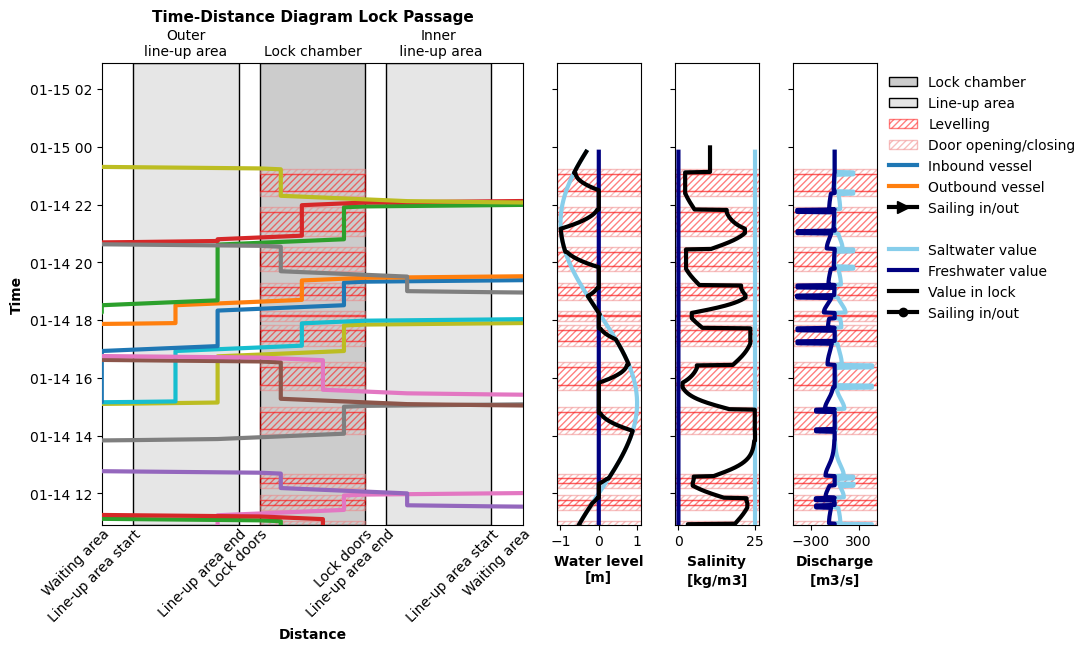

In [22]:
delays = False
entering_leaving = False

distance_to_lock_edge_start = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_49'))['Distance'].sum()
distance_to_lock_edge_end = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_50'))['Distance'].sum()
lock_outer_doors = distance_to_lock_edge_start+lock_1.distance_doors1_from_first_waiting_area
lock_inner_doors = distance_to_lock_edge_end-lock_1.distance_doors1_from_first_waiting_area
lineup_1_start = lock_outer_doors - lineup_area_1.distance_to_lock_doors - lineup_area_1.lineup_length
lineup_1_end = lock_outer_doors - lineup_area_1.distance_to_lock_doors
lineup_2_start = lock_inner_doors + lineup_area_2.distance_to_lock_doors + lineup_area_2.lineup_length
lineup_2_end = lock_inner_doors + lineup_area_2.distance_to_lock_doors

fig,axes = plt.subplots(1,4,figsize=[10,6],gridspec_kw = {'width_ratios':[5,1,1,1]})
ax = axes[0]
for time,distance in zip(times,distances):
    ax.plot(distance,time,linewidth=3,zorder=3)
vessel1, = ax.plot([-1,-1],color='C0',linewidth=3)
vessel2, = ax.plot([-1,-1],color='C1',linewidth=3)
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    if len(vessel_df) < 120:
        continue
    arrival_time = datetime.datetime.fromtimestamp(_vessel_.arrival_time)
    if _vessel_.route[0] == 'Node_98':
        sail_in_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_inner_doors-40,sail_in_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
            ax.plot(lock_outer_doors-40,sail_out_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
        if delays:
            ax.plot([final_geometry.length,0],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C1',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_1_start-lineup_1_end)+lineup_1_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(50+annotate_location,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=90,verticalalignment='center',horizontalalignment='center',color='C1')        

    else:
        sail_in_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_outer_doors+40,sail_in_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
            ax.plot(lock_inner_doors+40,sail_out_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
        if delays:
            ax.plot([0,final_geometry.length],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C0',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_2_start-lineup_2_end)+lineup_2_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(annotate_location-120,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=270,verticalalignment='center',horizontalalignment='center',color='C0')        
        
lock_df = pd.DataFrame(lock_1.log)
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        levelling, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        door_opening_closing, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    
ylim_min = lock_df.loc[0].Time-pd.Timedelta(1,'h')
ylim_max = lock_df.iloc[-7].Time+pd.Timedelta(5,'h')
ylim_min = ylim_max - pd.Timedelta(16,'h')
#ylim_max = ylim_min + pd.Timedelta(5,'h')
#ylim_min += pd.Timedelta(12,'h')
#ylim_max = ylim_min + pd.Timedelta(12,'h')

ax.set_ylim(ylim_min,ylim_max)
ylim = ax.get_ylim()
lineup_area_fill, = ax.fill([lineup_1_start,lineup_1_start,lineup_1_end,lineup_1_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
ax.fill([lineup_2_start,lineup_2_start,lineup_2_end,lineup_2_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
lock_chamber_fill, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.8,0.8,0.8],edgecolor='k')
ax.set_xlim([distance_to_lock_edge_start,distance_to_lock_edge_end])
ax.set_ylim(ylim)
ax.set_xticks([])

ax.text(50/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(200/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(700/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(800/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1300/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1400/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1900/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(2050/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(400/2000,1.075,'Outer\nline-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1000/2000,1.075,'\nLock chamber',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1600/2000,1.075,'Inner\n line-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.set_xlabel('Distance',labelpad=70,fontweight='bold')
ax.set_ylabel('Time',fontweight='bold')
ax.set_title('Time-Distance Diagram Lock Passage',fontsize=11,fontweight='bold',pad=30)

ax = axes[1]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=48)['Water level'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=49)['Water level'].TIME.values,
        color='navy',zorder=3,linewidth=3)
lock_level, = ax.plot(lock_1.water_level.values,lock_1.water_level.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nWater level',fontsize=11,fontweight='bold')
ax.set_xticks([-1,0,1])
ax.set_xlabel('Water level\n[m]',fontweight='bold')

ax = axes[2]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=48)['Salinity'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=49)['Salinity'].TIME.values,
        color='navy',zorder=3,linewidth=3)
ax.plot(lock_1.salinity.values,lock_1.salinity.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nSalinity',fontsize=11,fontweight='bold')
ax.set_xticks([0,25])
ax.set_xlabel('Salinity\n'+r'[kg/m$\mathregular{3}$]',fontweight='bold')

ax = axes[3]
ax.set_facecolor('white')
freshwater, = ax.plot(lock_1.discharge_fresh.values,lock_1.discharge_fresh.TIME.values,color='navy',linewidth=3,zorder=4)
if entering_leaving:
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_in_time_vessel_1).values,sail_in_time_vessel_1,marker='o',color='navy',markersize=6)
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_out_time_vessel_1).values,sail_out_time_vessel_1,marker='o',color='navy',markersize=6)
saltwater, = ax.plot(lock_1.discharge_saline.values,lock_1.discharge_saline.TIME.values,color='skyblue',linewidth=3,zorder=3)
if entering_leaving:
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_in_time_vessel_2).values,sail_in_time_vessel_2,marker='o',color='skyblue',markersize=6)
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_out_time_vessel_2).values,sail_out_time_vessel_2,marker='o',color='skyblue',markersize=6)
sail_in_out_arrow, = ax.plot([0,0],color='k',marker='>',markersize=8,linewidth=3)
sail_in_out_point, = ax.plot([0,0],color='k',marker='o',markersize=6,linewidth=3)

ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nDischarge',fontsize=11,fontweight='bold')
ax.legend([lock_chamber_fill,lineup_area_fill,levelling,door_opening_closing,vessel1,vessel2,sail_in_out_arrow,mpl.patches.Patch(color='none'),
           saltwater,freshwater,lock_level,sail_in_out_point],
          ['Lock chamber','Line-up area','Levelling','Door opening/closing','Inbound vessel','Outbound vessel','Sailing in/out','',
           'Saltwater value','Freshwater value','Value in lock','Sailing in/out'],
          bbox_to_anchor=[1,1],frameon=False,prop={'size':10})
ax.set_xticks([-300,300])
ax.set_xlabel('Discharge\n'+r'[m$\mathregular{3}$/s]',fontweight='bold');
#fig.savefig('Basic_lock_passage.svg',dpi=500,format='svg',bbox_inches='tight');

In [23]:
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting start':
        if lock_df.loc[loc-1,'Action'] != 'Lock doors closing stop':
            print(loc)
        if lock_df.loc[loc+1,'Action'] != 'Lock chamber converting stop':
            print(loc)

In [24]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=50)

,Time,Location,Action,Status
1384,2019-01-14 12:31:09.994521,Node_49,Lock doors opening start,{}
1385,2019-01-14 12:41:09.994521,Node_49,Lock doors opening stop,{}
1386,2019-01-14 14:04:04.140120,Node_49,Lock doors closing start,{}
1387,2019-01-14 14:14:04.140120,Node_49,Lock doors closing stop,{}
1388,2019-01-14 14:14:04.140120,Node_49,Lock chamber converting start,{}
1389,2019-01-14 14:50:04.140120,Node_50,Lock chamber converting stop,{}
1390,2019-01-14 14:50:04.140120,Node_50,Lock doors opening start,{}
1391,2019-01-14 15:00:04.140120,Node_50,Lock doors opening stop,{}
1392,2019-01-14 15:35:22.514220,Node_50,Lock doors closing start,{}
1393,2019-01-14 15:45:22.514220,Node_50,Lock doors closing stop,{}


In [25]:
salt_transport_df = pd.DataFrame(columns=['Side','Levelling start','Levelling stop','Door Open','Door Closed',
                                          'Water level start levelling','Water level stop levelling',
                                          'Ship Volume Left','Ship Volume Entered'])
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock doors closing stop' and loc > 2:
        levelling_start = lock_df.loc[loc-5].Time
        levelling_stop = lock_df.loc[loc-4].Time
        index_levelling_start = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_start)).argmin()
        index_levelling_stop = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_stop)).argmin()
        water_level_start_levelling = lock_1.water_level[index_levelling_start].values
        water_level_stop_levelling = lock_1.water_level[index_levelling_stop].values
        door_open = (lock_df.loc[loc-2].Time-lock_df.loc[loc-3].Time)/2+lock_df.loc[loc-3].Time
        door_closed = (info.Time-lock_df.loc[loc-1].Time)/2+lock_df.loc[loc-1].Time
        volume_loss = 0
        volume_transported = 0
        for _vessel_ in vessels:
            vessel_df = pd.DataFrame(_vessel_.log)
            if vessel_df.empty:
                continue
            vessel_df_door_open_time = vessel_df[(vessel_df.Time > door_open - datetime.timedelta(seconds=lock_1.doors_open)) & 
                                                 (vessel_df.Time < door_closed + datetime.timedelta(seconds=lock_1.doors_close))]
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[0].Action == 'Passing lock stop':
                volume_loss += _vessel_.L*_vessel_.B*_vessel_.T
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[-1].Action == 'Passing lock start':
                volume_transported += _vessel_.L*_vessel_.B*_vessel_.T
        salt_transport_df.loc[len(salt_transport_df),:] = [info.Location,levelling_start,levelling_stop,door_open,door_closed,
                                                           water_level_start_levelling,water_level_stop_levelling,
                                                           volume_loss,volume_transported]

In [26]:
salt_transport_df['Salt Exchange [kg]'] = 0.0
salt_transport_df['Salt Transported [kg]'] = 0.0
salt_transport_df['Freshwater Exchange [m3]'] = 0.0
salt_transport_df['Freshwater Transported [m3]'] = 0.0
salt_transport_df['Freshwater Levelled [m3]'] = 0.0

for loc,info in salt_transport_df.iterrows():
    if info.Side == 'Node_50':
        salinity_difference = lock_1.salinity.interp(TIME=info['Door Open']).values-np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])
        salt_transport_df.loc[loc,'Salt Exchange [kg]'] = salinity_difference*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth
        salt_transport_df.loc[loc,'Salt Transported [kg]'] = np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])*info['Ship Volume Entered']
        salt_transport_df.loc[loc,'Freshwater Exchange [m3]'] = lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth*np.tanh((info['Door Closed']-info['Door Open']).total_seconds()/(2*lock_1.lock_length/(0.5*np.sqrt(9.81*0.8*salinity_difference*lock_1.lock_depth/(1000+0.8*25/2)))))
        salt_transport_df.loc[loc,'Freshwater Transported [m3]'] = info['Ship Volume Left']
        water_levelling_difference = info['Water level stop levelling']-info['Water level start levelling']
        if water_levelling_difference > 0:
            salt_transport_df['Freshwater Levelled [m3]'] = water_levelling_difference

In [27]:
(salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum())/(25*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

55.99926287640752

In [28]:
delay_df = pd.DataFrame(columns=['Delay'])
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    start_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 start']
    stop_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 stop']
    if stop_df.empty or start_df.empty:
        continue
    start_time = start_df.Time.iloc[0]
    stop_time = stop_df.Time.iloc[0]
    delay = stop_time-start_time-pd.Timedelta(FG.edges['Node_49','Node_50',0]['Info']['length']/vessels[0].v,'s')
    delay_df.loc[_vessel_.name,'Delay'] = delay

In [29]:
average_vessel_delay = delay_df.Delay.sum()/len(delay_df)

In [30]:
average_vessel_delay

Timedelta('0 days 01:53:43.704048603')

In [35]:
(salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum())/(25*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

55.99926287640752

In [32]:
salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum()

293996130.1011395